# Model Development - Model for predicting prices/returns


## Models that will be developed

We will try a variety of models to forecast Bitcoin prices, experimenting with different features, architectures, and hyperparameters.

#### Baseline Time Series Models

As the baseline, we will implement:
- **Naive Forecast**: Uses the last observed value as the forecast for all future time steps. We need to remember it will only predict one step ahead.
- **ARIMA**: A traditional time series model to capture linear dependencies and autocorrelation.
- **SARIMA**: Extends ARIMA with seasonal components to capture cyclical patterns.

#### Machine Learning Models

Next, we will implement machine learning models to leverage engineered features:
- **Gradient Boosting Machines (XGBoost, LightGBM)**: Powerful ensemble methods that iteratively improve predictions on difficult samples.

#### Other Time Series Models 

We will also explore specialized time series forecasting libraries and models:
- **Exponential Smoothing (ETS)**: Captures trend and seasonality through weighted averaging of past observations.
- **GARCH**: Models volatility in time series data, particularly useful for financial applications.
- **Prophet**: A robust forecasting tool designed to handle trend breaks and missing data.

#### Deep Learning Models

Finally, we will explore deep learning architectures designed for sequential data:
- **LSTM (Long Short-Term Memory)**: Captures long-term dependencies in sequential data through gated memory cells.
- **GRU (Gated Recurrent Units)**: A more efficient variant of LSTM with similar performance.

#### Multiple Prediction Targets

To identify the most predictable target, we will experiment with different prediction objectives:
- **Close Price**: Directly forecasting the closing price, useful for absolute valuation.
- **Return**: Forecasting percentage change in price, which may be more stable and easier to predict.
- **Log Return**: Forecasting logarithmic returns to stabilize variance and capture relative changes.

## Evaluation Metrics

**Primary Metric:**
- **RMSE (Root Mean Squared Error)** - Our main evaluation metric. Penalizes large prediction errors heavily, making it sensitive to extreme forecasting errors during volatile periods. Expressed in original units, directly interpretable, and aligns with risk management in trading where large errors are costly.

**Supporting Metrics:**
- **MAE (Mean Absolute Error)** - Average absolute prediction error in original units, provides a robustness check by giving equal weight to all errors without penalizing extremes, complementing RMSE's sensitivity.

- **MAPE (Mean Absolute Percentage Error)** - Scale-independent metric expressing accuracy as a percentage, enables comparison across different price levels and time periods (comparing 2014 predictions to 2025).

- **Directional Accuracy** - Measures the percentage of times the model correctly predicts the direction of price movement (up or down), important for trading strategies focused on market direction rather than exact price levels.

- **Comparison to Naive Baseline** - All models will be compared against the naive forecast to ensure they provide meaningful improvements over a simple persistence model.


## Helper Functions

In `notebook_utils.py` there are helper functions to facilitate model development:

- `time_series_train_test_split`: Splits time series data into training and testing sets while preserving temporal order.

- `back_transform_returns_to_prices`: Converts predicted returns back to price levels for evaluation.

- `calculate_evaluation_metrics`: Computes RMSE, MAE, MAPE, and Directional Accuracy for model predictions.

- `plot_forecasts`: Visualizes actual vs. forecasted values over time for qualitative assessment.

## 0. Import Libraries, Define Constants and Load Data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set global plotting style
sns.set_theme(style="whitegrid")

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from prophet import Prophet
from arch import arch_model

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
import optuna

import torch
from torch.utils.data import DataLoader

from utils.common_utils import (
    time_series_train_val_test_split,
    plot_forecasts,
    calculate_evaluation_metrics,
    plot_forecasts_with_biggest_mistakes,
    plot_learning_curves,
    plot_top_models,
    plot_top_models_train_val,
    train_nn_model,
)

from utils.price_prediction_utils import (
    back_transform_returns_to_price,
    evaluate_feature_set,
)

from utils.model_development_classes import (
    FixedNaiveForecaster,
    RollingNaiveForecaster,
    SequenceDataset,
)

/Users/klipiec/Desktop/Internship/projects/crypto_forecasting_project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants

# Base directories
DATA_DIR = Path("../data/")
FILE_NAME = "bitcoin_data_processed.csv"
DATA_PATH = DATA_DIR / FILE_NAME

# Reproducibility
RANDOM_SEED = 2137

# Results container
MODEL_RESULTS = {}

# Data split ratios
TRAIN_SIZE = 0.7
VALIDATION_SIZE = 0.15
TEST_SIZE = 0.15

# Features in the dataset
PRICE_DYNAMICS = [
    "Close",
    "Return",
    "Log_Return",
    "Price_Diff",
    "Low_High_Diff",
    "Open_Close_Diff",
    "Open_Close_Up",
    "SMA_30",
]
LAG_FEATURES = [
    "Close_Lag1",
    "Close_Lag5",
    "Close_Lag7",
    "Close_Lag30",
    "Return_Lag1",
    "Return_Lag5",
    "Return_Lag7",
    "Return_Lag30",
]
TECH_INDICATORS = ["MACD", "RSI", "Volume"]

ROLLING_STATS = ["Rolling_Mean_Return_30", "Rolling_Std_Return_30"]

MOMENTUM_FEATURES = ["Close_Change_5d", "Close_Change_10d", "Close_Change_20d"]

TEMPORAL_FEATURES = ["Month_Sin", "Month_Cos", "DayOfWeek_Sin", "DayOfWeek_Cos"]

# All features
ALL_FEATURES = (
    PRICE_DYNAMICS
    + LAG_FEATURES
    + TECH_INDICATORS
    + ROLLING_STATS
    + MOMENTUM_FEATURES
    + TEMPORAL_FEATURES
)

# Baseline features for base models
BASELINE_FEATURES = [
    "Close",
    "Volume",
    "Close_Lag7",
    "Close_Lag30",
    "Return",
    "Return_Lag7",
    "Return_Lag30",
    "Month_Sin",
    "Month_Cos",
    "DayOfWeek_Sin",
    "DayOfWeek_Cos",
]

In [3]:
# Load Data
df = pd.read_csv(DATA_PATH)

In [4]:
df.head()

Date       Close        High         Low        Open    Return  \
0  2014-10-18  391.441986  395.157990  378.971008  383.976013  0.020023   
1  2014-10-19  389.545990  393.938995  386.457001  391.253998 -0.004844   
2  2014-10-20  382.845001  390.084015  378.252014  389.230988 -0.017202   
3  2014-10-21  386.475006  392.645996  380.834015  382.420990  0.009482   
4  2014-10-22  383.157990  388.575989  382.248993  386.118011 -0.008583   

   Log_Return  Price_Diff    Volume  Close_Lag1  ...  Close_Change_20d  \
0    0.019825    7.683990  11416800  383.757996  ...          0.037809   
1   -0.004855   -1.895996   5914570  391.441986  ...          0.037497   
2   -0.017352   -6.700989  16419000  389.545990  ...         -0.010593   
3    0.009437    3.630005  14188900  382.845001  ...          0.007455   
4   -0.008620   -3.317017  11641300  386.475006  ...          0.021559   

       MACD        RSI  Month  DayOfWeek  Day  Month_Sin  Month_Cos  \
0  1.847972  75.469711     10          5   18  -0.866025        0.5   
1  2.414320  79.658722     10          6   19  -0.866025        0.5   
2  2.330291  73.241668     10          0   20  -0.866025        0.5   
3  2.509406  72.644511     10          1   21  -0.866025        0.5   
4  2.371179  65.480215     10          2   22  -0.866025        0.5   

   DayOfWeek_Sin  DayOfWeek_Cos  
0      -0.974928      -0.222521  
1      -0.781831       0.623490  
2       0.000000       1.000000  
3       0.781831       0.623490  
4       0.974928      -0.222521  

[5 rows x 35 columns]

We will convert `Date` to datetime format and set it as the index for time series operations.
Also, wel will drop Open, High and Low columns as we will focus on Close prices for modeling.

In [5]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

In [6]:
df = df.drop(["Open", "High", "Low"], axis=1)
df.head()

Close    Return  Log_Return  Price_Diff    Volume  \
Date                                                                 
2014-10-18  391.441986  0.020023    0.019825    7.683990  11416800   
2014-10-19  389.545990 -0.004844   -0.004855   -1.895996   5914570   
2014-10-20  382.845001 -0.017202   -0.017352   -6.700989  16419000   
2014-10-21  386.475006  0.009482    0.009437    3.630005  14188900   
2014-10-22  383.157990 -0.008583   -0.008620   -3.317017  11641300   

            Close_Lag1  Close_Lag5  Close_Lag7  Close_Lag30  Return_Lag1  ...  \
Date                                                                      ...   
2014-10-18  383.757996  390.414001  362.299011   424.440002     0.003142  ...   
2014-10-19  391.441986  400.869995  378.549011   394.795990     0.020023  ...   
2014-10-20  389.545990  394.773010  390.414001   408.903992    -0.004844  ...   
2014-10-21  382.845001  382.556000  400.869995   398.821014    -0.017202  ...   
2014-10-22  386.475006  383.757996  394.773010   402.152008     0.009482  ...   

            Close_Change_20d      MACD        RSI  Month  DayOfWeek  Day  \
Date                                                                       
2014-10-18          0.037809  1.847972  75.469711     10          5   18   
2014-10-19          0.037497  2.414320  79.658722     10          6   19   
2014-10-20         -0.010593  2.330291  73.241668     10          0   20   
2014-10-21          0.007455  2.509406  72.644511     10          1   21   
2014-10-22          0.021559  2.371179  65.480215     10          2   22   

            Month_Sin  Month_Cos  DayOfWeek_Sin  DayOfWeek_Cos  
Date                                                            
2014-10-18  -0.866025        0.5      -0.974928      -0.222521  
2014-10-19  -0.866025        0.5      -0.781831       0.623490  
2014-10-20  -0.866025        0.5       0.000000       1.000000  
2014-10-21  -0.866025        0.5       0.781831       0.623490  
2014-10-22  -0.866025        0.5       0.974928      -0.222521  

[5 rows x 31 columns]

In [7]:
df.columns

Index(['Close', 'Return', 'Log_Return', 'Price_Diff', 'Volume', 'Close_Lag1',
       'Close_Lag5', 'Close_Lag7', 'Close_Lag30', 'Return_Lag1', 'Return_Lag5',
       'Return_Lag7', 'Return_Lag30', 'SMA_30', 'Rolling_Mean_Return_30',
       'Rolling_Std_Return_30', 'Low_High_Diff', 'Open_Close_Diff',
       'Open_Close_Up', 'Close_Change_5d', 'Close_Change_10d',
       'Close_Change_20d', 'MACD', 'RSI', 'Month', 'DayOfWeek', 'Day',
       'Month_Sin', 'Month_Cos', 'DayOfWeek_Sin', 'DayOfWeek_Cos'],
      dtype='str')

## 1. Model Development

### 1.1 Naive Forecast Model

Naive forecasting is just using the last observed value as the forecast for all future time steps. It may base its predictions on the last day of training data or the last known value before each prediction in the test set. We will implement both approaches.

#### Predicting last observed Close Price in training set

In [8]:
train_df, val_df, test_df = time_series_train_val_test_split(
    df, TRAIN_SIZE, VALIDATION_SIZE
)

naive_model = FixedNaiveForecaster()
naive_model.fit(train_df["Close"])

n_periods = len(val_df)
naive_forecasts = naive_model.predict(n_periods)

naive_forecast_metrics = calculate_evaluation_metrics(val_df["Close"], naive_forecasts)

print("Naive Forecast Model Evaluation Metrics on Validation Set:")

for metric, value in naive_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["Naive_Forecast"] = {
    "model": naive_model,
    "val_metrics": naive_forecast_metrics,
    "target": "Close",
    "predictions": naive_forecasts,
}

Naive Forecast Model Evaluation Metrics on Validation Set:
MAE: 13516.4519
RMSE: 19520.7038
MAPE: 32.7369
Directional_Accuracy: 50.8943


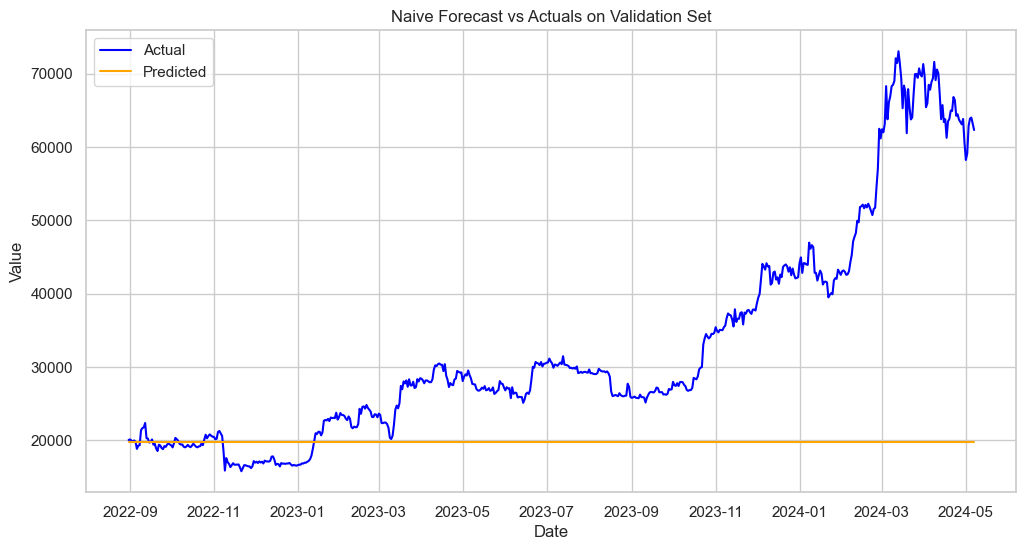

In [9]:
plot_forecasts(
    val_df.index,
    val_df["Close"],
    naive_forecasts,
    title="Naive Forecast vs Actuals on Validation Set",
)

We can see that the naive forecast does not perform well, especially during volatile periods. The RMSE and MAE are quite high, indicating large prediction errors.

#### Predicting last observed Close Price - Rolling Naive Forecast

This rolling naive forecast will always use the value from the previous day as the prediction for the current day. 

In [10]:
df_rolling_naive = df.copy()

df_rolling_naive["target"] = df_rolling_naive["Close"].shift(-1)
df_rolling_naive = df_rolling_naive.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    df_rolling_naive, TRAIN_SIZE, VALIDATION_SIZE
)

naive_model = RollingNaiveForecaster()
naive_model.fit(train_df["Close"])

rolling_naive_forecasts = naive_model.predict(val_df["Close"])

# Get actual tomorrow's prices
val_tomorrow_actual = val_df["target"]

# Calculate metrics
naive_forecast_metrics = calculate_evaluation_metrics(
    val_tomorrow_actual,
    rolling_naive_forecasts,
)

print("Naive Rolling Forecast Model Evaluation Metrics on Validation Set:")

for metric, value in naive_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["Naive_Rolling_Forecast"] = {
    "model": naive_model,
    "val_metrics": naive_forecast_metrics,
    "target": "Close",
    "predictions": rolling_naive_forecasts,
}

Naive Rolling Forecast Model Evaluation Metrics on Validation Set:
MAE: 602.5231
RMSE: 1015.8425
MAPE: 1.7225
Directional_Accuracy: 0.0000


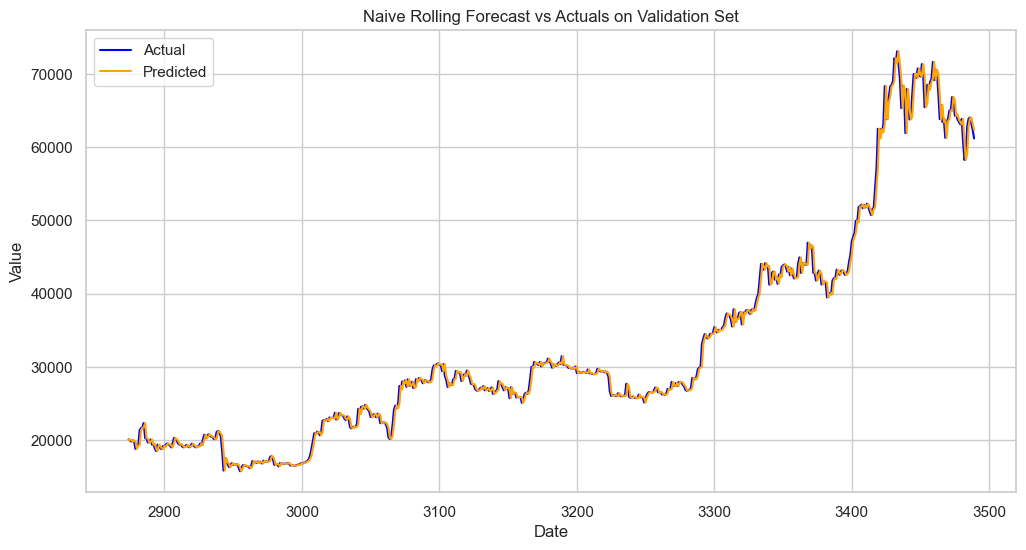

In [11]:
plot_forecasts(
    val_df.index,
    val_tomorrow_actual,
    rolling_naive_forecasts,
    title="Naive Rolling Forecast vs Actuals on Validation Set",
)

We can see that predicting yesterday's price as today's forecast significantly improves performance over the static naive forecast. The RMSE and MAE are much lower, indicating more accurate predictions. This shows that using the most recent actual value helps capture short-term trends better than relying solely on the last training observation. It may be hard to beat this simple rolling naive approach, especially for short-term forecasts in a volatile market like cryptocurrency.

### 1.2 ARIMA/SARIMA Model

For ARIMA and SARIMA models, we can use the `pmdarima` library that provides convenient functions for automatic hyperparameter tuning and model fitting.

#### ARIMA Auto Model - Predicting Close Price

In [12]:
df_arima = df.copy()

train_df, val_df, test_df = time_series_train_val_test_split(
    df_arima, TRAIN_SIZE, VALIDATION_SIZE
)

# Non seasonal ARIMA model
auto_arima_model = auto_arima(
    y=train_df["Close"],  # Time series data
    start_p=0,  # Minimum AR (p) order to test
    start_d=0,  # Minimum differencing (d) order to test
    start_q=0,  # Minimum MA (q) order to test
    max_p=3,  # Maximum AR (p) order (reduced for seasonal)
    max_d=2,  # Maximum differencing (d) order
    max_q=3,  # Maximum MA (q) order (reduced for seasonal)
    m=1,  # Seasonality period, for non-seasonal set to 1
    seasonal=False,  # Enable seasonal ARIMA (SARIMA)
    stepwise=True,  # Use stepwise algorithm for faster computation
    trace=True,  # Print iteration details
    error_action="ignore",  # Ignore errors in model fitting
    suppress_warnings=True,  # Suppress convergence warnings
    information_criterion="aic",  # Use AIC for model selection
    random_state=RANDOM_SEED,  # For reproducibility
)

n_periods = len(val_df)
arima_forecasts = auto_arima_model.predict(n_periods=n_periods)

val_actual_prices = val_df["Close"]


arima_forecast_metrics = calculate_evaluation_metrics(
    val_actual_prices, arima_forecasts
)
print("\nARIMA Model Evaluation Metrics on Validation Set:")
for metric, value in arima_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["ARIMA_Close"] = {
    "model": auto_arima_model,
    "val_metrics": arima_forecast_metrics,
    "target": "Close",
    "predictions": arima_forecasts,
}

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46626.792, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46626.846, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46626.870, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46624.993, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46628.827, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.194 seconds

ARIMA Model Evaluation Metrics on Validation Set:
MAE: 13516.4519
RMSE: 19520.7038
MAPE: 32.7369
Directional_Accuracy: 50.8943


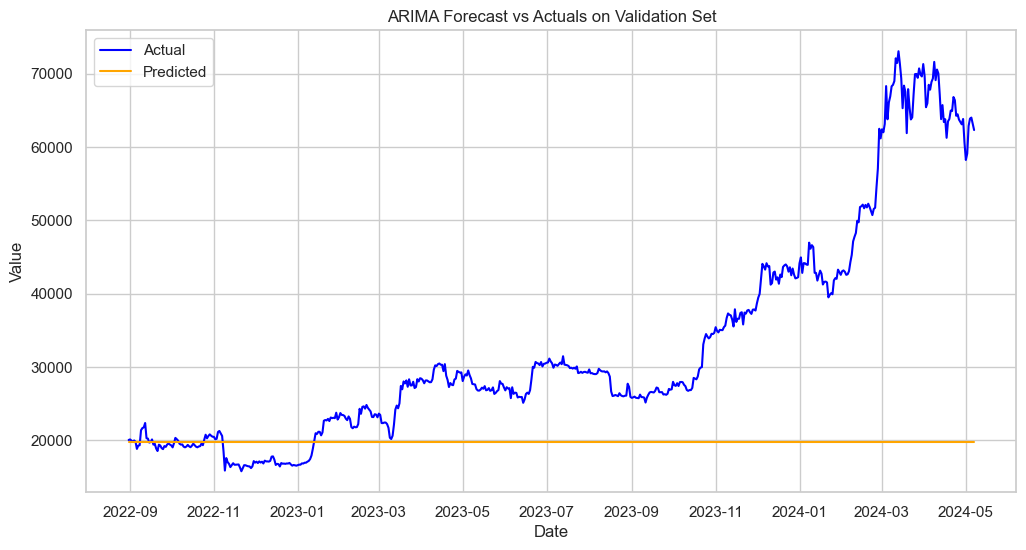

In [13]:
plot_forecasts(
    val_df.index,
    val_actual_prices,
    arima_forecasts,
    title="ARIMA Forecast vs Actuals on Validation Set",
)

We can see that ARIMA is completely useless as the close price is non-stationary. The model fails to capture the underlying trend and volatility, resulting in very high RMSE and MAE values. This highlights the importance of ensuring stationarity before applying ARIMA models to time series data. One common approach to achieve stationarity is differencing the time series, which can help remove trends and seasonality. In the next experiments with models that require stationarity, we will work with returns or log returns instead of raw prices.

#### ARIMA Auto Model - Predicting Returns

In [14]:
# Non seasonal ARIMA model
auto_arima_df = df.copy()

auto_arima_df["Next_Close"] = auto_arima_df["Close"].shift(-1)
auto_arima_df = auto_arima_df.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    auto_arima_df, TRAIN_SIZE, VALIDATION_SIZE
)

auto_arima_model = auto_arima(
    y=train_df["Return"],  # Time series data
    start_p=0,  # Minimum AR (p) order to test
    start_d=0,  # Minimum differencing (d) order to test
    start_q=0,  # Minimum MA (q) order to test
    max_p=3,  # Maximum AR (p) order (reduced for seasonal)
    max_d=2,  # Maximum differencing (d) order
    max_q=3,  # Maximum MA (q) order (reduced for seasonal)
    m=1,  # Seasonality period, for non-seasonal set to 1
    seasonal=False,  # Enable seasonal ARIMA (SARIMA)
    stepwise=True,  # Use stepwise algorithm for faster computation
    trace=True,  # Print iteration details
    error_action="ignore",  # Ignore errors in model fitting
    suppress_warnings=True,  # Suppress convergence warnings
    information_criterion="aic",  # Use AIC for model selection
    random_state=RANDOM_SEED,  # For reproducibility
)

n_periods = len(val_df)
arima_forecasts = auto_arima_model.predict(n_periods=n_periods)

y_actual_prices, y_pred_prices = back_transform_returns_to_price(
    val_df, arima_forecasts, "Close", "Next_Close"
)

arima_forecast_metrics = calculate_evaluation_metrics(y_actual_prices, y_pred_prices)

print("\nARIMA Model Evaluation Metrics on Validation Set:")
for metric, value in arima_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["ARIMA_Return"] = {
    "model": auto_arima_model,
    "val_metrics": arima_forecast_metrics,
    "target": "Return",
    "predictions": y_pred_prices,
}

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10528.060, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-10527.161, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-10527.142, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10525.176, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-10534.749, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-10534.226, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-10534.210, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10532.172, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.735 seconds

ARIMA Model Evaluation Metrics on Validation Set:
MAE: 605.2825
RMSE: 1014.0945
MAPE: 1.7387
Directional_Accuracy: 49.7561


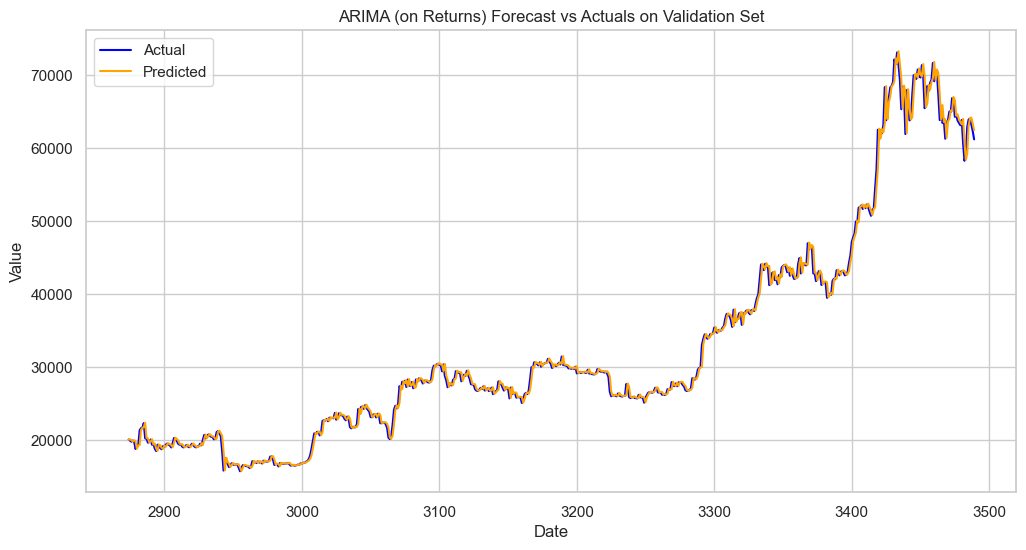

In [15]:
plot_forecasts(
    val_df.index,
    y_actual_prices,
    y_pred_prices,
    title="ARIMA (on Returns) Forecast vs Actuals on Validation Set",
)

In [16]:
# Count how many times each unique forecast value appears
unique_values, counts = np.unique(arima_forecasts, return_counts=True)

print(f"Total forecasts: {len(arima_forecasts)}")
print(f"Unique forecast values: {len(unique_values)}")
print("The only unique forecast values are:")
for value in unique_values:
    print(f"Value: {value:.8f}")

Total forecasts: 616
Unique forecast values: 1
The only unique forecast values are:
Value: 0.00212852


We can see that the results now are very similar to the rolling naive forecast. MAE and MSE are almost identical, only directional accuracy is better (0 -> 49.7561). Arima fitted is (0,0,0) which means it didn't learn anything useful - it always predicts the same small value (close to 0). As a result it is almost like predicting yeseteday's price as today's price, which is why the results are similar to the rolling naive forecast. We can also see how it will work if we try to predict log returns.

#### ARIMA Auto Model - Predicting Log Returns

In [17]:
# Non seasonal ARIMA model
auto_arima_df = df.copy()

auto_arima_df["Next_Close"] = auto_arima_df["Close"].shift(-1)
auto_arima_df = auto_arima_df.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    auto_arima_df, TRAIN_SIZE, VALIDATION_SIZE
)

auto_arima_model = auto_arima(
    y=train_df["Log_Return"],  # Time series data
    start_p=0,  # Minimum AR (p) order to test
    start_d=0,  # Minimum differencing (d) order to test
    start_q=0,  # Minimum MA (q) order to test
    max_p=3,  # Maximum AR (p) order (reduced for seasonal)
    max_d=2,  # Maximum differencing (d) order
    max_q=3,  # Maximum MA (q) order (reduced for seasonal)
    m=1,  # Seasonality period, for non-seasonal set to 1
    seasonal=False,  # Enable seasonal ARIMA (SARIMA)
    stepwise=True,  # Use stepwise algorithm for faster computation
    trace=True,  # Print iteration details
    error_action="ignore",  # Ignore errors in model fitting
    suppress_warnings=True,  # Suppress convergence warnings
    information_criterion="aic",  # Use AIC for model selection
    random_state=RANDOM_SEED,  # For reproducibility
)

n_periods = len(val_df)
arima_forecasts = auto_arima_model.predict(n_periods=n_periods)

y_actual_prices, y_pred_prices = back_transform_returns_to_price(
    val_df, arima_forecasts, "Close", "Next_Close", log=True
)

arima_forecast_metrics = calculate_evaluation_metrics(y_actual_prices, y_pred_prices)

print("\nARIMA Model Evaluation Metrics on Validation Set:")
for metric, value in arima_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["ARIMA_Log_Return"] = {
    "model": auto_arima_model,
    "val_metrics": arima_forecast_metrics,
    "target": "Log_Return",
    "predictions": y_pred_prices,
}

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10484.420, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-10483.769, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-10483.742, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10481.853, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-10485.973, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-10485.484, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-10485.458, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10483.542, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.857 seconds

ARIMA Model Evaluation Metrics on Validation Set:
MAE: 603.4508
RMSE: 1014.0604
MAPE: 1.7300
Directional_Accuracy: 49.7561


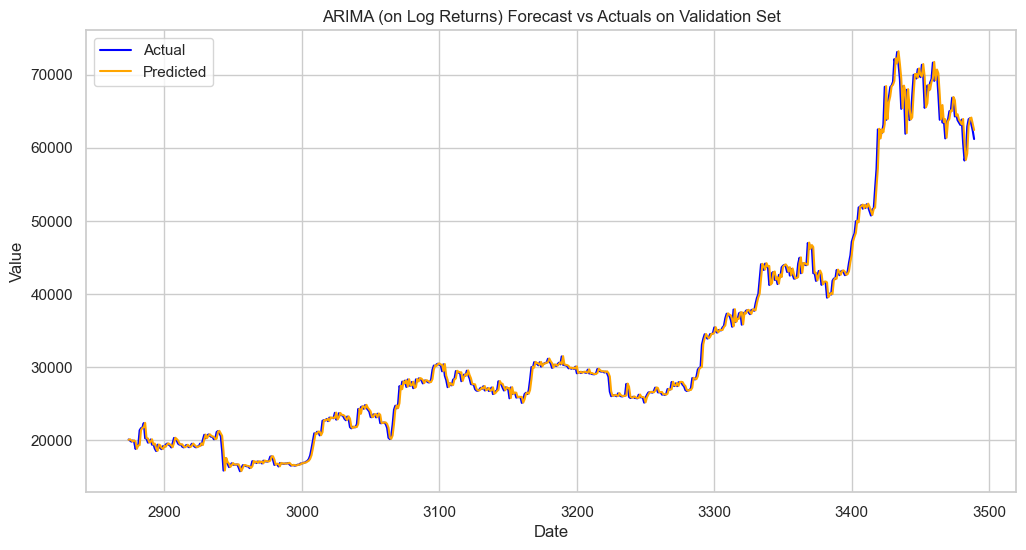

In [18]:
plot_forecasts(
    val_df.index,
    y_actual_prices,
    y_pred_prices,
    title="ARIMA (on Log Returns) Forecast vs Actuals on Validation Set",
)

In [19]:
# Count how many times each unique forecast value appears
unique_values, counts = np.unique(arima_forecasts, return_counts=True)

print(f"Total forecasts: {len(arima_forecasts)}")
print(f"Unique forecast values: {len(unique_values)}")
print("The only unique forecast values are:")
for value in unique_values:
    print(f"Value: {value:.8f}")

Total forecasts: 616
Unique forecast values: 1
The only unique forecast values are:
Value: 0.00137205


We can see that for log return situation is the same as for regular returns. The model fitted is (0,0,0) again, meaning it didn't learn anything useful and always predicts the small value (close to 0).

#### SARIMA Auto Model - Predicting Returns

In [20]:
sarima_df = df.copy()

sarima_df["Next_Close"] = sarima_df["Close"].shift(-1)
sarima_df = sarima_df.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    sarima_df, TRAIN_SIZE, VALIDATION_SIZE
)

auto_sarima_model = auto_arima(
    y=train_df["Return"],  # Time series data
    start_p=0,  # Minimum AR (p) order to test
    start_d=0,  # Minimum differencing (d) order to test
    start_q=0,  # Minimum MA (q) order to test
    max_p=2,  # Maximum AR (p) order
    max_d=1,  # Maximum differencing (d) order
    max_q=2,  # Maximum MA (q) order
    start_P=0,  # Minimum seasonal AR (P) order
    start_D=0,  # Minimum seasonal differencing (D) order
    start_Q=0,  # Minimum seasonal MA (Q) order
    max_P=1,  # Maximum seasonal AR (P) order
    max_D=1,  # Maximum seasonal differencing (D) order
    max_Q=1,  # Maximum seasonal MA (Q) order
    m=12,  # Seasonality period (12 months)
    seasonal=True,  # Enable seasonal ARIMA (SARIMA)
    stepwise=True,  # Use stepwise algorithm for faster computation
    trace=True,  # Print iteration details
    error_action="ignore",  # Ignore errors in model fitting
    suppress_warnings=True,  # Suppress convergence warnings
    information_criterion="aic",  # Use AIC for model selection
    random_state=RANDOM_SEED,  # For reproducibility
)

n_periods = len(val_df)
sarima_forecasts = auto_sarima_model.predict(n_periods=n_periods)

y_actual_prices, y_pred_prices = back_transform_returns_to_price(
    val_df, sarima_forecasts, "Close", "Next_Close"
)
sarima_forecast_metrics = calculate_evaluation_metrics(y_actual_prices, y_pred_prices)

print("\nSARIMA Model Evaluation Metrics on Validation Set:")
for metric, value in sarima_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["SARIMA_Return"] = {
    "model": auto_sarima_model,
    "val_metrics": sarima_forecast_metrics,
    "target": "Return",
    "predictions": y_pred_prices,
}

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-10534.749, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-10532.447, Time=0.95 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-10532.423, Time=1.42 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-10528.060, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-10532.989, Time=0.34 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-10532.981, Time=0.38 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-10531.513, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-10534.226, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-10534.210, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-10532.172, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 4.067 seconds

SARIMA Model Evaluation Metrics on Validation Set:
MAE: 605.2825
RMSE: 1014.0945
MAPE: 1.7387
Directional_Accuracy: 49.7561


Same result as ARIMA - (0, 0, 0) - no differencing, no AR or MA terms. No sense to try with log returns as the result will be the same.

### 1.3 Machine Learning Models

#### XGBoost Model

For the XGBoost model, we will use the `xgboost` library to train a regression model on our engineered features. At start we will use base features defined at the beginning of the notebook, and later we will try incorporating additional engineered features to see if they improve performance. We will try to predict Close price first and then returns/log returns.

##### Predicting Close Price

In [21]:
# Copy df to avoid modifying original data
df_xgb = df.copy()

df_xgb = df_xgb[BASELINE_FEATURES]

# Create target variable by shifting 'Close' column
df_xgb["target"] = df_xgb["Close"].shift(-1)
df_xgb = df_xgb.dropna().reset_index(drop=True)

# Split into train, validation and test set
train_df, val_df, test_df = time_series_train_val_test_split(
    df_xgb, TRAIN_SIZE, VALIDATION_SIZE
)

# Separate features and target for train, validation, and test sets
X_train = train_df.drop(columns=["target"])
y_train = train_df["target"]
X_val = val_df.drop(columns=["target"])
y_val = val_df["target"]
X_test = test_df.drop(columns=["target"])
y_test = test_df["target"]

# Initialize and train XGBoost regressor - basic setup
xgb_model = xgb.XGBRegressor(random_state=RANDOM_SEED)

xgb_model.fit(X_train, y_train)
xgb_train_forecasts = xgb_model.predict(X_train)
xgb_val_forecasts = xgb_model.predict(X_val)

xgb_train_forecast_metrics = calculate_evaluation_metrics(y_train, xgb_train_forecasts)
print("XGBoost Model Evaluation Metrics on Training Set:")
for metric, value in xgb_train_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

xgb_val_forecast_metrics = calculate_evaluation_metrics(y_val, xgb_val_forecasts)
print("\nXGBoost Model Evaluation Metrics on Validation Set:")
for metric, value in xgb_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["XGBoost_Close"] = {
    "model": xgb_model,
    "train_metrics": xgb_train_forecast_metrics,
    "val_metrics": xgb_val_forecast_metrics,
    "features": X_train.columns.tolist(),
    "target": "Close",
    "predictions": xgb_val_forecasts,
}

XGBoost Model Evaluation Metrics on Training Set:
MAE: 58.0724
RMSE: 89.4973
MAPE: 2.0424
Directional_Accuracy: 78.3850

XGBoost Model Evaluation Metrics on Validation Set:
MAE: 1631.6041
RMSE: 2324.9632
MAPE: 5.0484
Directional_Accuracy: 49.2683


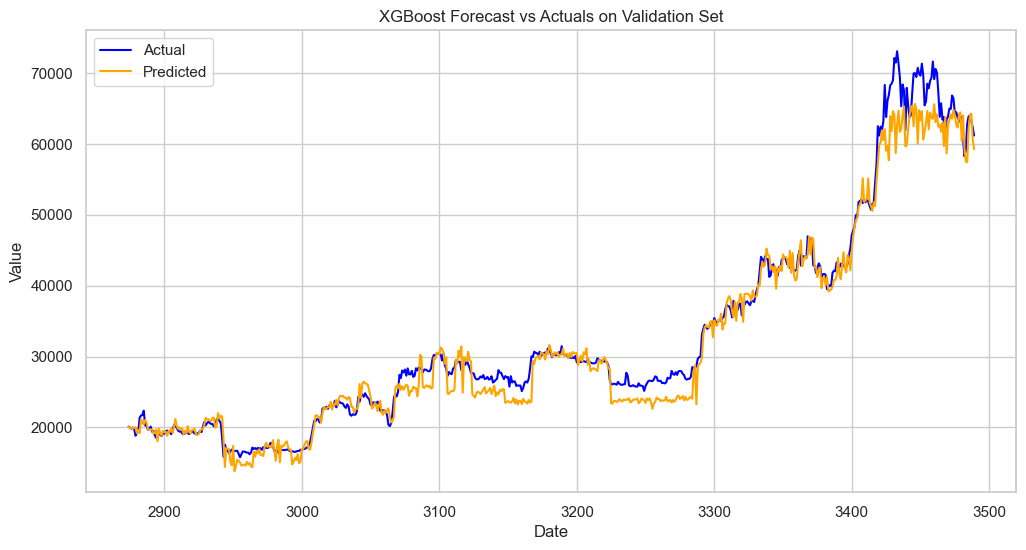

In [22]:
plot_forecasts(
    val_df.index,
    y_val,
    xgb_val_forecasts,
    title="XGBoost Forecast vs Actuals on Validation Set",
)

We can see that the results are worse than the rolling naive forecast. The model seems to underestimate the prices in most cases, leading to higher RMSE and MAE values. We can check feature importance to see which features the model relied on most heavily.

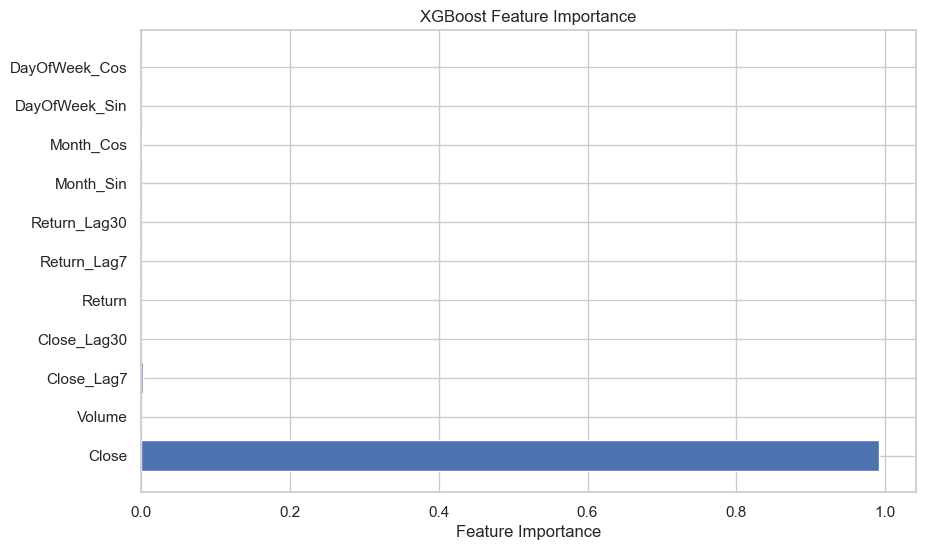

In [23]:
# Check feature importance
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

We can see that last close price dominates the feature importance. It means that XGBoost is leveraging the most recent price information heavily to make predictions. It doesn't make use of engineered features as much as we expected.

We can try to change our target variable to `Return` and see if it improves the model performance and take into account more features.

##### Predicting Returns

In [24]:
# Copy df to avoid modifying original data
df_xgb_returns = df.copy()

df_xgb_returns = df_xgb_returns[BASELINE_FEATURES]

# Create target variable as next day's Return
df_xgb_returns["target"] = df_xgb_returns["Return"].shift(-1)
df_xgb_returns["Next_Close"] = df_xgb_returns["Close"].shift(-1)
df_xgb_returns = df_xgb_returns.dropna().reset_index(drop=True)

# Split into train, validation and test set
train_df, val_df, test_df = time_series_train_val_test_split(
    df_xgb_returns, TRAIN_SIZE, VALIDATION_SIZE
)

# Separate features and target
X_train = train_df.drop(columns=["target", "Next_Close"])
y_train = train_df["target"]
X_val = val_df.drop(columns=["target", "Next_Close"])
y_val = val_df["target"]
X_test = test_df.drop(columns=["target", "Next_Close"])
y_test = test_df["target"]

# Train Model on Returns
xgb_model = xgb.XGBRegressor(random_state=RANDOM_SEED)
xgb_model.fit(X_train, y_train)

# Predict Returns
xgb_train_return_forecasts = xgb_model.predict(X_train)
xgb_val_return_forecasts = xgb_model.predict(X_val)

# Back-transform Returns to Prices
y_train_prices, xgb_train_price_forecasts = back_transform_returns_to_price(
    train_df, xgb_train_return_forecasts, "Close", "Next_Close"
)
y_val_prices, xgb_val_price_forecasts = back_transform_returns_to_price(
    val_df, xgb_val_return_forecasts, "Close", "Next_Close"
)

# Calculate Metrics
xgb_train_forecast_metrics = calculate_evaluation_metrics(
    y_train_prices, xgb_train_price_forecasts
)
print("XGBoost (Returns-Based) Evaluation Metrics on Training Set:")
for metric, value in xgb_train_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

xgb_val_forecast_metrics = calculate_evaluation_metrics(
    y_val_prices, xgb_val_price_forecasts
)

print("\nXGBoost (Returns-Based) Evaluation Metrics on Validation Set:")
for metric, value in xgb_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["XGBoost_Returns"] = {
    "model": xgb_model,
    "train_metrics": xgb_train_forecast_metrics,
    "val_metrics": xgb_val_forecast_metrics,
    "features": X_train.columns.tolist(),
    "target": "Return",
    "predictions": xgb_val_price_forecasts,
}

XGBoost (Returns-Based) Evaluation Metrics on Training Set:
MAE: 83.0471
RMSE: 171.7027
MAPE: 0.7401
Directional_Accuracy: 89.6276

XGBoost (Returns-Based) Evaluation Metrics on Validation Set:
MAE: 815.1067
RMSE: 1218.3756
MAPE: 2.4072
Directional_Accuracy: 47.8049


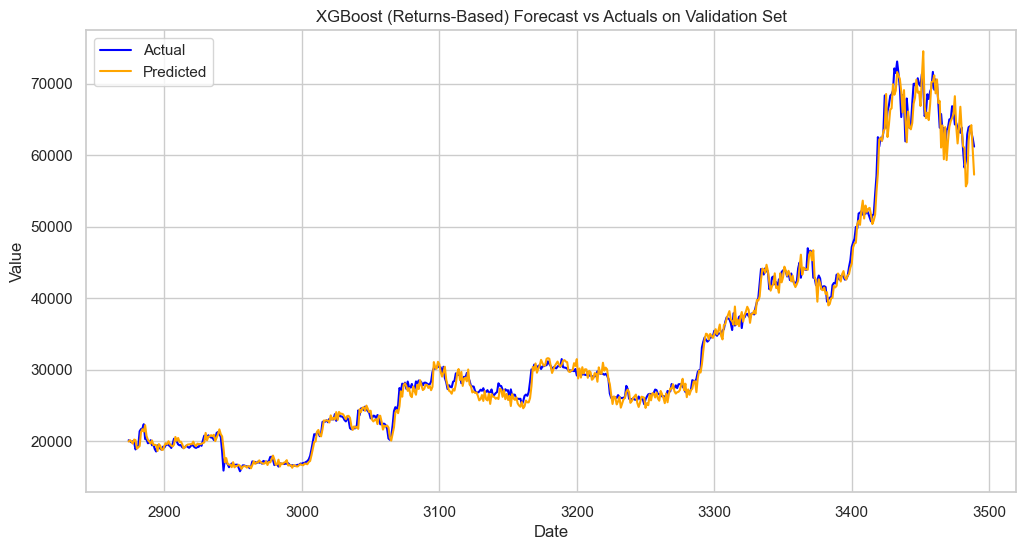

In [25]:
plot_forecasts(
    val_df.index,
    y_val_prices,
    xgb_val_price_forecasts,
    title="XGBoost (Returns-Based) Forecast vs Actuals on Validation Set",
)

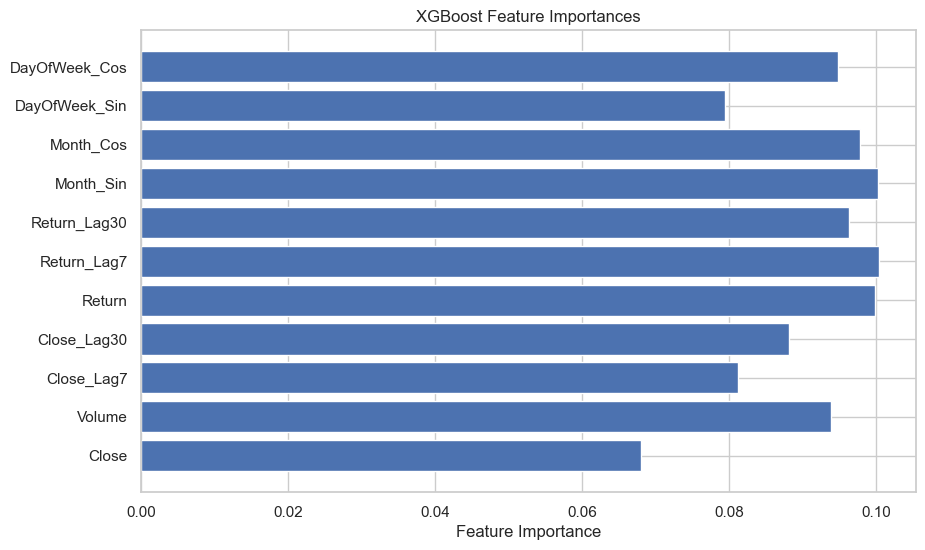

In [26]:
# Check feature importance
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()

In [27]:
unique_values, counts = np.unique(xgb_val_return_forecasts, return_counts=True)
print(f"Total forecasts: {len(xgb_val_return_forecasts)}")
print(f"Unique forecast values: {len(unique_values)}")

Total forecasts: 616
Unique forecast values: 616


We can see significant improvement in performance, however the model is still slightly worse than the rolling naive forecast. Now it treats almost all features with the similar importance. 

##### Predicting Log Returns

In [28]:
# Copy df to avoid modifying original data
df_xgb = df.copy()

df_xgb = df_xgb[BASELINE_FEATURES + ["Log_Return"]]

# Create target variable as next day's Log Return
df_xgb["target"] = df_xgb["Log_Return"].shift(-1)
df_xgb["Next_Close"] = df_xgb["Close"].shift(-1)
df_xgb = df_xgb.dropna().reset_index(drop=True)

# Split into train, validation and test set
train_df, val_df, test_df = time_series_train_val_test_split(
    df_xgb, TRAIN_SIZE, VALIDATION_SIZE
)

# Separate features and target
X_train = train_df.drop(columns=["target", "Next_Close", "Log_Return"])
y_train = train_df["target"]
X_val = val_df.drop(columns=["target", "Next_Close", "Log_Return"])
y_val = val_df["target"]
X_test = test_df.drop(columns=["target", "Next_Close", "Log_Return"])
y_test = test_df["target"]

# Train Model on Returns
xgb_model = xgb.XGBRegressor(random_state=RANDOM_SEED)
xgb_model.fit(X_train, y_train)

# Predict Returns
xgb_train_return_forecasts = xgb_model.predict(X_train)
xgb_val_return_forecasts = xgb_model.predict(X_val)

# Back-transform Returns to Prices
y_train_prices, xgb_train_price_forecasts = back_transform_returns_to_price(
    train_df, xgb_train_return_forecasts, "Close", "Next_Close", log=True
)
y_val_prices, xgb_val_price_forecasts = back_transform_returns_to_price(
    val_df, xgb_val_return_forecasts, "Close", "Next_Close", log=True
)

# Calculate Metrics
xgb_train_forecast_metrics = calculate_evaluation_metrics(
    y_train_prices, xgb_train_price_forecasts
)
print("XGBoost (Log_Returns-Based) Evaluation Metrics on Training Set:")
for metric, value in xgb_train_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

xgb_val_forecast_metrics = calculate_evaluation_metrics(
    y_val_prices, xgb_val_price_forecasts
)

print("\nXGBoost (Log_Returns-Based) Evaluation Metrics on Validation Set:")
for metric, value in xgb_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["XGBoost_Log_Returns"] = {
    "model": xgb_model,
    "train_metrics": xgb_train_forecast_metrics,
    "val_metrics": xgb_val_forecast_metrics,
    "features": X_train.columns.tolist(),
    "target": "Log_Return",
    "predictions": xgb_val_price_forecasts,
}

XGBoost (Log_Returns-Based) Evaluation Metrics on Training Set:
MAE: 92.3756
RMSE: 197.1381
MAPE: 0.7568
Directional_Accuracy: 88.8966

XGBoost (Log_Returns-Based) Evaluation Metrics on Validation Set:
MAE: 799.0162
RMSE: 1199.4232
MAPE: 2.3926
Directional_Accuracy: 48.4553


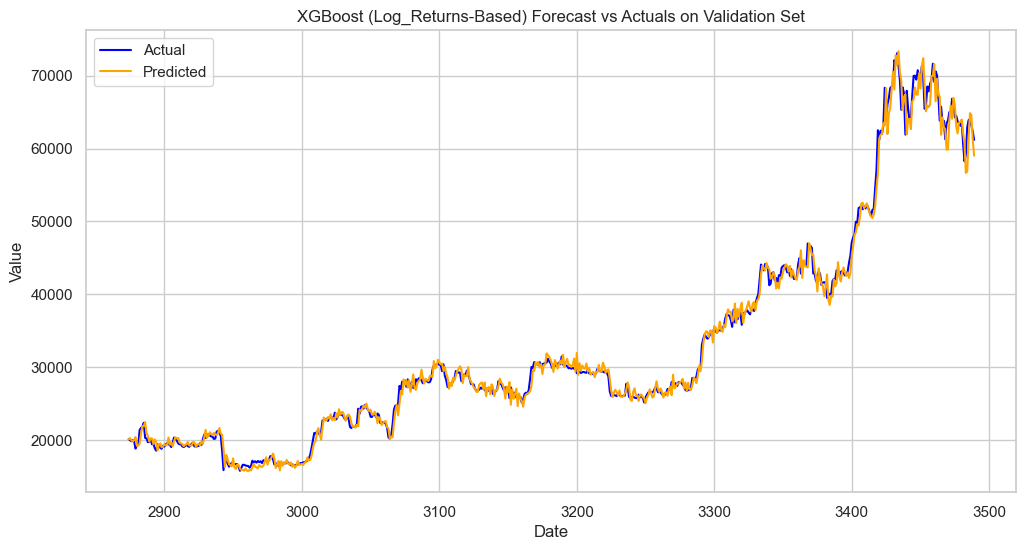

In [29]:
plot_forecasts(
    val_df.index,
    y_val_prices,
    xgb_val_price_forecasts,
    title="XGBoost (Log_Returns-Based) Forecast vs Actuals on Validation Set",
)

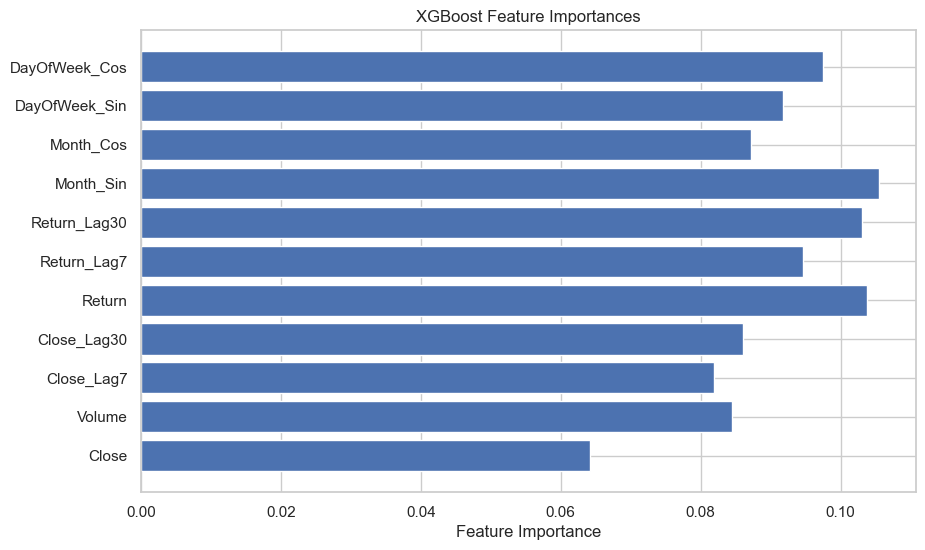

In [30]:
# Check feature importance
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()

In [31]:
unique_values, counts = np.unique(xgb_val_return_forecasts, return_counts=True)
print(f"Total forecasts: {len(xgb_val_return_forecasts)}")
print(f"Unique forecast values: {len(unique_values)}")

Total forecasts: 616
Unique forecast values: 616


The performance and importance distribution is very similar to predicting regular returns. The model doesn't seem to benefit significantly from using log returns over regular returns in this case.

##### Predicting Log Returns - All Features

In [32]:
df_xgb = df.copy()

df_xgb = df_xgb[ALL_FEATURES]

# Create target variable as next day's Log Return
df_xgb["target"] = df_xgb["Log_Return"].shift(-1)
df_xgb["Next_Close"] = df_xgb["Close"].shift(-1)
df_xgb = df_xgb.dropna().reset_index(drop=True)

# Split into train, validation and test set
train_df, val_df, test_df = time_series_train_val_test_split(
    df_xgb, TRAIN_SIZE, VALIDATION_SIZE
)

# Separate features and target
X_train = train_df.drop(columns=["target", "Next_Close", "Log_Return"])
y_train = train_df["target"]
X_val = val_df.drop(columns=["target", "Next_Close", "Log_Return"])
y_val = val_df["target"]
X_test = test_df.drop(columns=["target", "Next_Close", "Log_Return"])
y_test = test_df["target"]

# Train Model on Returns
xgb_model = xgb.XGBRegressor(random_state=RANDOM_SEED)
xgb_model.fit(X_train, y_train)

# Predict Returns
xgb_train_return_forecasts = xgb_model.predict(X_train)
xgb_val_return_forecasts = xgb_model.predict(X_val)

# Back-transform Returns to Prices
y_train_prices, xgb_train_price_forecasts = back_transform_returns_to_price(
    train_df, xgb_train_return_forecasts, "Close", "Next_Close", log=True
)
y_val_prices, xgb_val_price_forecasts = back_transform_returns_to_price(
    val_df, xgb_val_return_forecasts, "Close", "Next_Close", log=True
)

# Calculate Metrics
xgb_train_forecast_metrics = calculate_evaluation_metrics(
    y_train_prices, xgb_train_price_forecasts
)
print("XGBoost (Log_Returns-Based) Evaluation Metrics on Training Set:")
for metric, value in xgb_train_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

xgb_val_forecast_metrics = calculate_evaluation_metrics(
    y_val_prices, xgb_val_price_forecasts
)

print("\nXGBoost (Log_Returns-Based) Evaluation Metrics on Validation Set:")
for metric, value in xgb_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["XGBoost_Log_Returns_All_Features"] = {
    "model": xgb_model,
    "train_metrics": xgb_train_forecast_metrics,
    "val_metrics": xgb_val_forecast_metrics,
    "features": X_train.columns.tolist(),
    "target": "Log_Return",
    "predictions": xgb_val_price_forecasts,
}

XGBoost (Log_Returns-Based) Evaluation Metrics on Training Set:
MAE: 60.5166
RMSE: 123.2350
MAPE: 0.5120
Directional_Accuracy: 91.7160

XGBoost (Log_Returns-Based) Evaluation Metrics on Validation Set:
MAE: 857.2397
RMSE: 1308.7373
MAPE: 2.4658
Directional_Accuracy: 47.9675


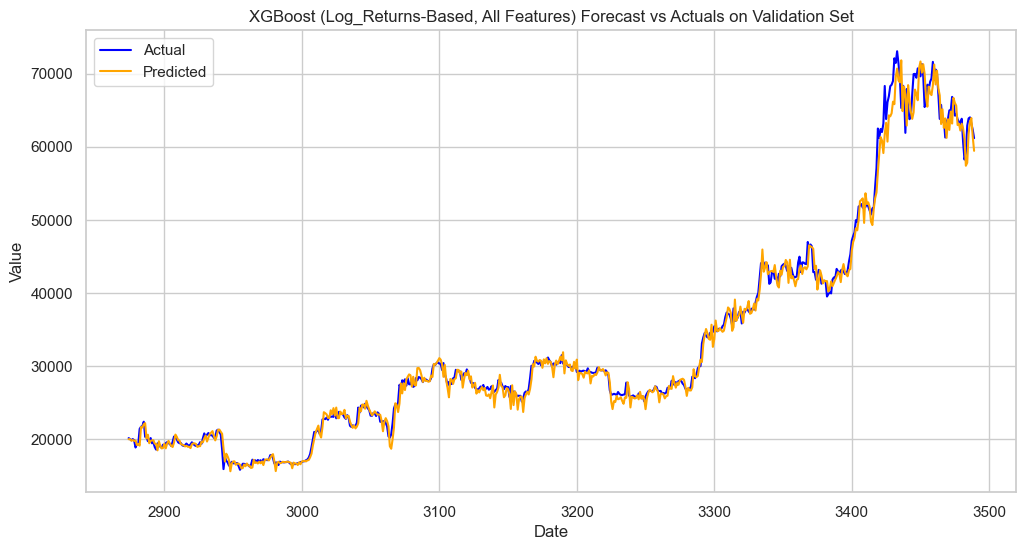

In [33]:
plot_forecasts(
    val_df.index,
    y_val_prices,
    xgb_val_price_forecasts,
    title="XGBoost (Log_Returns-Based, All Features) Forecast vs Actuals on Validation Set",
)

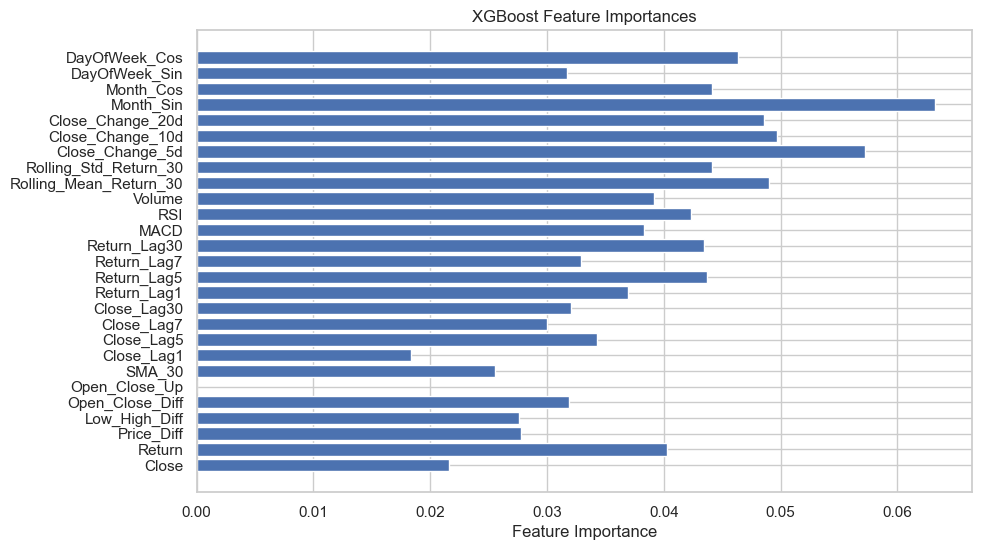

In [34]:
# Check feature importance
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()

We can see that incorporating all the features didn't improve model performance.

#### LightGBM Model

##### Predicting Close Price

In [35]:
# Copy df to avoid modifying original data
df_lgb = df.copy()

df_lgb = df_lgb[BASELINE_FEATURES]

# Create target variable by shifting 'Close' column
df_lgb["target"] = df_lgb["Close"].shift(-1)
df_lgb = df_lgb.dropna().reset_index(drop=True)

# Split into train, validation and test set
train_df, val_df, test_df = time_series_train_val_test_split(
    df_lgb, TRAIN_SIZE, VALIDATION_SIZE
)

# Separate features and target for train, validation, and test sets
X_train = train_df.drop(columns=["target"])
y_train = train_df["target"]
X_val = val_df.drop(columns=["target"])
y_val = val_df["target"]
X_test = test_df.drop(columns=["target"])
y_test = test_df["target"]

# Initialize and train LightGBM regressor
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)

lgb_model.fit(X_train, y_train)

# Predict on training and validation sets
lgb_train_forecasts = lgb_model.predict(X_train)
lgb_val_forecasts = lgb_model.predict(X_val)

# Calculate evaluation metrics
lgb_train_forecast_metrics = calculate_evaluation_metrics(y_train, lgb_train_forecasts)
print("LightGBM Model Evaluation Metrics on Training Set:")
for metric, value in lgb_train_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

lgb_val_forecast_metrics = calculate_evaluation_metrics(y_val, lgb_val_forecasts)
print("\nLightGBM Model Evaluation Metrics on Validation Set:")
for metric, value in lgb_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["LightGBM_Close"] = {
    "model": lgb_model,
    "train_metrics": lgb_train_forecast_metrics,
    "val_metrics": lgb_val_forecast_metrics,
    "features": X_train.columns.tolist(),
    "target": "Close",
    "predictions": lgb_val_forecasts,
}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2874, number of used features: 11
[LightGBM] [Info] Start training from score 12761.866984
LightGBM Model Evaluation Metrics on Training Set:
MAE: 206.8376
RMSE: 378.7183
MAPE: 2.9676
Directional_Accuracy: 64.0446

LightGBM Model Evaluation Metrics on Validation Set:
MAE: 1458.7511
RMSE: 2205.9221
MAPE: 4.1929
Directional_Accuracy: 49.1057


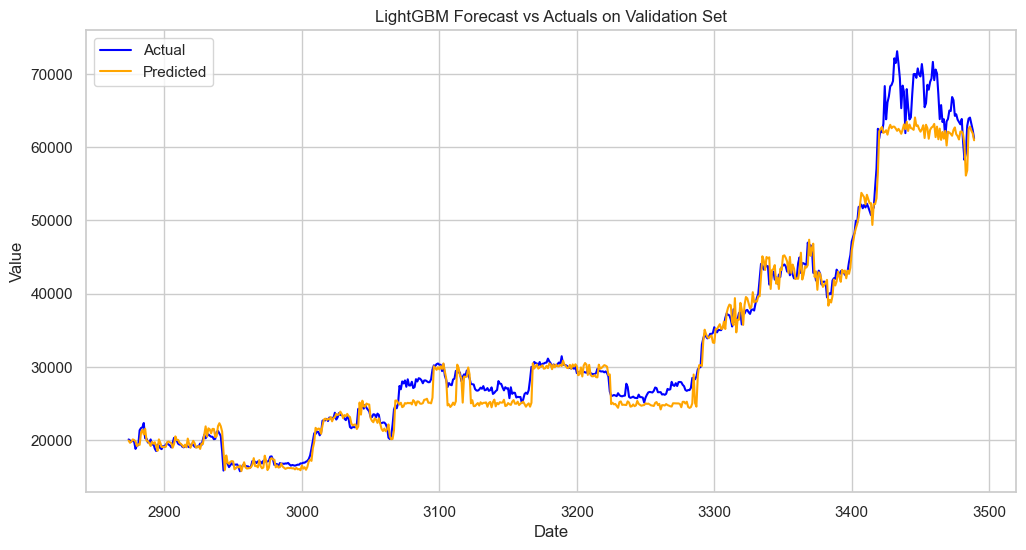

In [36]:
plot_forecasts(
    val_df.index,
    y_val,
    lgb_val_forecasts,
    title="LightGBM Forecast vs Actuals on Validation Set",
)

##### Predicting Return

In [37]:
# Copy df to avoid modifying original data
df_lgb_returns = df.copy()

df_lgb_returns = df_lgb_returns[BASELINE_FEATURES]

# Create target variable as next day's Return
df_lgb_returns["target"] = df_lgb_returns["Return"].shift(-1)
df_lgb_returns["Next_Close"] = df_lgb_returns["Close"].shift(-1)
df_lgb_returns = df_lgb_returns.dropna().reset_index(drop=True)

# Split into train, validation and test set
train_df, val_df, test_df = time_series_train_val_test_split(
    df_lgb_returns, TRAIN_SIZE, VALIDATION_SIZE
)

# Separate features and target
X_train = train_df.drop(columns=["target", "Next_Close"])
y_train = train_df["target"]
X_val = val_df.drop(columns=["target", "Next_Close"])
y_val = val_df["target"]
X_test = test_df.drop(columns=["target", "Next_Close"])
y_test = test_df["target"]

# Train Model on Returns
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

# Predict Returns
lgb_train_return_forecasts = lgb_model.predict(X_train)
lgb_val_return_forecasts = lgb_model.predict(X_val)

# Back-transform Returns to Prices
y_train_prices, lgb_train_price_forecasts = back_transform_returns_to_price(
    train_df, lgb_train_return_forecasts, "Close", "Next_Close"
)
y_val_prices, lgb_val_price_forecasts = back_transform_returns_to_price(
    val_df, lgb_val_return_forecasts, "Close", "Next_Close"
)

# Calculate Metrics
lgb_train_forecast_metrics = calculate_evaluation_metrics(
    y_train_prices, lgb_train_price_forecasts
)
print("LightGBM (Returns-Based) Evaluation Metrics on Training Set:")
for metric, value in lgb_train_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

lgb_val_forecast_metrics = calculate_evaluation_metrics(
    y_val_prices, lgb_val_price_forecasts
)

print("\nLightGBM (Returns-Based) Evaluation Metrics on Validation Set:")
for metric, value in lgb_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["LightGBM_Returns"] = {
    "model": lgb_model,
    "train_metrics": lgb_train_forecast_metrics,
    "val_metrics": lgb_val_forecast_metrics,
    "features": X_train.columns.tolist(),
    "target": "Return",
}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2874, number of used features: 11
[LightGBM] [Info] Start training from score 0.002126
LightGBM (Returns-Based) Evaluation Metrics on Training Set:
MAE: 225.3988
RMSE: 477.1781
MAPE: 1.7376
Directional_Accuracy: 76.9579

LightGBM (Returns-Based) Evaluation Metrics on Validation Set:
MAE: 705.4048
RMSE: 1126.0226
MAPE: 2.0226
Directional_Accuracy: 48.2927


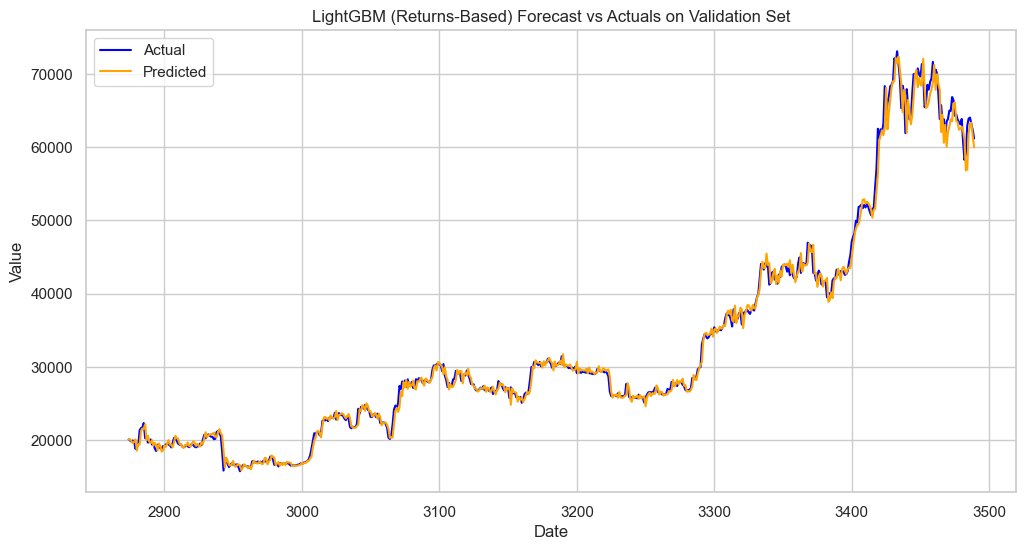

In [38]:
plot_forecasts(
    val_df.index,
    y_val_prices,
    lgb_val_price_forecasts,
    title="LightGBM (Returns-Based) Forecast vs Actuals on Validation Set",
)

##### Predicting Log Return

In [39]:
# Copy df to avoid modifying original data
df_lgb_returns = df.copy()

df_lgb_returns = df_lgb_returns[BASELINE_FEATURES + ["Log_Return"]]

# Create target variable as next day's Log Return
df_lgb_returns["target"] = df_lgb_returns["Log_Return"].shift(-1)
df_lgb_returns["Next_Close"] = df_lgb_returns["Close"].shift(-1)
df_lgb_returns = df_lgb_returns.dropna().reset_index(drop=True)

# Split into train, validation and test set
train_df, val_df, test_df = time_series_train_val_test_split(
    df_lgb_returns, TRAIN_SIZE, VALIDATION_SIZE
)

# Separate features and target
X_train = train_df.drop(columns=["target", "Next_Close"])
y_train = train_df["target"]
X_val = val_df.drop(columns=["target", "Next_Close"])
y_val = val_df["target"]
X_test = test_df.drop(columns=["target", "Next_Close"])
y_test = test_df["target"]

# Train Model on Returns
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

# Predict Returns
lgb_train_return_forecasts = lgb_model.predict(X_train)
lgb_val_return_forecasts = lgb_model.predict(X_val)

# Back-transform Returns to Prices
y_train_prices, lgb_train_price_forecasts = back_transform_returns_to_price(
    train_df, lgb_train_return_forecasts, "Close", "Next_Close", log=True
)
y_val_prices, lgb_val_price_forecasts = back_transform_returns_to_price(
    val_df, lgb_val_return_forecasts, "Close", "Next_Close", log=True
)

# Calculate Metrics
lgb_train_forecast_metrics = calculate_evaluation_metrics(
    y_train_prices, lgb_train_price_forecasts
)
print("LightGBM (Returns-Based) Evaluation Metrics on Training Set:")
for metric, value in lgb_train_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

lgb_val_forecast_metrics = calculate_evaluation_metrics(
    y_val_prices, lgb_val_price_forecasts
)

print("\nLightGBM (Returns-Based) Evaluation Metrics on Validation Set:")
for metric, value in lgb_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["LightGBM_Log_Returns"] = {
    "model": lgb_model,
    "train_metrics": lgb_train_forecast_metrics,
    "val_metrics": lgb_val_forecast_metrics,
    "features": X_train.columns.tolist(),
    "target": "Log_Return",
}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 2874, number of used features: 12
[LightGBM] [Info] Start training from score 0.001370
LightGBM (Returns-Based) Evaluation Metrics on Training Set:
MAE: 223.6115
RMSE: 477.8455
MAPE: 1.7235
Directional_Accuracy: 76.0529

LightGBM (Returns-Based) Evaluation Metrics on Validation Set:
MAE: 710.4448
RMSE: 1134.3038
MAPE: 2.0441
Directional_Accuracy: 49.2683


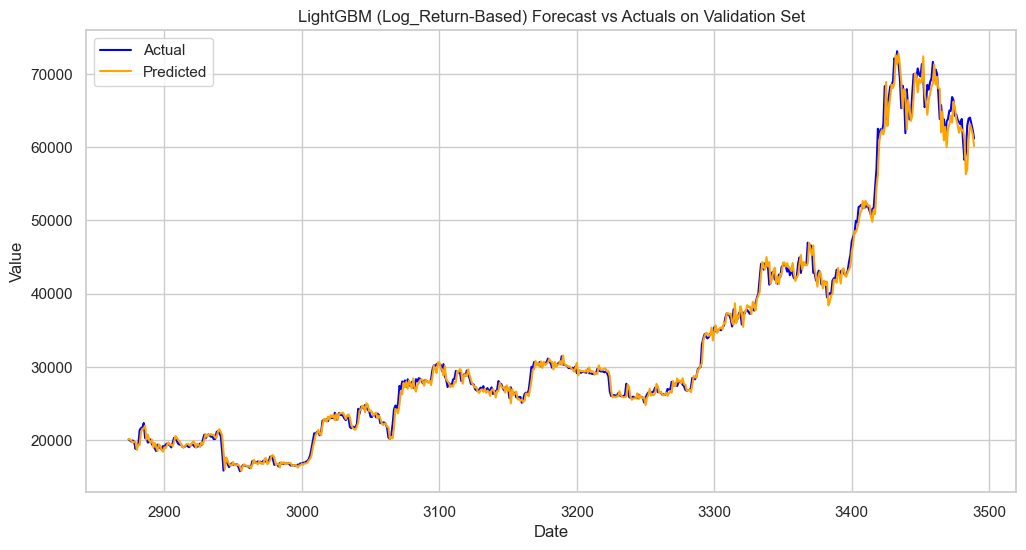

In [40]:
plot_forecasts(
    val_df.index,
    y_val_prices,
    lgb_val_price_forecasts,
    title="LightGBM (Log_Return-Based) Forecast vs Actuals on Validation Set",
)

##### Predicting Log Returns - With Additional Features

In [41]:
# Copy df to avoid modifying original data
df_lgb_returns = df.copy()

df_lgb_returns = df_lgb_returns[ALL_FEATURES]

# Create target variable as next day's Log Return
df_lgb_returns["target"] = df_lgb_returns["Log_Return"].shift(-1)
df_lgb_returns["Next_Close"] = df_lgb_returns["Close"].shift(-1)
df_lgb_returns = df_lgb_returns.dropna().reset_index(drop=True)

# Split into train, validation and test set
train_df, val_df, test_df = time_series_train_val_test_split(
    df_lgb_returns, TRAIN_SIZE, VALIDATION_SIZE
)

# Separate features and target
X_train = train_df.drop(columns=["target", "Next_Close"])
y_train = train_df["target"]
X_val = val_df.drop(columns=["target", "Next_Close"])
y_val = val_df["target"]
X_test = test_df.drop(columns=["target", "Next_Close"])
y_test = test_df["target"]

# Train Model on Returns
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

# Predict Returns
lgb_train_return_forecasts = lgb_model.predict(X_train)
lgb_val_return_forecasts = lgb_model.predict(X_val)

# Back-transform Returns to Prices
y_train_prices, lgb_train_price_forecasts = back_transform_returns_to_price(
    train_df, lgb_train_return_forecasts, "Close", "Next_Close", log=True
)
y_val_prices, lgb_val_price_forecasts = back_transform_returns_to_price(
    val_df, lgb_val_return_forecasts, "Close", "Next_Close", log=True
)

# Calculate Metrics
lgb_train_forecast_metrics = calculate_evaluation_metrics(
    y_train_prices, lgb_train_price_forecasts
)
print("LightGBM (Returns-Based) Evaluation Metrics on Training Set:")
for metric, value in lgb_train_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

lgb_val_forecast_metrics = calculate_evaluation_metrics(
    y_val_prices, lgb_val_price_forecasts
)
print("\nLightGBM (Returns-Based) Evaluation Metrics on Validation Set:")
for metric, value in lgb_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["LightGBM_Log_Returns_All_Features"] = {
    "model": lgb_model,
    "metrics": lgb_val_forecast_metrics,
    "features": X_train.columns.tolist(),
    "target": "Log_Return",
}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5903
[LightGBM] [Info] Number of data points in the train set: 2874, number of used features: 28
[LightGBM] [Info] Start training from score 0.001370
LightGBM (Returns-Based) Evaluation Metrics on Training Set:
MAE: 181.8143
RMSE: 391.2996
MAPE: 1.4051
Directional_Accuracy: 81.1347

LightGBM (Returns-Based) Evaluation Metrics on Validation Set:
MAE: 675.3480
RMSE: 1072.1091
MAPE: 1.9625
Directional_Accuracy: 48.7805


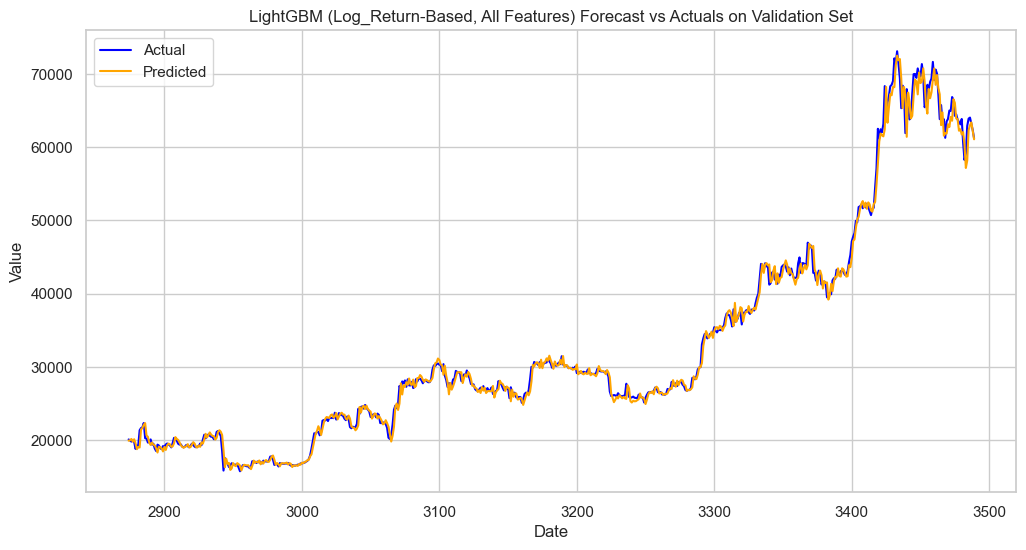

In [42]:
plot_forecasts(
    val_df.index,
    y_val_prices,
    lgb_val_price_forecasts,
    title="LightGBM (Log_Return-Based, All Features) Forecast vs Actuals on Validation Set",
)

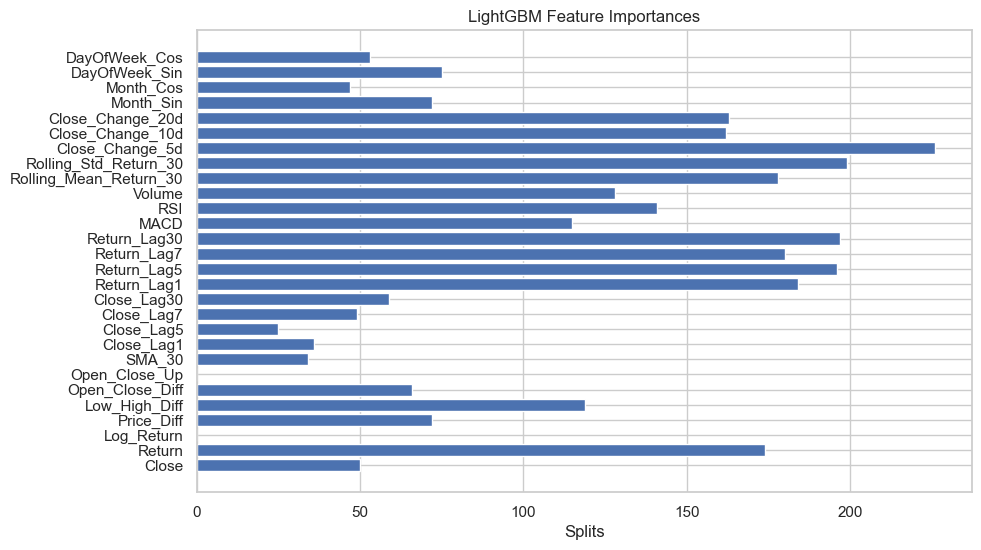

In [43]:
# Feature importance

# Check feature importance
feature_importances = lgb_model.feature_importances_
feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.title("LightGBM Feature Importances")
plt.xlabel("Splits")
plt.show()

We can see that for LightGBM adding additional features improved the model performance slightly. It is better than XGBoost with additional features, but still slightly worse than the rolling naive forecast.

### 1.4 Other Time Series Models

#### Exponential Smoothing (ETS)

For exponential smoothing, we can use the `statsmodels` library which provides an easy-to-use implementation of ETS models. 

There are three main types of exponential smoothing models:
- **Simple or Single Exponential Smoothing**: Suitable for data without trend or seasonality.
- **Double Exponential Smoothing (Holt’s Linear Trend Model)**: Extends SES to capture linear trends in the data.
- **Triple Exponential Smoothing (Holt-Winters Seasonal Model)**: Further extends Holt’s model to account for seasonality.

##### Simple Exponential Smoothing - Predicting Close Price

In [44]:
es_df = df.copy()

es_df["Next_Close"] = es_df["Close"].shift(-1)
es_df = es_df.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    es_df, TRAIN_SIZE, VALIDATION_SIZE
)

In [45]:
model = ExponentialSmoothing(train_df["Close"], trend=None, seasonal=None)

ses_model = model.fit()

ses_val_forecasts = ses_model.forecast(len(val_df))

ses_val_forecast_metrics = calculate_evaluation_metrics(
    val_df["Close"], ses_val_forecasts
)
print("\nSimple Exponential Smoothing Model Evaluation Metrics on Validation Set:")
for metric, value in ses_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")
MODEL_RESULTS["Simple Exponential Smoothing"] = {
    "model": ses_model,
    "metrics": ses_val_forecast_metrics,
    "target": "Close",
    "predictions": ses_val_forecasts,
}


Simple Exponential Smoothing Model Evaluation Metrics on Validation Set:
MAE: 13508.2722
RMSE: 19512.5510
MAPE: 32.7161
Directional_Accuracy: 50.8943


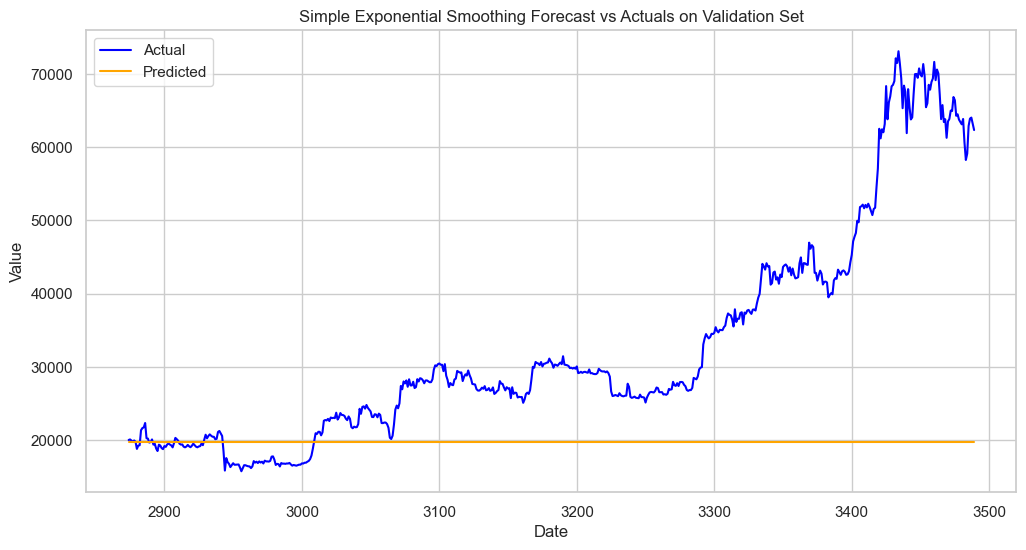

In [46]:
plot_forecasts(
    val_df.index,
    val_df["Close"],
    ses_val_forecasts,
    title="Simple Exponential Smoothing Forecast vs Actuals on Validation Set",
)

For Exponential Smoothing, similarly to ARIMA, we can see that predicting close price directly does not work well due to non-stationarity. The RMSE and MAE are quite high, indicating large prediction errors.

##### Simple Exponential Smoothing - Predicting Returns

In [47]:
model = ExponentialSmoothing(train_df["Return"], trend=None, seasonal=None)

ses_model = model.fit()

ses_val_forecasts = ses_model.forecast(len(val_df))

# Back-transform Returns to Prices
y_val_prices, ses_val_price_forecasts = back_transform_returns_to_price(
    val_df, ses_val_forecasts, "Close", "Next_Close"
)


ses_val_forecast_metrics = calculate_evaluation_metrics(
    y_val_prices, ses_val_price_forecasts
)
print(
    "\nSimple Exponential Smoothing (Returns-Based) Model Evaluation Metrics on Validation Set:"
)
for metric, value in ses_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")
MODEL_RESULTS["Simple_Exponential_Smoothing_Returns"] = {
    "model": ses_model,
    "metrics": ses_val_forecast_metrics,
    "target": "Return",
    "predictions": ses_val_price_forecasts,
}


Simple Exponential Smoothing (Returns-Based) Model Evaluation Metrics on Validation Set:
MAE: 603.9201
RMSE: 1018.6282
MAPE: 1.7245
Directional_Accuracy: 50.2439


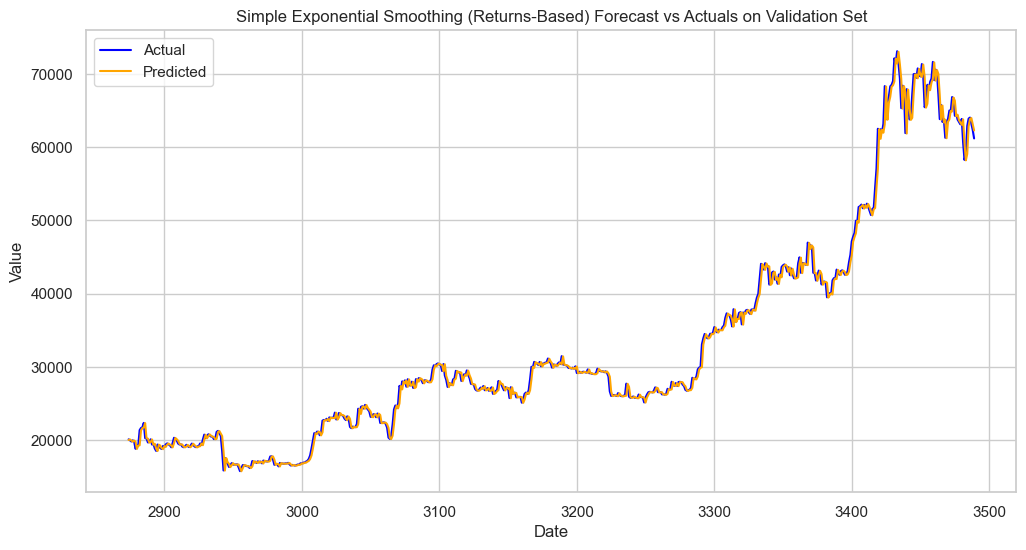

In [48]:
plot_forecasts(
    val_df.index,
    y_val_prices,
    ses_val_price_forecasts,
    title="Simple Exponential Smoothing (Returns-Based) Forecast vs Actuals on Validation Set",
)

In [49]:
# Count how many times each unique forecast value appears
unique_values, counts = np.unique(ses_val_forecasts, return_counts=True)

print(f"Total forecasts: {len(ses_val_forecasts)}")
print(f"Unique forecast values: {len(unique_values)}")
print("The only unique forecast values are:")
for value in unique_values:
    print(f"Value: {value:.8f}")

Total forecasts: 616
Unique forecast values: 1
The only unique forecast values are:
Value: -0.00099901


Similarly to ARIMA, predicting returns improves performance significantly. However, it predicts always the same value (close to 0), but this time negative, which is not very useful. There is no point in trying log returns as the result will be the same.

##### Double Exponential Smoothing (Holt’s Linear Trend Model) - Predicting Returns

In [50]:
model = ExponentialSmoothing(train_df["Return"], trend="add", seasonal=None)

des_model = model.fit()

des_val_forecasts = des_model.forecast(len(val_df))

# Back-transform Returns to Prices
y_val_prices, des_val_price_forecasts = back_transform_returns_to_price(
    val_df, des_val_forecasts, "Close", "Next_Close", log=True
)

# Calculate Metrics
des_val_forecast_metrics = calculate_evaluation_metrics(
    y_val_prices, des_val_price_forecasts
)
print(
    "\nDouble Exponential Smoothing (Returns-Based) Model Evaluation Metrics on Validation Set:"
)
for metric, value in des_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")
MODEL_RESULTS["Double_Exponential_Smoothing_Returns"] = {
    "model": des_model,
    "metrics": des_val_forecast_metrics,
    "target": "Returns",
    "predictions": des_val_price_forecasts,
}


Double Exponential Smoothing (Returns-Based) Model Evaluation Metrics on Validation Set:
MAE: 603.1783
RMSE: 1014.3022
MAPE: 1.7282
Directional_Accuracy: 49.7561


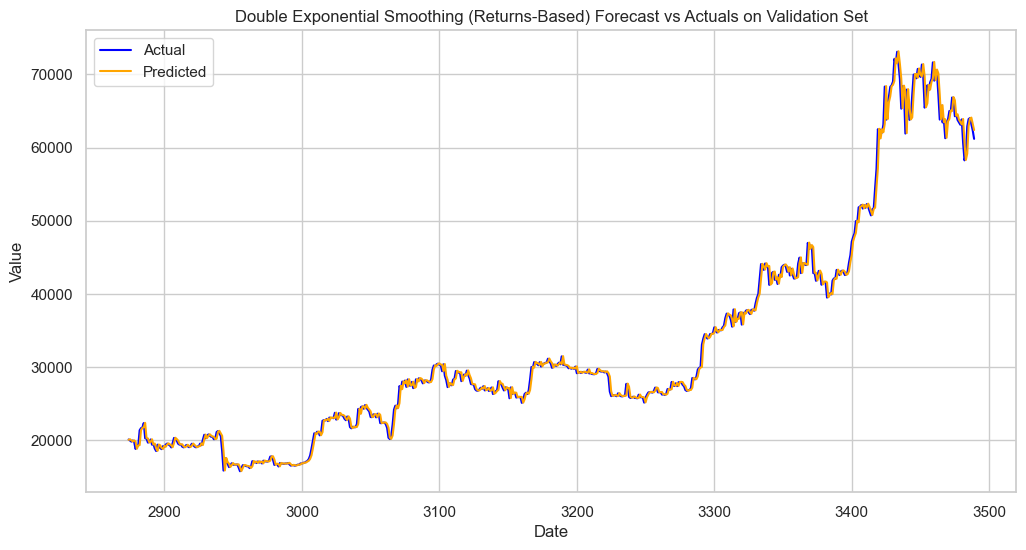

In [51]:
plot_forecasts(
    val_df.index,
    y_val_prices,
    des_val_price_forecasts,
    title="Double Exponential Smoothing (Returns-Based) Forecast vs Actuals on Validation Set",
)

In [52]:
# Count how many times each unique forecast value appears
unique_values, counts = np.unique(des_val_forecasts, return_counts=True)

print(f"Total forecasts: {len(des_val_forecasts)}")
print(f"Unique forecast values: {len(unique_values)}")
print("The only unique forecast values are:")

i = 0

for value in unique_values:
    print(f"Value: {value:.8f}")
    i += 1
    if i >= 10:
        break

Total forecasts: 616
Unique forecast values: 616
The only unique forecast values are:
Value: 0.00091654
Value: 0.00091714
Value: 0.00091773
Value: 0.00091832
Value: 0.00091891
Value: 0.00091951
Value: 0.00092010
Value: 0.00092069
Value: 0.00092129
Value: 0.00092188


We can see that Double Exponential Smoothing on returns performs better than Simple Exponential Smoothing and Rolling Naive Forecast slightly. It doesn't return the same number all the time, however the improvement is marginal.

##### Triple Exponential Smoothing (Holt-Winters Seasonal Model) - Predicting Return

In [53]:
model = ExponentialSmoothing(
    train_df["Return"], trend="add", seasonal="add", seasonal_periods=12
)  # seasonal_periods set to 12 for monthly data

tes_model = model.fit()

tes_val_forecasts = tes_model.forecast(len(val_df))

# Back-transform Returns to Prices
y_val_prices, tes_val_price_forecasts = back_transform_returns_to_price(
    val_df, tes_val_forecasts, "Close", "Next_Close"
)

# Calculate Metrics
tes_val_forecast_metrics = calculate_evaluation_metrics(
    y_val_prices, tes_val_price_forecasts
)
print(
    "\nTriple Exponential Smoothing (Returns-Based) Model Evaluation Metrics on Validation Set:"
)
for metric, value in tes_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")
MODEL_RESULTS["Triple_Exponential_Smoothing_Returns"] = {
    "model": tes_model,
    "metrics": tes_val_forecast_metrics,
    "target": "Return",
    "predictions": tes_val_price_forecasts,
}


Triple Exponential Smoothing (Returns-Based) Model Evaluation Metrics on Validation Set:
MAE: 606.7593
RMSE: 1021.5834
MAPE: 1.7435
Directional_Accuracy: 50.8943


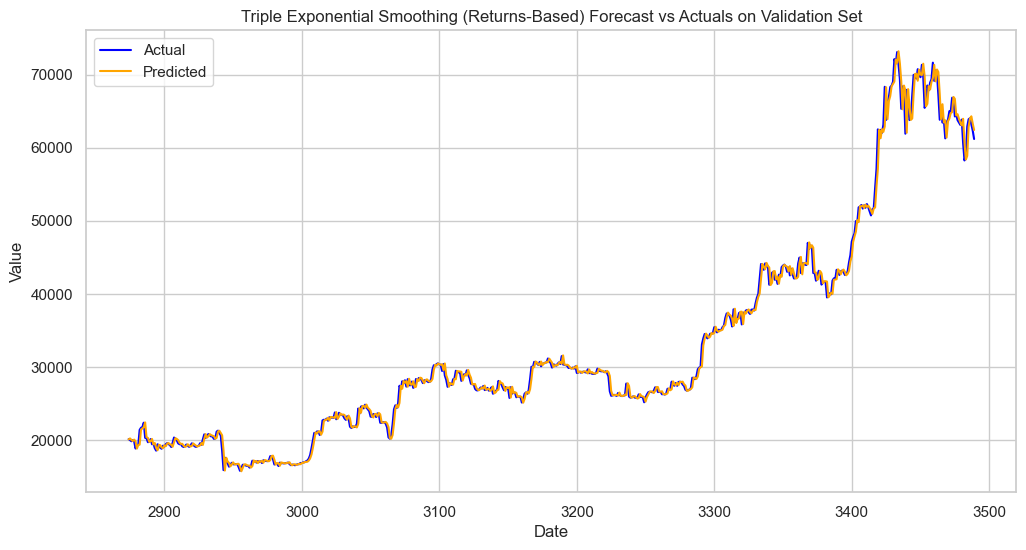

In [54]:
plot_forecasts(
    val_df.index,
    y_val_prices,
    tes_val_price_forecasts,
    title="Triple Exponential Smoothing (Returns-Based) Forecast vs Actuals on Validation Set",
)

Triple Exponential Smoothing does not improve performance over Double Exponential Smoothing. The RMSE and MAE are slightly higher, indicating that adding seasonality did not help capture the underlying patterns in Bitcoin returns better than just modeling the trend.

#### GARCH Model 

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models are particularly useful for modeling and forecasting the volatility of financial time series data, such as cryptocurrency returns. They help capture the changing variance over time, which is a common characteristic in financial markets.

In [55]:
garch_df = df.copy()
garch_df["Next_Close"] = garch_df["Close"].shift(-1)
garch_df = garch_df.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    garch_df, TRAIN_SIZE, VALIDATION_SIZE
)

train_df["Return_100"] = (
    train_df["Return"] * 100
)  # Scale returns for better model fitting

garch_model = arch_model(train_df["Return_100"], vol="GARCH", p=1, q=1, dist="normal")

garch_fitted = garch_model.fit()

n_periods = len(val_df)

garch_forecasts = garch_fitted.forecast(horizon=n_periods)

# Get forecasted returns
garch_mean_forecasts = (garch_forecasts.mean.values[-1, :]) / 100  # Scale back

# Back-transform Returns to Prices
y_val_prices, garch_price_forecasts = back_transform_returns_to_price(
    val_df, garch_mean_forecasts, "Close", "Next_Close"
)

# Calculate Metrics
garch_val_forecast_metrics = calculate_evaluation_metrics(
    y_val_prices, garch_price_forecasts
)
print("\nGARCH Model Evaluation Metrics on Validation Set:")
for metric, value in garch_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["GARCH_Returns"] = {
    "model": garch_fitted,
    "metrics": garch_val_forecast_metrics,
    "target": "Return",
    "predictions": garch_price_forecasts,
}

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1924115.9180570957
Iteration:      2,   Func. Count:     13,   Neg. LLF: 10007.628108242952
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7983.2160303372475
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7763.251933882031
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1073927520.6893349
Iteration:      6,   Func. Count:     38,   Neg. LLF: 8452.941235942693
Iteration:      7,   Func. Count:     44,   Neg. LLF: 7765.438669975882
Iteration:      8,   Func. Count:     50,   Neg. LLF: 7742.811118864991
Iteration:      9,   Func. Count:     55,   Neg. LLF: 7742.772535243897
Iteration:     10,   Func. Count:     60,   Neg. LLF: 7742.77191421195
Iteration:     11,   Func. Count:     65,   Neg. LLF: 7742.77190579852
Iteration:     12,   Func. Count:     70,   Neg. LLF: 7742.771904787522
Iteration:     13,   Func. Count:     74,   Neg. LLF: 7742.771904787573
Optimization terminated successfully    (Exit mode 0)
        

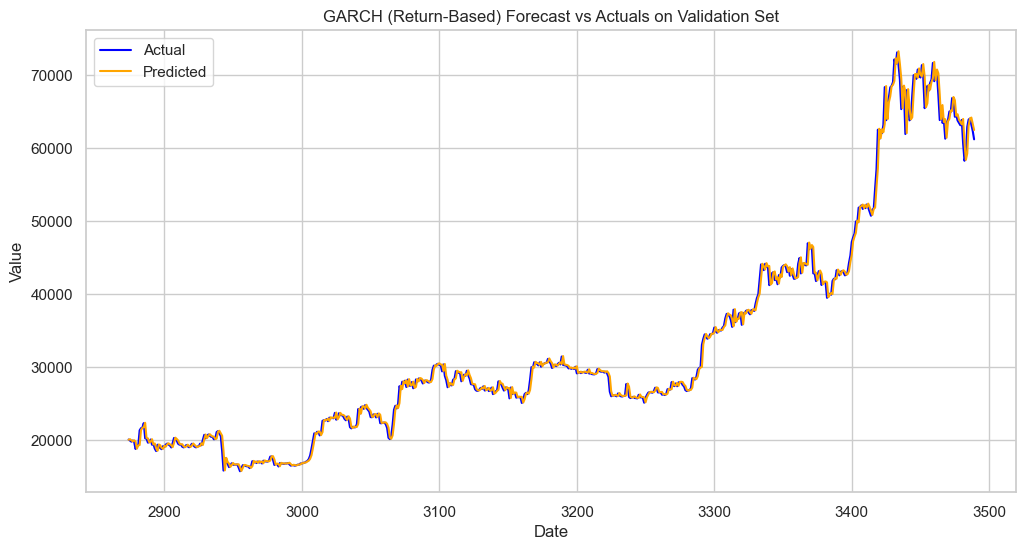

In [56]:
plot_forecasts(
    val_df.index,
    y_val_prices,
    garch_price_forecasts,
    title="GARCH (Return-Based) Forecast vs Actuals on Validation Set",
)

In [57]:
unique_values, counts = np.unique(garch_mean_forecasts, return_counts=True)
for val, count in zip(unique_values, counts):
    print(f"Value: {val}, Count: {count}")

Value: 0.002063295192298306, Count: 616


GARCH similarly as ARIMA always predicts the same small value (close to 0) and is a bit better than Rolling Naive Forecast.

#### Prophet Model

Prophet is a forecasting tool developed by Facebook that is designed to handle time series data with strong seasonal effects and several seasons of historical data. It is robust to missing data and shifts in the trend, making it suitable for various real-world applications. Prophet decomposes time series data into three main components: trend, seasonality, and holidays. This allows it to model complex patterns and make accurate forecasts even in the presence of missing or irregular data.

##### Predicting Close Price

In [58]:
df_prophet = df[["Close"]].copy()

df_prophet = df_prophet.reset_index().rename(columns={"index": "Date"})

df_prophet = df_prophet.rename(columns={"Date": "ds", "Close": "y"})

train_df, val_df, test_df = time_series_train_val_test_split(
    df_prophet, TRAIN_SIZE, VALIDATION_SIZE
)

prophet_model = Prophet()
prophet_model.fit(train_df)

n_periods = len(val_df)
future_val = prophet_model.make_future_dataframe(periods=n_periods, freq="D")

prophet_val_forecasts = prophet_model.predict(future_val)

# Key columns in the forecast output:
# 'yhat' - the predicted value
# 'yhat_lower' / 'yhat_upper' - uncertainty intervals
print(prophet_val_forecasts[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail())
print(len(prophet_val_forecasts), len(val_df))

# Extract yhat for the validation period
prophet_val_forecasts_values = prophet_val_forecasts["yhat"][-n_periods:].values
print(len(prophet_val_forecasts_values), len(val_df))

# Calculate Metrics
prophet_val_forecast_metrics = calculate_evaluation_metrics(
    val_df["y"], prophet_val_forecasts_values
)
print("\nProphet Model Evaluation Metrics on Validation Set:")
for metric, value in prophet_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")
MODEL_RESULTS["Prophet_Close"] = {
    "model": prophet_model,
    "metrics": prophet_val_forecast_metrics,
    "target": "Close",
    "predictions": prophet_val_forecasts_values,
}

11:50:27 - cmdstanpy - INFO - Chain [1] start processing
11:50:27 - cmdstanpy - INFO - Chain [1] done processing


             ds          yhat    yhat_lower    yhat_upper
3485 2024-05-03  19091.978565 -22213.806637  59014.893856
3486 2024-05-04  19002.396547 -22801.771589  60731.283623
3487 2024-05-05  18880.105375 -23238.373359  59047.831115
3488 2024-05-06  18770.821599 -23449.882674  60223.772305
3489 2024-05-07  18621.839308 -22967.864481  60437.071844
3490 616
616 616

Prophet Model Evaluation Metrics on Validation Set:
MAE: 14344.0785
RMSE: 19769.1237
MAPE: 41.6882
Directional_Accuracy: 48.7805


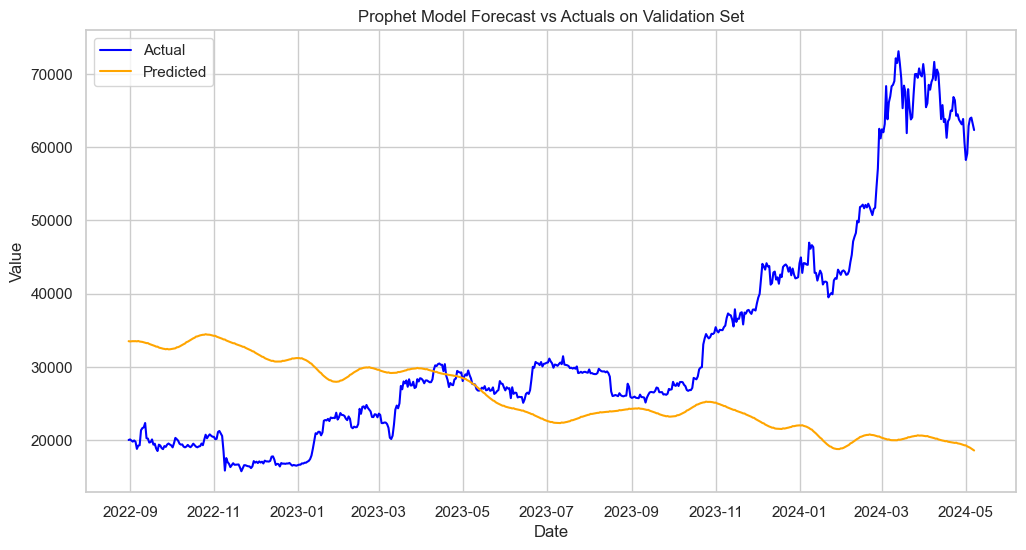

In [59]:
plot_forecasts(
    val_df["ds"],
    val_df["y"],
    prophet_val_forecasts_values,
    title="Prophet Model Forecast vs Actuals on Validation Set",
)

We can see that Prophet trying to predict close price directly does not perform well due to non-stationarity. The forecasted values are quite far from the actual prices, leading to high RMSE and MAE values.

##### Predicting Returns

In [60]:
df_prophet = df[["Close", "Return"]].copy()

df_prophet = df_prophet.reset_index().rename(columns={"index": "Date"})

df_prophet["Next_Close"] = df_prophet["Close"].shift(-1)
df_prophet = df_prophet.dropna().reset_index(drop=True)

df_prophet = df_prophet.rename(columns={"Date": "ds", "Return": "y"})

train_df, val_df, test_df = time_series_train_val_test_split(
    df_prophet, TRAIN_SIZE, VALIDATION_SIZE
)

prophet_model = Prophet()
prophet_model.fit(train_df)

n_periods = len(val_df)
future_val = prophet_model.make_future_dataframe(periods=n_periods, freq="D")

prophet_val_forecasts = prophet_model.predict(future_val)

# Extract yhat for the validation period
prophet_val_forecasts_returns = prophet_val_forecasts["yhat"][-n_periods:]

# Transform predicted returns back to prices
val_df_prices, prophet_val_forecasts_values = back_transform_returns_to_price(
    val_df, prophet_val_forecasts_returns, "Close", "Next_Close"
)

print(len(prophet_val_forecasts_values), len(val_df))

# Calculate Metrics
prophet_val_forecast_metrics = calculate_evaluation_metrics(
    val_df_prices, prophet_val_forecasts_values
)
print("\nProphet Model Evaluation Metrics on Validation Set:")
for metric, value in prophet_val_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")
MODEL_RESULTS["Prophet_Close"] = {
    "model": prophet_model,
    "metrics": prophet_val_forecast_metrics,
    "target": "Return",
    "predictions": prophet_val_forecasts_values,
}

11:50:28 - cmdstanpy - INFO - Chain [1] start processing
11:50:28 - cmdstanpy - INFO - Chain [1] done processing


616 616

Prophet Model Evaluation Metrics on Validation Set:
MAE: 630.6268
RMSE: 1055.0857
MAPE: 1.8017
Directional_Accuracy: 52.8455


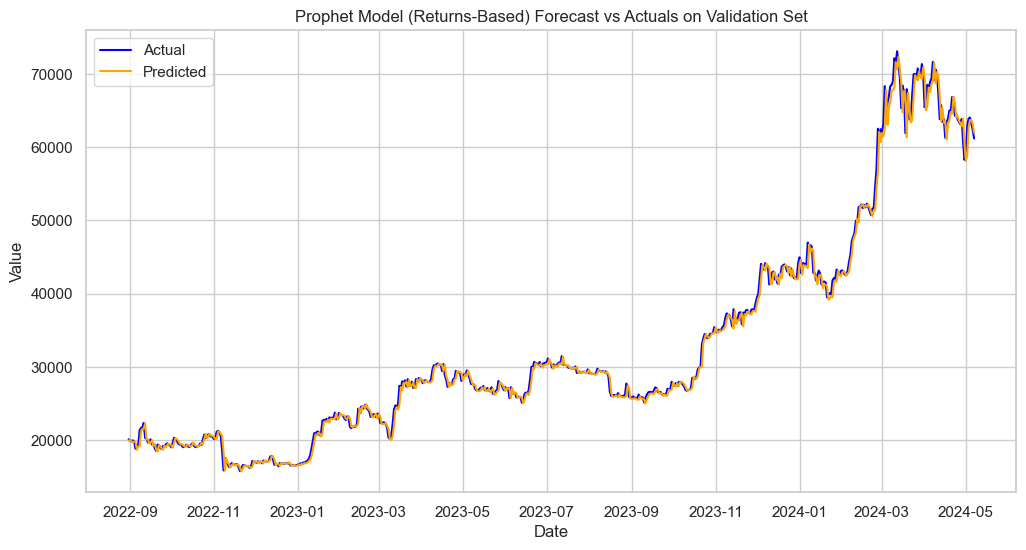

In [61]:
plot_forecasts(
    val_df["ds"],
    val_df_prices,
    prophet_val_forecasts_values,
    title="Prophet Model (Returns-Based) Forecast vs Actuals on Validation Set",
)

In [62]:
unique_values, counts = np.unique(prophet_val_forecasts_returns, return_counts=True)

i = 0

for val, count in zip(unique_values, counts):
    print(f"Value: {val}, Count: {count}")
    i += 1
    if i >= 10:
        break

Value: -0.01324275714458727, Count: 1
Value: -0.013111369458720826, Count: 1
Value: -0.013014774066418888, Count: 1
Value: -0.012639180627670542, Count: 1
Value: -0.012562893607927117, Count: 1
Value: -0.012220324065881479, Count: 1
Value: -0.012022144787323684, Count: 1
Value: -0.011887702918021058, Count: 1
Value: -0.011856958592351245, Count: 1
Value: -0.011620479966134217, Count: 1


In [63]:
negative_preds = [pred for pred in prophet_val_forecasts_returns if pred < 0]
positive_preds = [pred for pred in prophet_val_forecasts_returns if pred >= 0]
print(f"Number of negative return predictions: {len(negative_preds)})")
print(f"Number of positive return predictions: {len(positive_preds)})")

Number of negative return predictions: 504)
Number of positive return predictions: 112)


Prophet forecasting returns shows improvement over predicting close prices and its RMSE is slighthly worse than Rolling Naive Forecast. However, in oppsoity to ARIMA and ETS, it does not predict the same value all the time. It produces a range of return predictions, some positive and some negative. Directional accuracy is also better than any previous model.

### 1.5 Deep Learning Models

#### LSTM Model

LSTM is a type of recurrent neural network (RNN) that is well-suited for modeling sequential data, such as time series. It is capable of capturing long-term dependencies and patterns in the data through its gated memory cells. 

In [64]:
# Constants and Hyperparameters
SEQUENCE_LENGTH = 30
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2
EPOCHS = 100
BATCH_SIZE = 32
LR = 1e-3

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

For deep learning models like LSTM, it is important to scale the values before the training.

Generally, LSTM models prefer to work with data in ranges like 0 to 1 or -1 to 1. This is because LSTMs use activation functions (like sigmoid and tanh) that can saturate when input values are too large, leading to vanishing gradients and poor learning. Scaling the data helps ensure that the model can learn effectively and converge faster during training. For that reason, it is common to use MinMaxScaler to scale the close prices between 0 and 1 before training an LSTM model. This allows the model to learn more efficiently and make better predictions on the scaled data. After making predictions, we can back-transform the scaled values to the original price levels for evaluation.

##### Predicting Close Price

In [65]:
df_lstm = df.copy()
df_lstm = df_lstm[BASELINE_FEATURES]
df_lstm["target"] = df_lstm["Close"].shift(-1)
df_lstm["Next_Close"] = df_lstm["Close"].shift(-1)
df_lstm = df_lstm.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    df_lstm, TRAIN_SIZE, VALIDATION_SIZE
)

drop_cols = ["target", "Next_Close"]

X_train = train_df.drop(columns=drop_cols).values
y_train = train_df["target"].values
X_val = val_df.drop(columns=drop_cols).values
y_val = val_df["target"].values

# Scale features
sc_X = MinMaxScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_val_scaled = sc_X.transform(X_val)

# Scale the target variable
sc_y = MinMaxScaler()
y_train_scaled = sc_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = sc_y.transform(y_val.reshape(-1, 1)).flatten()

In [66]:
# Create datasets and loaders

train_dataset = SequenceDataset(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
val_dataset = SequenceDataset(X_val_scaled, y_val_scaled, SEQUENCE_LENGTH)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

print(f"Train sequences: {len(train_dataset)}")
print(f"Val sequences: {len(val_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

# Test it works
for X_batch, y_batch in train_loader:
    print(f"\nFirst batch shapes:")
    print(f"X_batch: {X_batch.shape}")
    print(f"y_batch: {y_batch.shape}")
    break

Train sequences: 2844
Val sequences: 586
Batches per epoch: 89

First batch shapes:
X_batch: torch.Size([32, 30, 11])
y_batch: torch.Size([32, 1])


In [67]:
sample_batch_X, _ = next(iter(train_loader))
input_size = sample_batch_X.shape[2]

result = train_nn_model(
    "LSTM",
    train_loader,
    val_loader,
    input_size,
    HIDDEN_SIZE,
    NUM_LAYERS,
    DROPOUT,
    LR,
    EPOCHS,
)

# Extract trained model and device from results
model = result["model"]
device = result["device"]
history = result["history"]

Using device: mps
Model parameters: 53,057

Starting training for 100 epochs...
Epoch 20/100
  Train Loss: 0.004113 | Val Loss: 0.021123
  Train RMSE: 0.064153 | Val RMSE: 0.108485
  Train MAE: 0.045540 | Val MAE: 0.069903
Epoch 40/100
  Train Loss: 0.003091 | Val Loss: 0.018985
  Train RMSE: 0.055623 | Val RMSE: 0.099681
  Train MAE: 0.039310 | Val MAE: 0.064514
Epoch 60/100
  Train Loss: 0.002037 | Val Loss: 0.012863
  Train RMSE: 0.045151 | Val RMSE: 0.081822
  Train MAE: 0.034014 | Val MAE: 0.053573
Epoch 80/100
  Train Loss: 0.001278 | Val Loss: 0.012851
  Train RMSE: 0.035763 | Val RMSE: 0.082295
  Train MAE: 0.025315 | Val MAE: 0.054208
Epoch 100/100
  Train Loss: 0.003071 | Val Loss: 0.016341
  Train RMSE: 0.055443 | Val RMSE: 0.103452
  Train MAE: 0.033984 | Val MAE: 0.072202
Training complete!
Best validation loss: 0.010471 at epoch 94


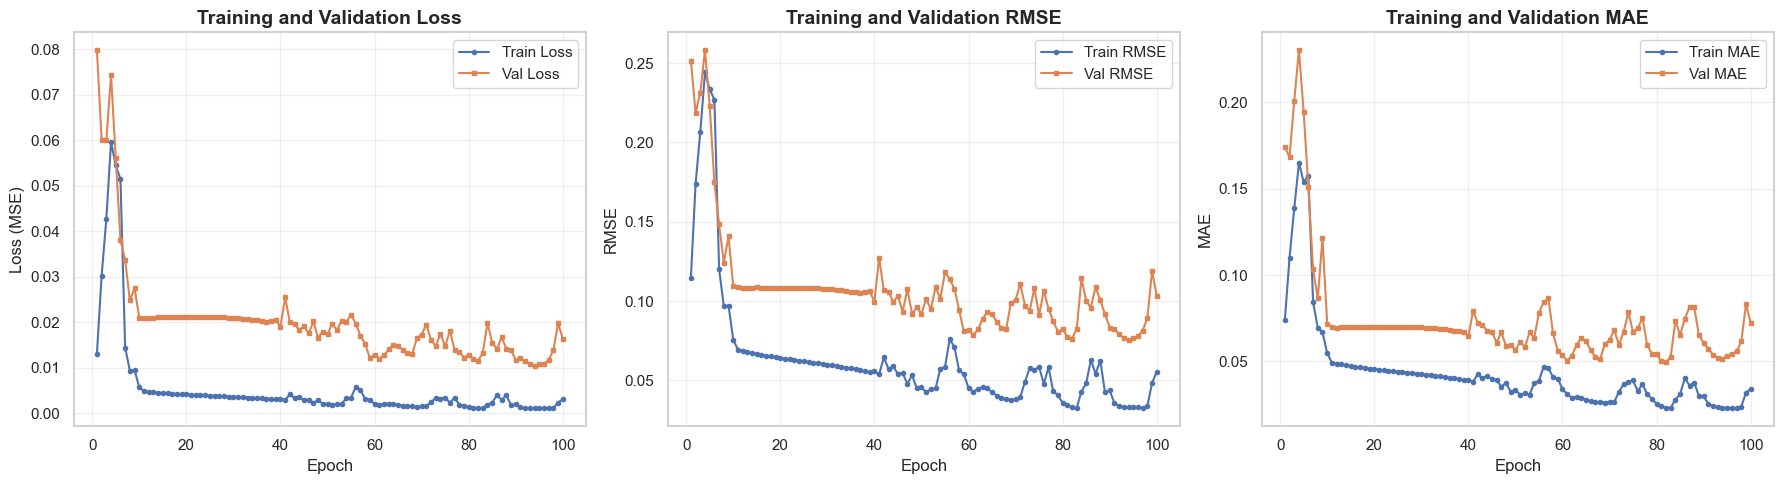

In [68]:
plot_learning_curves(history)

In [69]:
# Now use your existing prediction code
print("Generating validation predictions on original scale...")

# Training predictions
model.eval()
train_predictions_final = []
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        train_predictions_final.append(pred.cpu())

train_forecasts_scaled = torch.cat(train_predictions_final).squeeze().numpy()
train_forecasts = sc_y.inverse_transform(
    train_forecasts_scaled.reshape(-1, 1)
).flatten()

# Validation predictions
val_predictions_final = []
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        val_predictions_final.append(pred.cpu())

val_forecasts_scaled = torch.cat(val_predictions_final).squeeze().numpy()
val_forecasts = sc_y.inverse_transform(val_forecasts_scaled.reshape(-1, 1)).flatten()

# Prepare dataframes (trim first SEQUENCE_LENGTH rows)
train_df_trimmed = train_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)
val_df_trimmed = val_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)

# Get actual and predicted values
y_train_actual = train_df_trimmed["Next_Close"].values
y_train_pred = train_forecasts

y_val_actual = val_df_trimmed["Next_Close"].values
y_val_pred = val_forecasts

# Calculate comprehensive metrics on original scale
train_metrics = calculate_evaluation_metrics(y_train_actual, y_train_pred)
val_metrics = calculate_evaluation_metrics(y_val_actual, y_val_pred)

print("LSTM Model Evaluation Metrics on Training Set:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")
print("\nLSTM Model Evaluation Metrics on Validation Set:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["LSTM_Close"] = {
    "model": model,
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "features": train_df.drop(columns=drop_cols).columns.tolist(),
    "target": "Close",
    "predictions": y_val_pred,
    "training_history": history,
    "best_val_loss": result["best_val_loss"],
    "best_epoch": result["best_epoch"],
}

Generating validation predictions on original scale...
LSTM Model Evaluation Metrics on Training Set:
MAE: 2292.2169
RMSE: 2987.8290
MAPE: 199.8065
Directional_Accuracy: 54.6254

LSTM Model Evaluation Metrics on Validation Set:
MAE: 4865.5728
RMSE: 6971.4873
MAPE: 14.9370
Directional_Accuracy: 49.0598


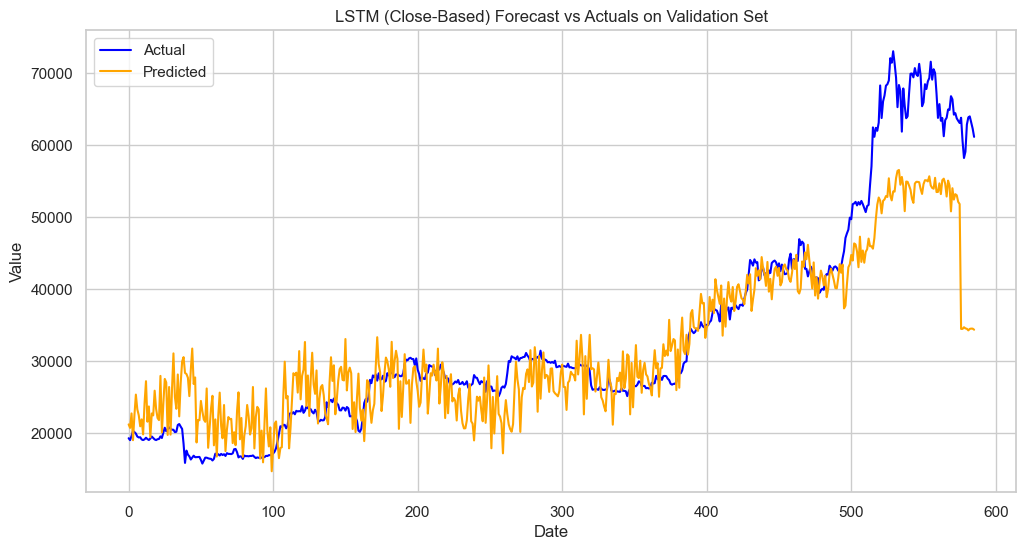

In [70]:
plot_forecasts(
    val_df_trimmed.index,
    y_val_actual,
    y_val_pred,
    title="LSTM (Close-Based) Forecast vs Actuals on Validation Set",
)

##### Predicting Returns

In [71]:
# Prepare data
df_lstm = df.copy()
df_lstm = df_lstm[BASELINE_FEATURES]
df_lstm["target"] = df_lstm["Return"].shift(-1)  # Predict next day's return
df_lstm["Next_Close"] = df_lstm["Close"].shift(-1)
df_lstm = df_lstm.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    df_lstm, TRAIN_SIZE, VALIDATION_SIZE
)

drop_cols = ["target", "Next_Close"]

X_train = train_df.drop(columns=drop_cols).values
y_train = train_df["target"].values  # Returns
X_val = val_df.drop(columns=drop_cols).values
y_val = val_df["target"].values  # Returns

# Scale features
sc_X = MinMaxScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_val_scaled = sc_X.transform(X_val)

# Scale the target variable (returns)
sc_y = MinMaxScaler()
y_train_scaled = sc_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = sc_y.transform(y_val.reshape(-1, 1)).flatten()

In [72]:
# Create datasets and loaders
train_dataset = SequenceDataset(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
val_dataset = SequenceDataset(X_val_scaled, y_val_scaled, SEQUENCE_LENGTH)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [73]:
sample_batch_X, _ = next(iter(train_loader))
input_size = sample_batch_X.shape[2]

result = train_nn_model(
    "LSTM",
    train_loader,
    val_loader,
    input_size,
    HIDDEN_SIZE,
    NUM_LAYERS,
    DROPOUT,
    LR,
    EPOCHS,
)

# Extract trained model and device from results
model = result["model"]
device = result["device"]
history = result["history"]

Using device: mps
Model parameters: 53,057

Starting training for 100 epochs...
Epoch 20/100
  Train Loss: 0.004433 | Val Loss: 0.003200
  Train RMSE: 0.066588 | Val RMSE: 0.049980
  Train MAE: 0.046559 | Val MAE: 0.037278
Epoch 40/100
  Train Loss: 0.004241 | Val Loss: 0.002230
  Train RMSE: 0.065131 | Val RMSE: 0.045315
  Train MAE: 0.044840 | Val MAE: 0.033716
Epoch 60/100
  Train Loss: 0.004133 | Val Loss: 0.001918
  Train RMSE: 0.064298 | Val RMSE: 0.043378
  Train MAE: 0.043919 | Val MAE: 0.031577
Epoch 80/100
  Train Loss: 0.004066 | Val Loss: 0.001912
  Train RMSE: 0.063775 | Val RMSE: 0.043508
  Train MAE: 0.043502 | Val MAE: 0.031836
Epoch 100/100
  Train Loss: 0.003963 | Val Loss: 0.001963
  Train RMSE: 0.062966 | Val RMSE: 0.044090
  Train MAE: 0.042956 | Val MAE: 0.032380
Training complete!
Best validation loss: 0.001847 at epoch 71


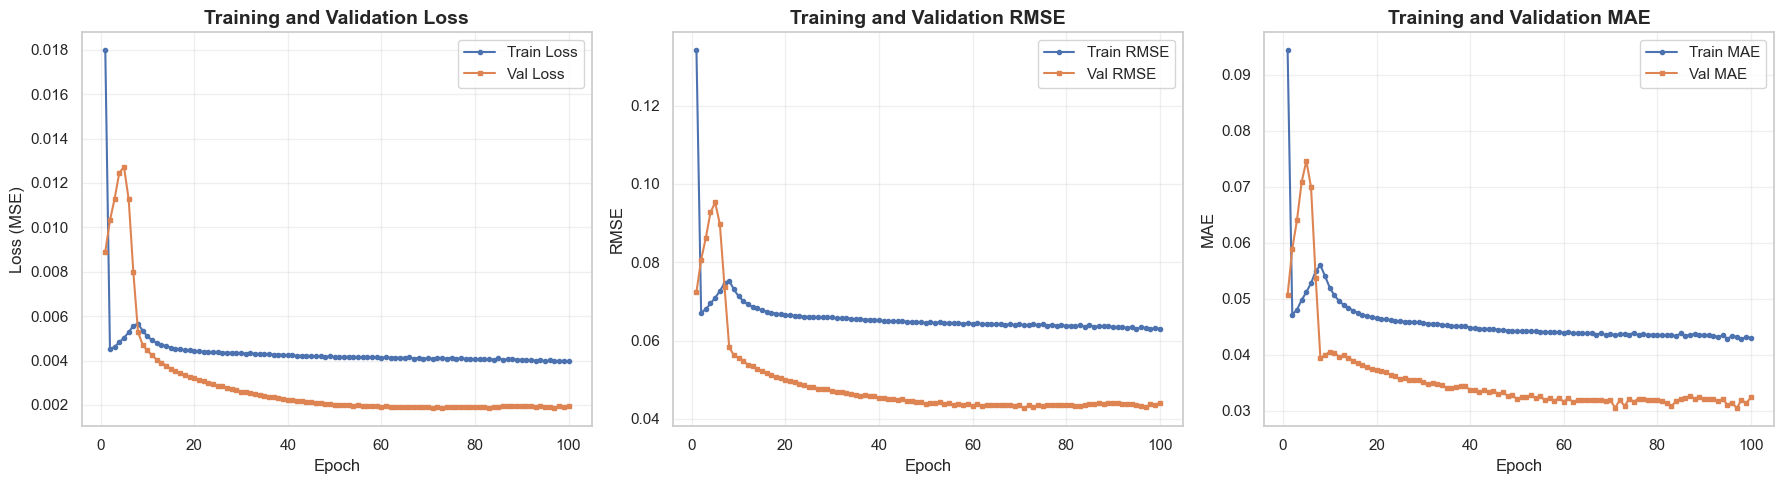

In [74]:
plot_learning_curves(history)

In [75]:
print("Generating predictions on original scale...")
model.eval()

# Training predictions
train_predictions = []
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        train_predictions.append(pred.cpu())

train_forecasts_scaled = torch.cat(train_predictions).squeeze().numpy()

# Inverse transform predictions back to original scale (returns)
train_return_forecasts = sc_y.inverse_transform(
    train_forecasts_scaled.reshape(-1, 1)
).flatten()

# Validation predictions
val_predictions = []
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        val_predictions.append(pred.cpu())

val_forecasts_scaled = torch.cat(val_predictions).squeeze().numpy()

# Inverse transform predictions back to original scale (returns)
val_return_forecasts = sc_y.inverse_transform(
    val_forecasts_scaled.reshape(-1, 1)
).flatten()

# Prepare dataframes (trim first SEQUENCE_LENGTH rows)
train_df_trimmed = train_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)
val_df_trimmed = val_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)

# Back-transform Returns to Prices for training
y_train_actual_prices, y_train_pred_prices = back_transform_returns_to_price(
    train_df_trimmed, train_return_forecasts, "Close", "Next_Close"
)

# Back-transform Returns to Prices for validation
y_val_actual_prices, y_val_pred_prices = back_transform_returns_to_price(
    val_df_trimmed, val_return_forecasts, "Close", "Next_Close"
)

# Calculate metrics
train_metrics = calculate_evaluation_metrics(y_train_actual_prices, y_train_pred_prices)
val_metrics = calculate_evaluation_metrics(y_val_actual_prices, y_val_pred_prices)

print("LSTM (Returns-Based) Model Evaluation Metrics on Training Set:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")
print("\nLSTM (Returns-Based) Model Evaluation Metrics on Validation Set:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["LSTM_Returns"] = {
    "model": model,
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "features": train_df.drop(columns=drop_cols).columns.tolist(),
    "target": "Return",
    "predictions": y_val_pred_prices,
    "training_history": history,
    "best_val_loss": result["best_val_loss"],
    "best_epoch": result["best_epoch"],
}

Generating predictions on original scale...
LSTM (Returns-Based) Model Evaluation Metrics on Training Set:
MAE: 393.9134
RMSE: 797.7045
MAPE: 3.4801
Directional_Accuracy: 55.4344

LSTM (Returns-Based) Model Evaluation Metrics on Validation Set:
MAE: 685.4128
RMSE: 1066.6396
MAPE: 2.0266
Directional_Accuracy: 49.7436


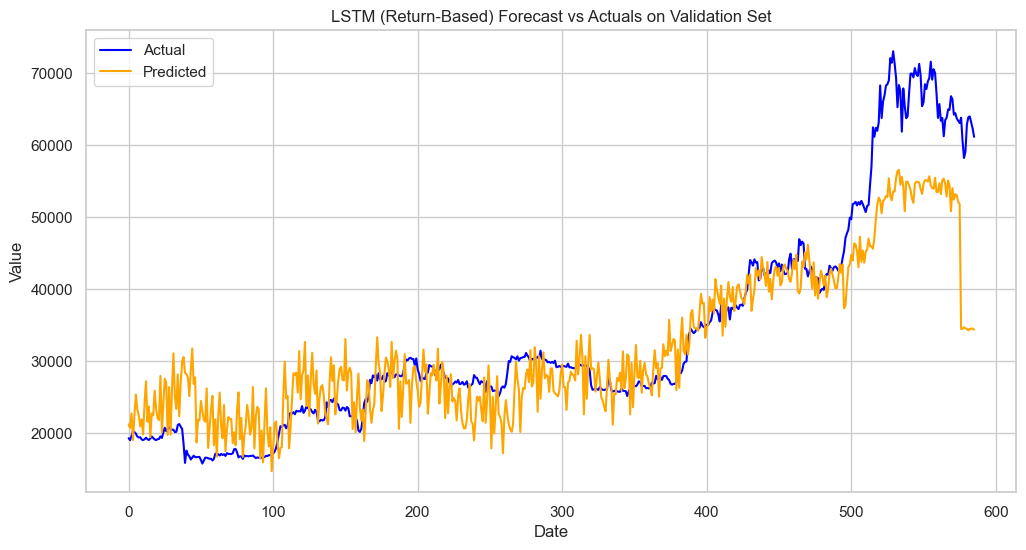

In [76]:
plot_forecasts(
    val_df_trimmed.index,
    y_val_actual,
    y_val_pred,
    title="LSTM (Return-Based) Forecast vs Actuals on Validation Set",
)

#### GRU Model

##### Predicting Close Price

In [77]:
# Prepare data
df_gru = df.copy()
df_gru = df_gru[BASELINE_FEATURES]
df_gru["target"] = df_gru["Close"].shift(-1)
df_gru["Next_Close"] = df_gru["Close"].shift(-1)
df_gru = df_gru.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    df_gru, TRAIN_SIZE, VALIDATION_SIZE
)

drop_cols = ["target", "Next_Close"]

X_train = train_df.drop(columns=drop_cols).values
y_train = train_df["target"].values
X_val = val_df.drop(columns=drop_cols).values
y_val = val_df["target"].values

# Scale features
sc_X = MinMaxScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_val_scaled = sc_X.transform(X_val)

# Scale the target variable
sc_y = MinMaxScaler()
y_train_scaled = sc_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = sc_y.transform(y_val.reshape(-1, 1)).flatten()

In [78]:
# Create datasets and loaders
train_dataset = SequenceDataset(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
val_dataset = SequenceDataset(X_val_scaled, y_val_scaled, SEQUENCE_LENGTH)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [79]:
sample_batch_X, _ = next(iter(train_loader))
input_size = sample_batch_X.shape[2]

result = train_nn_model(
    "GRU",
    train_loader,
    val_loader,
    input_size,
    HIDDEN_SIZE,
    NUM_LAYERS,
    DROPOUT,
    LR,
    EPOCHS,
)

# Extract trained model and device from results
model = result["model"]
device = result["device"]
history = result["history"]

Using device: mps
Model parameters: 39,809

Starting training for 100 epochs...
Epoch 20/100
  Train Loss: 0.003090 | Val Loss: 0.002749
  Train RMSE: 0.055580 | Val RMSE: 0.052242
  Train MAE: 0.034273 | Val MAE: 0.036253
Epoch 40/100
  Train Loss: 0.003416 | Val Loss: 0.004788
  Train RMSE: 0.058461 | Val RMSE: 0.066994
  Train MAE: 0.037871 | Val MAE: 0.049196
Epoch 60/100
  Train Loss: 0.001869 | Val Loss: 0.004114
  Train RMSE: 0.043254 | Val RMSE: 0.063944
  Train MAE: 0.026837 | Val MAE: 0.048876
Epoch 80/100
  Train Loss: 0.001669 | Val Loss: 0.001693
  Train RMSE: 0.040864 | Val RMSE: 0.040495
  Train MAE: 0.029883 | Val MAE: 0.027546
Epoch 100/100
  Train Loss: 0.002599 | Val Loss: 0.009648
  Train RMSE: 0.051006 | Val RMSE: 0.092586
  Train MAE: 0.034695 | Val MAE: 0.061034
Training complete!
Best validation loss: 0.001161 at epoch 83


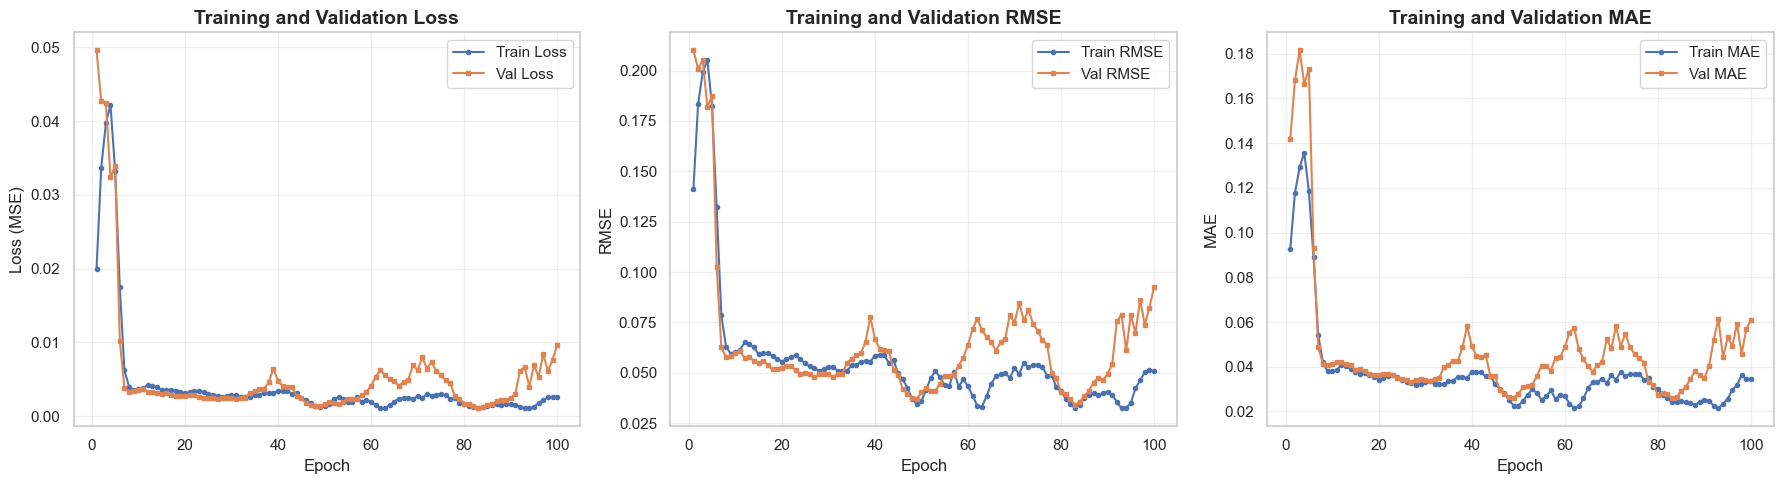

In [80]:
plot_learning_curves(history)

In [81]:
# Now use your existing prediction code
print("Generating validation predictions on original scale...")

# Training predictions
model.eval()
train_predictions_final = []
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        train_predictions_final.append(pred.cpu())

train_forecasts_scaled = torch.cat(train_predictions_final).squeeze().numpy()
train_forecasts = sc_y.inverse_transform(
    train_forecasts_scaled.reshape(-1, 1)
).flatten()

# Validation predictions
val_predictions_final = []
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        val_predictions_final.append(pred.cpu())

val_forecasts_scaled = torch.cat(val_predictions_final).squeeze().numpy()
val_forecasts = sc_y.inverse_transform(val_forecasts_scaled.reshape(-1, 1)).flatten()

# Prepare dataframes (trim first SEQUENCE_LENGTH rows)
train_df_trimmed = train_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)
val_df_trimmed = val_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)

# Get actual and predicted values
y_train_actual = train_df_trimmed["Next_Close"].values
y_train_pred = train_forecasts

y_val_actual = val_df_trimmed["Next_Close"].values
y_val_pred = val_forecasts

# Calculate comprehensive metrics on original scale
train_metrics = calculate_evaluation_metrics(y_train_actual, y_train_pred)
val_metrics = calculate_evaluation_metrics(y_val_actual, y_val_pred)

print("GRU Model Evaluation Metrics on Training Set:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")
print("\nGRU Model Evaluation Metrics on Validation Set:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["GRU_Close"] = {
    "model": model,
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "features": train_df.drop(columns=drop_cols).columns.tolist(),
    "target": "Close",
    "predictions": y_val_pred,
    "training_history": history,
    "best_val_loss": result["best_val_loss"],
    "best_epoch": result["best_epoch"],
}

Generating validation predictions on original scale...
GRU Model Evaluation Metrics on Training Set:
MAE: 3709.1478
RMSE: 4326.8285
MAPE: 403.6707
Directional_Accuracy: 54.2385

GRU Model Evaluation Metrics on Validation Set:
MAE: 4112.9980
RMSE: 6239.2239
MAPE: 10.2603
Directional_Accuracy: 50.4274


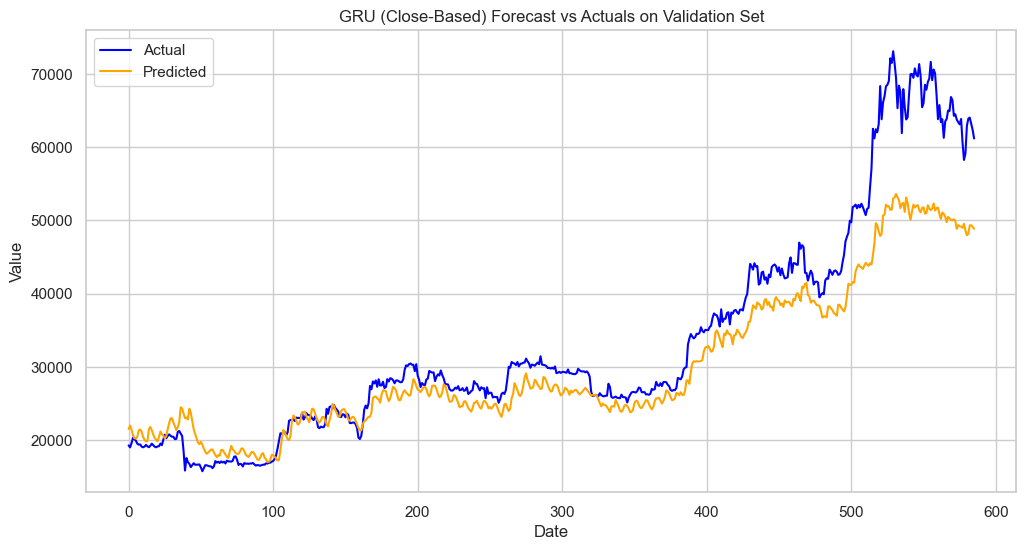

In [82]:
plot_forecasts(
    val_df_trimmed.index,
    y_val_actual,
    y_val_pred,
    title="GRU (Close-Based) Forecast vs Actuals on Validation Set",
)

##### Predicting Returns

In [83]:
# Prepare data
df_gru = df.copy()
df_gru = df_gru[BASELINE_FEATURES]
df_gru["target"] = df_gru["Return"].shift(-1)  # Predict next day's return
df_gru["Next_Close"] = df_gru["Close"].shift(-1)
df_gru = df_gru.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    df_gru, TRAIN_SIZE, VALIDATION_SIZE
)

drop_cols = ["target", "Next_Close"]

X_train = train_df.drop(columns=drop_cols).values
y_train = train_df["target"].values  # Returns
X_val = val_df.drop(columns=drop_cols).values
y_val = val_df["target"].values  # Returns

# Scale features
sc_X = MinMaxScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_val_scaled = sc_X.transform(X_val)

# Scale the target variable (returns)
sc_y = MinMaxScaler()
y_train_scaled = sc_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = sc_y.transform(y_val.reshape(-1, 1)).flatten()

In [84]:
# Create datasets and loaders
train_dataset = SequenceDataset(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
val_dataset = SequenceDataset(X_val_scaled, y_val_scaled, SEQUENCE_LENGTH)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [85]:
sample_batch_X, _ = next(iter(train_loader))
input_size = sample_batch_X.shape[2]

result = train_nn_model(
    "GRU",
    train_loader,
    val_loader,
    input_size,
    HIDDEN_SIZE,
    NUM_LAYERS,
    DROPOUT,
    LR,
    EPOCHS,
)

# Extract trained model and device from results
model = result["model"]
device = result["device"]
history = result["history"]

Using device: mps
Model parameters: 39,809

Starting training for 100 epochs...
Epoch 20/100
  Train Loss: 0.004941 | Val Loss: 0.002754
  Train RMSE: 0.070275 | Val RMSE: 0.051909
  Train MAE: 0.050251 | Val MAE: 0.041118
Epoch 40/100
  Train Loss: 0.004402 | Val Loss: 0.002174
  Train RMSE: 0.066360 | Val RMSE: 0.045571
  Train MAE: 0.046377 | Val MAE: 0.032942
Epoch 60/100
  Train Loss: 0.004609 | Val Loss: 0.002521
  Train RMSE: 0.067874 | Val RMSE: 0.050111
  Train MAE: 0.047334 | Val MAE: 0.039070
Epoch 80/100
  Train Loss: 0.004148 | Val Loss: 0.002386
  Train RMSE: 0.064402 | Val RMSE: 0.048798
  Train MAE: 0.043629 | Val MAE: 0.038100
Epoch 100/100
  Train Loss: 0.004500 | Val Loss: 0.002596
  Train RMSE: 0.067077 | Val RMSE: 0.050908
  Train MAE: 0.046608 | Val MAE: 0.038449
Training complete!
Best validation loss: 0.001751 at epoch 1


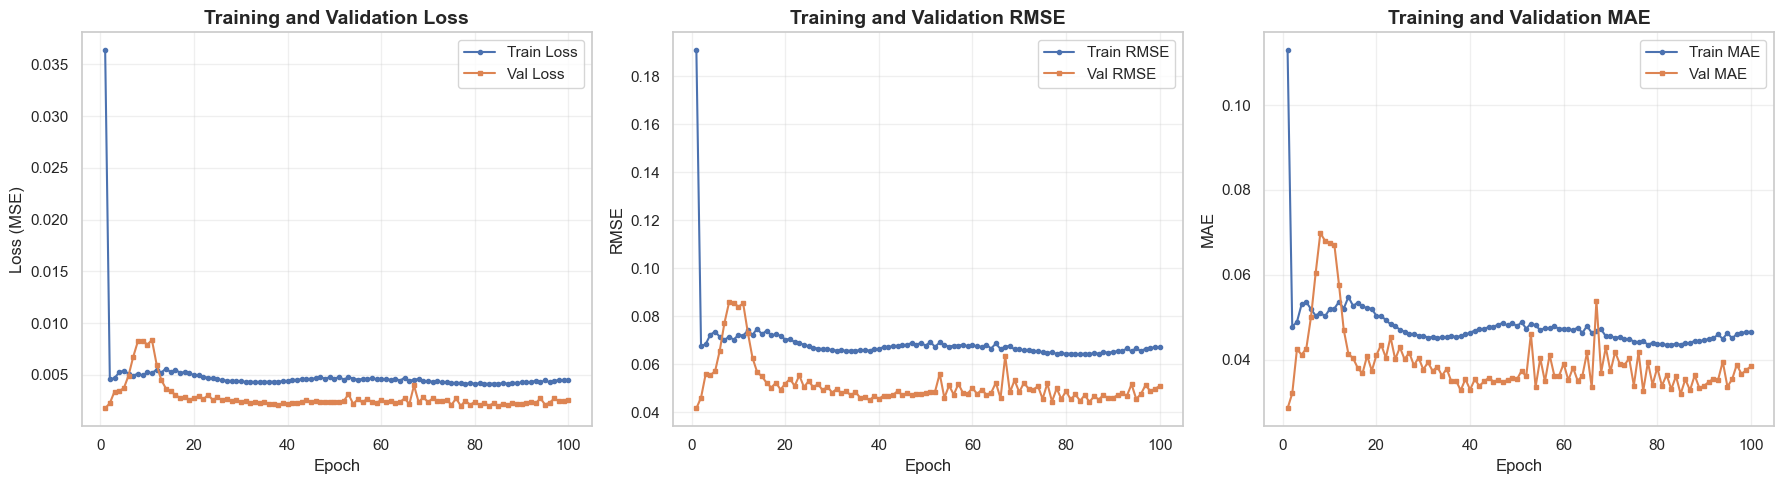

In [86]:
plot_learning_curves(history)

In [87]:
print("Generating predictions on original scale...")
model.eval()

# Training predictions
train_predictions = []
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        train_predictions.append(pred.cpu())

train_forecasts_scaled = torch.cat(train_predictions).squeeze().numpy()

# Inverse transform predictions back to original scale (returns)
train_return_forecasts = sc_y.inverse_transform(
    train_forecasts_scaled.reshape(-1, 1)
).flatten()

# Validation predictions
val_predictions = []
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        val_predictions.append(pred.cpu())

val_forecasts_scaled = torch.cat(val_predictions).squeeze().numpy()

# Inverse transform predictions back to original scale (returns)
val_return_forecasts = sc_y.inverse_transform(
    val_forecasts_scaled.reshape(-1, 1)
).flatten()

# Prepare dataframes (trim first SEQUENCE_LENGTH rows)
train_df_trimmed = train_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)
val_df_trimmed = val_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)

# Back-transform Returns to Prices for training
y_train_actual_prices, y_train_pred_prices = back_transform_returns_to_price(
    train_df_trimmed, train_return_forecasts, "Close", "Next_Close"
)

# Back-transform Returns to Prices for validation
y_val_actual_prices, y_val_pred_prices = back_transform_returns_to_price(
    val_df_trimmed, val_return_forecasts, "Close", "Next_Close"
)

# Calculate metrics
train_metrics = calculate_evaluation_metrics(y_train_actual_prices, y_train_pred_prices)
val_metrics = calculate_evaluation_metrics(y_val_actual_prices, y_val_pred_prices)

print("GRU (Returns-Based) Model Evaluation Metrics on Training Set:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")
print("\nGRU (Returns-Based) Model Evaluation Metrics on Validation Set:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["GRU_Returns"] = {
    "model": model,
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "features": train_df.drop(columns=drop_cols).columns.tolist(),
    "target": "Return",
    "predictions": y_val_pred_prices,
    "training_history": history,
    "best_val_loss": result["best_val_loss"],
    "best_epoch": result["best_epoch"],
}

Generating predictions on original scale...
GRU (Returns-Based) Model Evaluation Metrics on Training Set:
MAE: 497.5718
RMSE: 954.8288
MAPE: 4.6215
Directional_Accuracy: 54.0274

GRU (Returns-Based) Model Evaluation Metrics on Validation Set:
MAE: 805.7503
RMSE: 1211.0871
MAPE: 2.3981
Directional_Accuracy: 48.0342


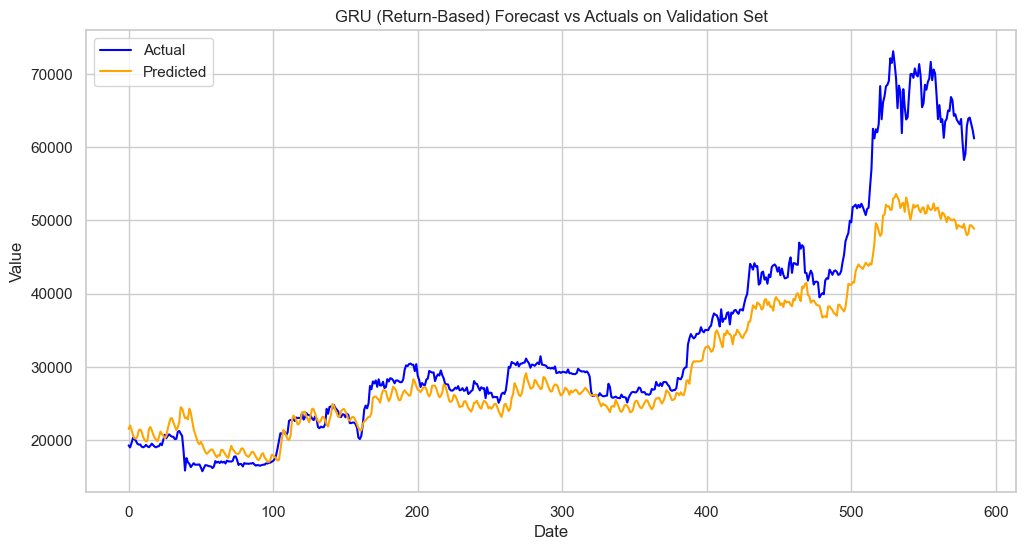

In [88]:
plot_forecasts(
    val_df_trimmed.index,
    y_val_actual,
    y_val_pred,
    title="GRU (Return-Based) Forecast vs Actuals on Validation Set",
)

We can see that GRU model predicting returns performs better than LSTM, however it is still slightly worse than the rolling naive forecast. It seems that predicting returns is more effective than predicting close prices directly for both LSTM and GRU architectures. However, neither model is able to outperform the simple rolling naive forecast in this case. 

Since GRU performed better than LSTM, we can try to improve its performance further by tuning hyperparameters, adding more layers, or incorporating additional features in future experiments. At first we can check wheter predicting log returns will improve the results.

##### Predicting Log Returns

In [89]:
# Prepare data
df_gru = df.copy()
df_gru = df_gru[BASELINE_FEATURES + ["Log_Return"]]
df_gru["target"] = df_gru["Log_Return"].shift(-1)  # Predict next day's log return
df_gru["Next_Close"] = df_gru["Close"].shift(-1)
df_gru = df_gru.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    df_gru, TRAIN_SIZE, VALIDATION_SIZE
)

drop_cols = ["target", "Next_Close", "Log_Return"]

X_train = train_df.drop(columns=drop_cols).values
y_train = train_df["target"].values  # Log Returns
X_val = val_df.drop(columns=drop_cols).values
y_val = val_df["target"].values  # Log Returns

# Scale features
sc_X = MinMaxScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_val_scaled = sc_X.transform(X_val)

# Scale the target variable (returns)
sc_y = MinMaxScaler()
y_train_scaled = sc_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = sc_y.transform(y_val.reshape(-1, 1)).flatten()

In [90]:
# Create datasets and loaders
train_dataset = SequenceDataset(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
val_dataset = SequenceDataset(X_val_scaled, y_val_scaled, SEQUENCE_LENGTH)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [91]:
sample_batch_X, _ = next(iter(train_loader))
input_size = sample_batch_X.shape[2]

result = train_nn_model(
    "GRU",
    train_loader,
    val_loader,
    input_size,
    HIDDEN_SIZE,
    NUM_LAYERS,
    DROPOUT,
    LR,
    EPOCHS,
)

# Extract trained model and device from results
model = result["model"]
device = result["device"]
history = result["history"]

Using device: mps
Model parameters: 39,809

Starting training for 100 epochs...
Epoch 20/100
  Train Loss: 0.004107 | Val Loss: 0.002475
  Train RMSE: 0.064066 | Val RMSE: 0.049676
  Train MAE: 0.045457 | Val MAE: 0.040235
Epoch 40/100
  Train Loss: 0.003775 | Val Loss: 0.001911
  Train RMSE: 0.061444 | Val RMSE: 0.042574
  Train MAE: 0.042823 | Val MAE: 0.031228
Epoch 60/100
  Train Loss: 0.004020 | Val Loss: 0.002268
  Train RMSE: 0.063383 | Val RMSE: 0.047628
  Train MAE: 0.044676 | Val MAE: 0.037220
Epoch 80/100
  Train Loss: 0.003436 | Val Loss: 0.001813
  Train RMSE: 0.058624 | Val RMSE: 0.042430
  Train MAE: 0.039488 | Val MAE: 0.032258
Epoch 100/100
  Train Loss: 0.003724 | Val Loss: 0.002516
  Train RMSE: 0.061022 | Val RMSE: 0.050353
  Train MAE: 0.042316 | Val MAE: 0.038465
Training complete!
Best validation loss: 0.001460 at epoch 1


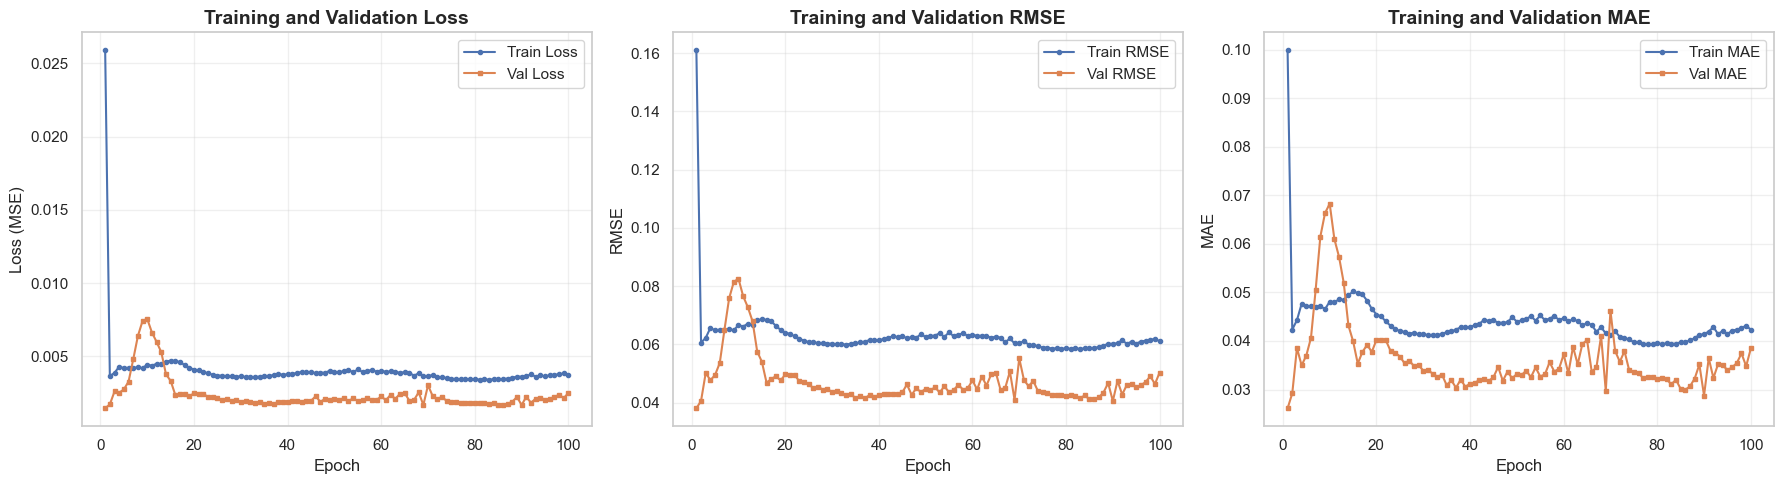

In [92]:
plot_learning_curves(history)

In [93]:
print("Generating predictions on original scale...")
model.eval()

# Training predictions
train_predictions = []
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        train_predictions.append(pred.cpu())

train_forecasts_scaled = torch.cat(train_predictions).squeeze().numpy()

# Inverse transform predictions back to original scale (returns)
train_return_forecasts = sc_y.inverse_transform(
    train_forecasts_scaled.reshape(-1, 1)
).flatten()

# Validation predictions
val_predictions = []
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        val_predictions.append(pred.cpu())

val_forecasts_scaled = torch.cat(val_predictions).squeeze().numpy()

# Inverse transform predictions back to original scale (returns)
val_return_forecasts = sc_y.inverse_transform(
    val_forecasts_scaled.reshape(-1, 1)
).flatten()

# Prepare dataframes (trim first SEQUENCE_LENGTH rows)
train_df_trimmed = train_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)
val_df_trimmed = val_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)

# Back-transform Log Returns to Prices for training
y_train_actual_prices, y_train_pred_prices = back_transform_returns_to_price(
    train_df_trimmed, train_return_forecasts, "Close", "Next_Close", log=True
)

# Back-transform Log Returns to Prices for validation
y_val_actual_prices, y_val_pred_prices = back_transform_returns_to_price(
    val_df_trimmed, val_return_forecasts, "Close", "Next_Close", log=True
)

# Calculate metrics
train_metrics = calculate_evaluation_metrics(y_train_actual_prices, y_train_pred_prices)
val_metrics = calculate_evaluation_metrics(y_val_actual_prices, y_val_pred_prices)

print("GRU (Log Returns-Based) Model Evaluation Metrics on Training Set:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")
print("\nGRU (Log Returns-Based) Model Evaluation Metrics on Validation Set:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["GRU_Log_Returns"] = {
    "model": model,
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "features": train_df.drop(columns=drop_cols).columns.tolist(),
    "target": "Log_Return",
    "predictions": y_val_pred_prices,
    "training_history": history,
    "best_val_loss": result["best_val_loss"],
    "best_epoch": result["best_epoch"],
}

Generating predictions on original scale...
GRU (Log Returns-Based) Model Evaluation Metrics on Training Set:
MAE: 539.2951
RMSE: 1043.7760
MAPE: 4.8295
Directional_Accuracy: 54.2385

GRU (Log Returns-Based) Model Evaluation Metrics on Validation Set:
MAE: 904.0025
RMSE: 1349.7858
MAPE: 2.6570
Directional_Accuracy: 47.8632


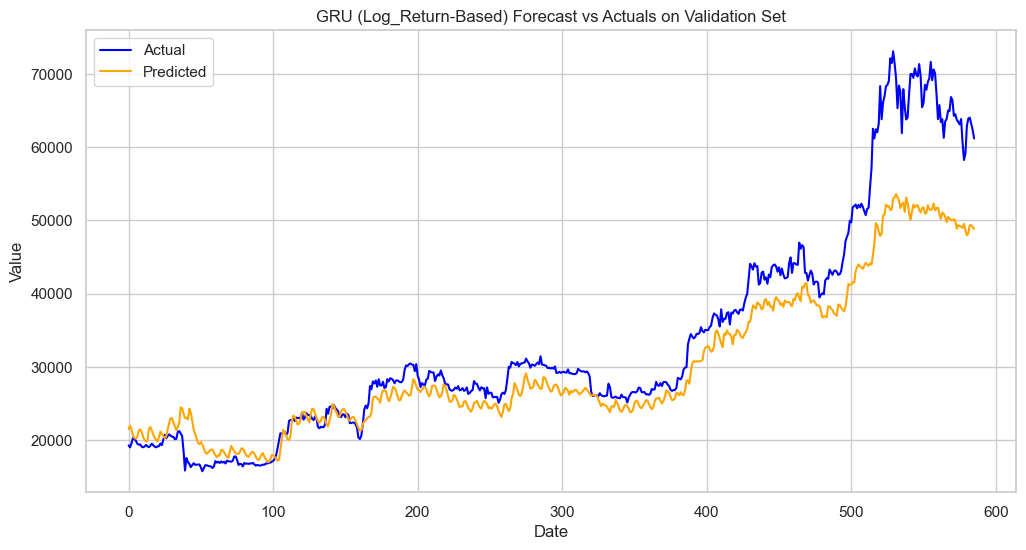

In [94]:
plot_forecasts(
    val_df_trimmed.index,
    y_val_actual,
    y_val_pred,
    title="GRU (Log_Return-Based) Forecast vs Actuals on Validation Set",
)

We can see that predicting log returns with GRU did not improve the results compared to predicting regular returns. 
We may try to incorporate additional engineered features to see if they help the model capture more complex patterns in the data and improve forecasting accuracy.

##### Using All Engineered Features

In [95]:
# Prepare data
df_gru = df.copy()
df_gru = df_gru[ALL_FEATURES]
df_gru["target"] = df_gru["Return"].shift(-1)  # Predict next day's return
df_gru["Next_Close"] = df_gru["Close"].shift(-1)
df_gru = df_gru.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    df_gru, TRAIN_SIZE, VALIDATION_SIZE
)

drop_cols = ["target", "Next_Close"]

X_train = train_df.drop(columns=drop_cols).values
y_train = train_df["target"].values  # Returns
X_val = val_df.drop(columns=drop_cols).values
y_val = val_df["target"].values  # Returns

# Scale features
sc_X = MinMaxScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_val_scaled = sc_X.transform(X_val)

# Scale the target variable (returns)
sc_y = MinMaxScaler()
y_train_scaled = sc_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = sc_y.transform(y_val.reshape(-1, 1)).flatten()

In [96]:
# Create datasets and loaders
train_dataset = SequenceDataset(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
val_dataset = SequenceDataset(X_val_scaled, y_val_scaled, SEQUENCE_LENGTH)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [97]:
sample_batch_X, _ = next(iter(train_loader))
input_size = sample_batch_X.shape[2]

result = train_nn_model(
    "GRU",
    train_loader,
    val_loader,
    input_size,
    HIDDEN_SIZE,
    NUM_LAYERS,
    DROPOUT,
    LR,
    EPOCHS,
)

# Extract trained model and device from results
model = result["model"]
device = result["device"]
history = result["history"]

Using device: mps
Model parameters: 43,073

Starting training for 100 epochs...
Epoch 20/100
  Train Loss: 0.004753 | Val Loss: 0.003845
  Train RMSE: 0.068969 | Val RMSE: 0.058656
  Train MAE: 0.048690 | Val MAE: 0.044163
Epoch 40/100
  Train Loss: 0.004772 | Val Loss: 0.002344
  Train RMSE: 0.069080 | Val RMSE: 0.047725
  Train MAE: 0.048853 | Val MAE: 0.035545
Epoch 60/100
  Train Loss: 0.004113 | Val Loss: 0.002114
  Train RMSE: 0.064137 | Val RMSE: 0.045699
  Train MAE: 0.043660 | Val MAE: 0.033562
Epoch 80/100
  Train Loss: 0.004329 | Val Loss: 0.002305
  Train RMSE: 0.065802 | Val RMSE: 0.047854
  Train MAE: 0.045141 | Val MAE: 0.035953
Epoch 100/100
  Train Loss: 0.004091 | Val Loss: 0.002332
  Train RMSE: 0.063969 | Val RMSE: 0.047978
  Train MAE: 0.043495 | Val MAE: 0.036058
Training complete!
Best validation loss: 0.001860 at epoch 2


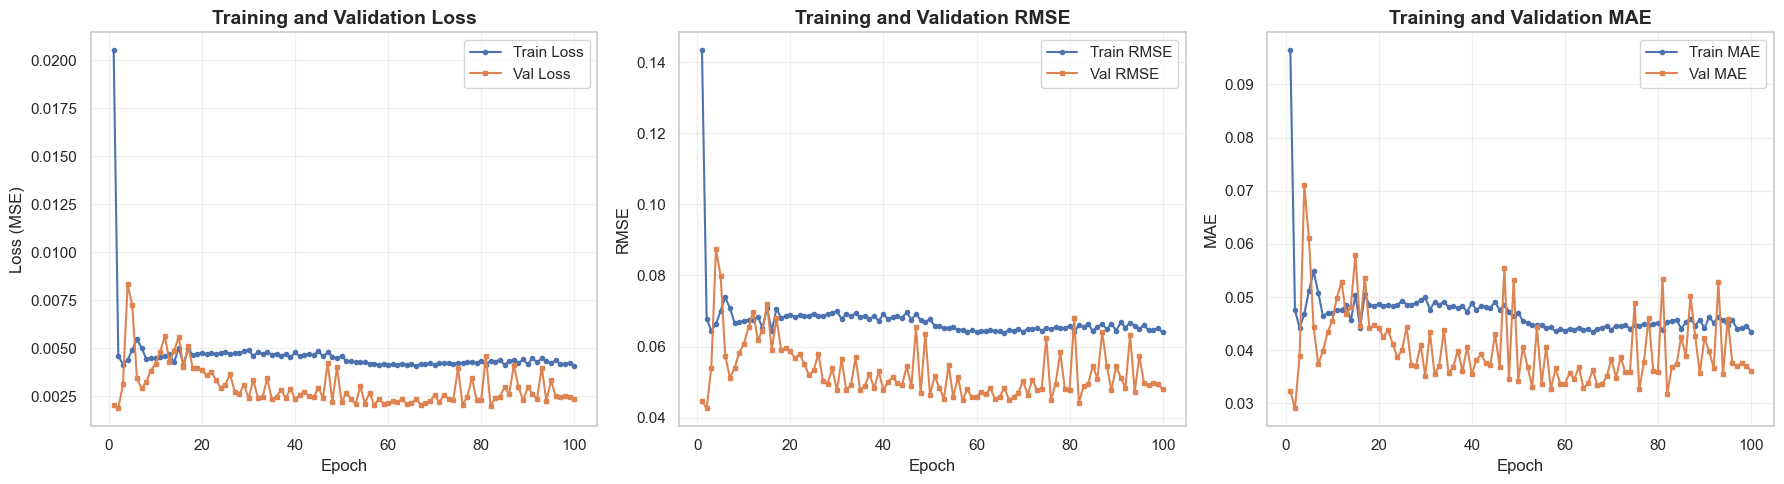

In [98]:
plot_learning_curves(history)

In [99]:
print("Generating predictions on original scale...")
model.eval()

# Training predictions
train_predictions = []
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        train_predictions.append(pred.cpu())

train_forecasts_scaled = torch.cat(train_predictions).squeeze().numpy()

# Inverse transform predictions back to original scale (returns)
train_return_forecasts = sc_y.inverse_transform(
    train_forecasts_scaled.reshape(-1, 1)
).flatten()

# Validation predictions
val_predictions = []
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        pred = model(batch_X)
        val_predictions.append(pred.cpu())

val_forecasts_scaled = torch.cat(val_predictions).squeeze().numpy()

# Inverse transform predictions back to original scale (returns)
val_return_forecasts = sc_y.inverse_transform(
    val_forecasts_scaled.reshape(-1, 1)
).flatten()

# Prepare dataframes (trim first SEQUENCE_LENGTH rows)
train_df_trimmed = train_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)
val_df_trimmed = val_df.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)

# Back-transform Returns to Prices for training
y_train_actual_prices, y_train_pred_prices = back_transform_returns_to_price(
    train_df_trimmed, train_return_forecasts, "Close", "Next_Close"
)

# Back-transform Returns to Prices for validation
y_val_actual_prices, y_val_pred_prices = back_transform_returns_to_price(
    val_df_trimmed, val_return_forecasts, "Close", "Next_Close"
)

# Calculate metrics
train_metrics = calculate_evaluation_metrics(y_train_actual_prices, y_train_pred_prices)
val_metrics = calculate_evaluation_metrics(y_val_actual_prices, y_val_pred_prices)

print("GRU (Returns-Based, All Features) Model Evaluation Metrics on Training Set:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")
print("\nGRU (Returns-Based, All Features) Model Evaluation Metrics on Validation Set:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

MODEL_RESULTS["GRU_Returns_All_Features"] = {
    "model": model,
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "features": train_df.drop(columns=drop_cols).columns.tolist(),
    "target": "Return",
    "predictions": y_val_pred_prices,
    "training_history": history,
    "best_val_loss": result["best_val_loss"],
    "best_epoch": result["best_epoch"],
}

Generating predictions on original scale...
GRU (Returns-Based, All Features) Model Evaluation Metrics on Training Set:
MAE: 443.2604
RMSE: 865.8922
MAPE: 4.1628
Directional_Accuracy: 53.9923

GRU (Returns-Based, All Features) Model Evaluation Metrics on Validation Set:
MAE: 764.8077
RMSE: 1162.9164
MAPE: 2.2516
Directional_Accuracy: 49.5726


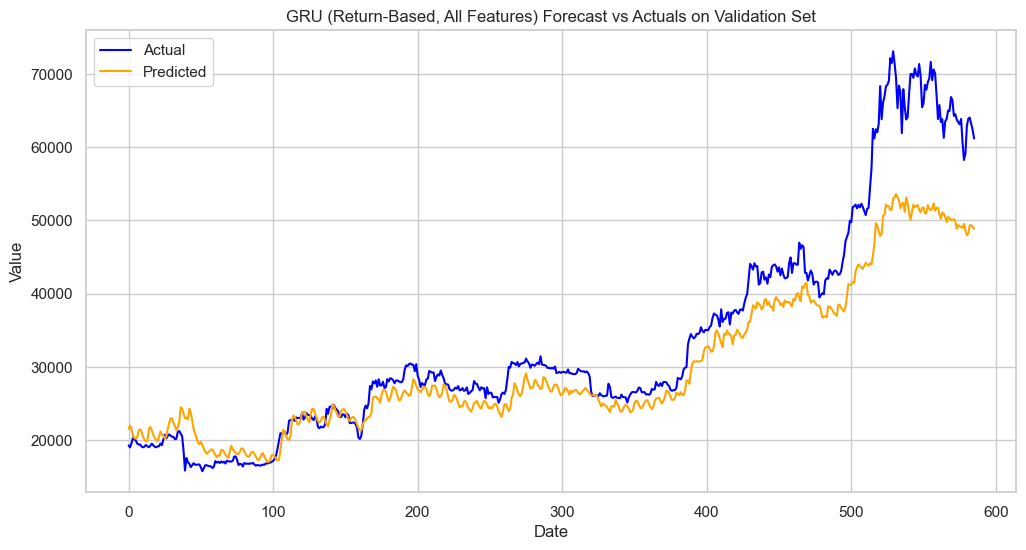

In [100]:
plot_forecasts(
    val_df_trimmed.index,
    y_val_actual,
    y_val_pred,
    title="GRU (Return-Based, All Features) Forecast vs Actuals on Validation Set",
)

## 2. Models Comparison

Now that all models have been trained and evaluated, we will compare their performance using various visualizations and metrics to identify the best performing models for Bitcoin price prediction.

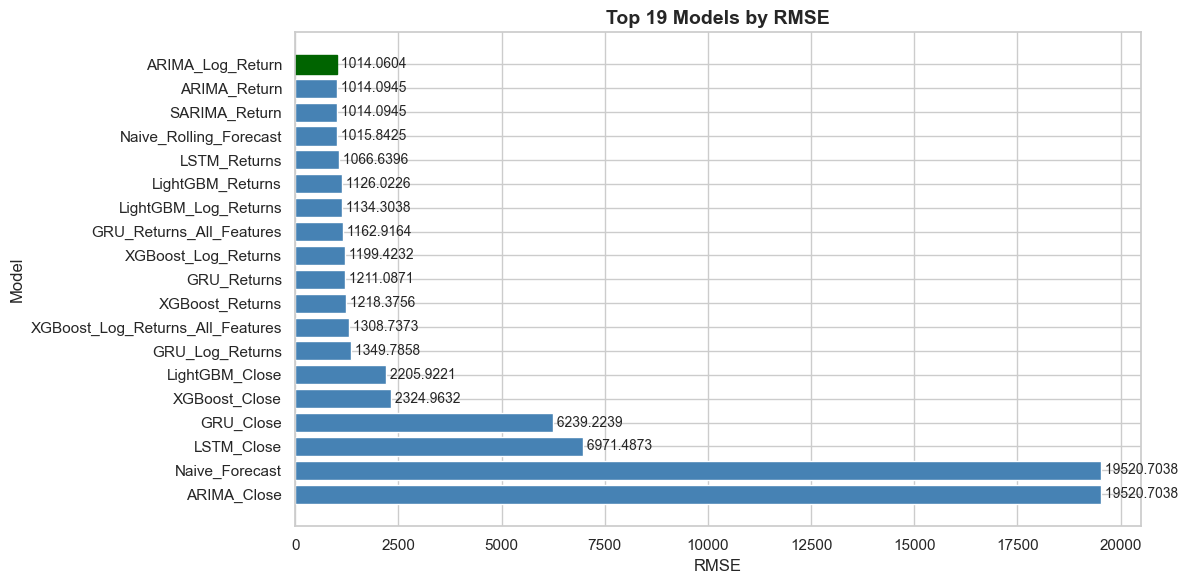


Top 19 Models by RMSE
 1. ARIMA_Log_Return               RMSE: 1014.0604
 2. ARIMA_Return                   RMSE: 1014.0945
 3. SARIMA_Return                  RMSE: 1014.0945
 4. Naive_Rolling_Forecast         RMSE: 1015.8425
 5. LSTM_Returns                   RMSE: 1066.6396
 6. LightGBM_Returns               RMSE: 1126.0226
 7. LightGBM_Log_Returns           RMSE: 1134.3038
 8. GRU_Returns_All_Features       RMSE: 1162.9164
 9. XGBoost_Log_Returns            RMSE: 1199.4232
10. GRU_Returns                    RMSE: 1211.0871
11. XGBoost_Returns                RMSE: 1218.3756
12. XGBoost_Log_Returns_All_Features RMSE: 1308.7373
13. GRU_Log_Returns                RMSE: 1349.7858
14. LightGBM_Close                 RMSE: 2205.9221
15. XGBoost_Close                  RMSE: 2324.9632
16. GRU_Close                      RMSE: 6239.2239
17. LSTM_Close                     RMSE: 6971.4873
18. Naive_Forecast                 RMSE: 19520.7038
19. ARIMA_Close                    RMSE: 19520.7038



In [101]:
# Plot top models based on RMSE
plot_top_models(MODEL_RESULTS, metric="RMSE", top_n=20)

For machine learning and deep learning models, we can also compare validation metrics to train metrics to check for overfitting.

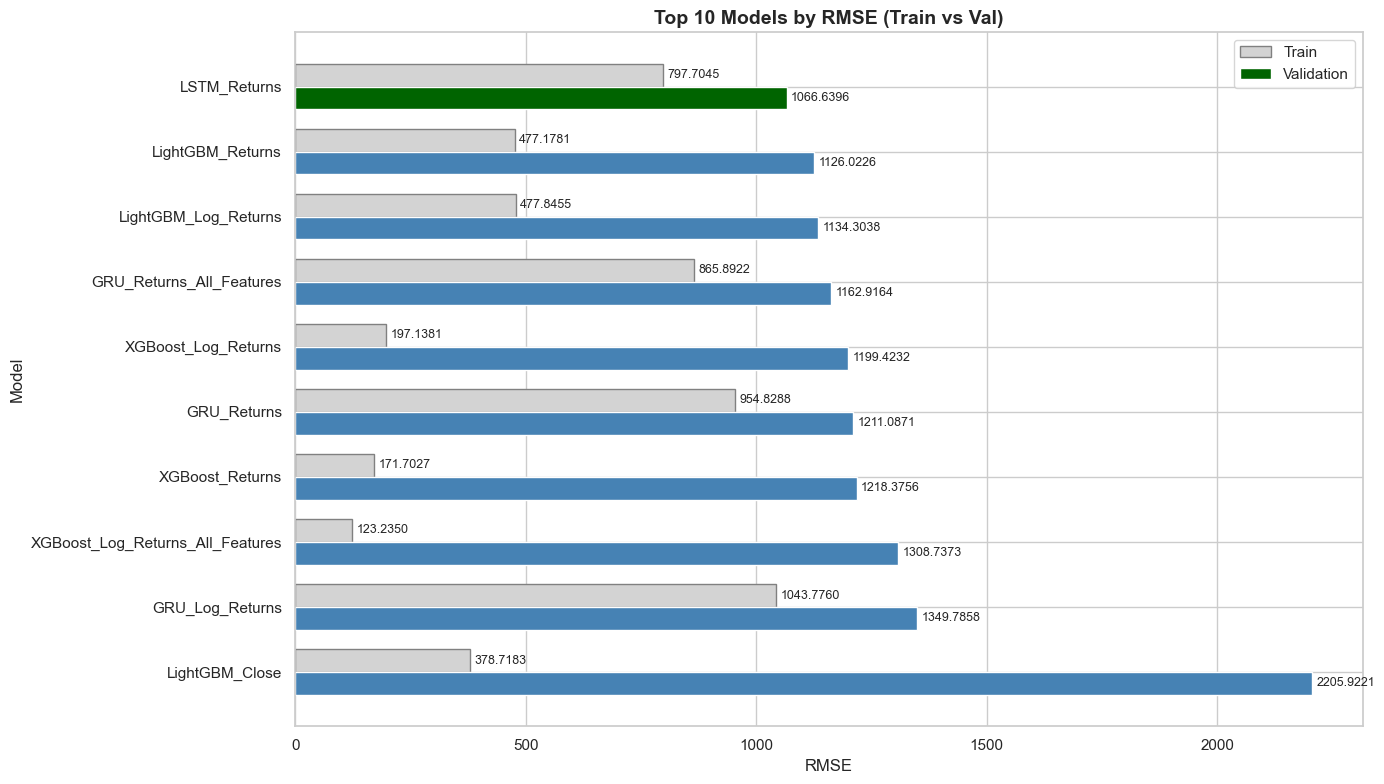


Top 10 Models by RMSE (Sorted by Validation Performance)
Rank  Model Name                          Train RMSE      Val RMSE        Delta     
-------------------------------------------------------------------------------------
1     LSTM_Returns                        797.7045        1066.6396       268.9350  
2     LightGBM_Returns                    477.1781        1126.0226       648.8446  
3     LightGBM_Log_Returns                477.8455        1134.3038       656.4583  
4     GRU_Returns_All_Features            865.8922        1162.9164       297.0242  
5     XGBoost_Log_Returns                 197.1381        1199.4232       1002.2851 
6     GRU_Returns                         954.8288        1211.0871       256.2584  
7     XGBoost_Returns                     171.7027        1218.3756       1046.6730 
8     XGBoost_Log_Returns_All_Features    123.2350        1308.7373       1185.5022 
9     GRU_Log_Returns                     1043.7760       1349.7858       306.0098  
10    

In [102]:
ml_dl_models_results = {
    k: v
    for k, v in MODEL_RESULTS.items()
    if "LSTM" in k or "GRU" in k or "XGB" in k or "LightGBM" in k
}
plot_top_models_train_val(ml_dl_models_results, metric="RMSE", top_n=10)

We can see that the best performing model in terms of RMSE is ARIM trained to predict Log Return. However, it's performance is only slightly better than the rolling naive forecast, which is a very simple model. This suggests that for bitcoin next day price prediction, even sophisticated models like GRU, LightGBM or Prophet do not provide significant improvements over simple baselines, if any. This highlights the inherent difficulty of forecasting cryptocurrency prices, which are influenced by a wide range of unpredictable factors.

We don't have a lot of models that can be fine-tuned - we have LGBM, XGBoost, LSTM and GRU. The time of training of neural networks is much longer than Gradient Boosting models, so we will focus on tuning those. LGBM performed better than XGBoost, so we will focus on tuning it.

## 3. Optimization and Hyperparameter Tuning for LGBM

We will focus on predicting returns/log returns as predicting close price directly did not perform well for any model. We will use Optuna to perform hyperparameter tuning for LightGBM model to improve its performance further.

### Comparing different feature sets

In [103]:
df.columns

Index(['Close', 'Return', 'Log_Return', 'Price_Diff', 'Volume', 'Close_Lag1',
       'Close_Lag5', 'Close_Lag7', 'Close_Lag30', 'Return_Lag1', 'Return_Lag5',
       'Return_Lag7', 'Return_Lag30', 'SMA_30', 'Rolling_Mean_Return_30',
       'Rolling_Std_Return_30', 'Low_High_Diff', 'Open_Close_Diff',
       'Open_Close_Up', 'Close_Change_5d', 'Close_Change_10d',
       'Close_Change_20d', 'MACD', 'RSI', 'Month', 'DayOfWeek', 'Day',
       'Month_Sin', 'Month_Cos', 'DayOfWeek_Sin', 'DayOfWeek_Cos'],
      dtype='str')

In [104]:
# 1. Focusing on price velocity and momentum indicators
COMBINATION_MOMENTUM = {
    "Momentum_Focus": MOMENTUM_FEATURES + TECH_INDICATORS + ["Return_Lag1"]
}

# 2. Focusing on market volatility and the range of price movement
COMBINATION_VOLATILITY = {
    "Volatility_Regime": ROLLING_STATS + ["Low_High_Diff", "Open_Close_Diff", "Volume"]
}

# 3. Using only stationary data (Returns and Sin/Cos) to avoid scale issues with 'Close' price
COMBINATION_STATIONARY = {
    "Pure_Stationary": [f for f in ALL_FEATURES if "Close" not in f or "Change" in f]
}

# 4. A compact set of the most statistically significant lags and trends
COMBINATION_STRATEGIC_LAG = {
    "Strategic_Lags": ["Return_Lag1", "Return_Lag7", "Close_Lag1", "MACD", "RSI"]
}

# 5. Seasonal and Temporal patterns only
COMBINATION_TEMPORAL = {
    "Temporal_Patterns": TEMPORAL_FEATURES + ["Rolling_Mean_Return_30"]
}

COMBINATION_LAG_MA_TEMPORAL = {
    "Lag_Ma_Temporal_Mix": [
        "Return_Lag1",
        "Return_Lag7",
        "Rolling_Mean_Return_30",
        "Rolling_Std_Return_30",
    ]
    + TEMPORAL_FEATURES
}

# Aggregate all combinations
FEATURES_COMBINATIONS = {
    "Baseline": BASELINE_FEATURES,
    "All_Features": ALL_FEATURES,
    **COMBINATION_MOMENTUM,
    **COMBINATION_VOLATILITY,
    **COMBINATION_STATIONARY,
    **COMBINATION_STRATEGIC_LAG,
    **COMBINATION_TEMPORAL,
    **COMBINATION_LAG_MA_TEMPORAL,
}

LGB_EXPERIMENT_RESULTS = {}

In [105]:
df_experiment = df.copy()

df_experiment = df_experiment[ALL_FEATURES]
df_experiment["target"] = df_experiment["Return"].shift(-1)  # Predict next day's return
df_experiment["Next_Close"] = df_experiment["Close"].shift(-1)
df_experiment = df_experiment.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    df_experiment, TRAIN_SIZE, VALIDATION_SIZE
)

drop_cols = ["target", "Next_Close"]

X_train = train_df.drop(columns=drop_cols)
y_train = train_df["target"]  # Returns
X_val = val_df.drop(columns=drop_cols)
y_val = val_df["target"]  # Returns

for combo_name, feature_list in FEATURES_COMBINATIONS.items():
    print(f"\n{'=' * 60}")
    print(f"Evaluating Feature Set: {combo_name} ({len(feature_list)} features)")
    print(f"{'=' * 60}")

    model, train_metrics, val_metrics = evaluate_feature_set(
        features=feature_list,
        train_df=train_df,
        val_df=val_df,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        log=False,
        random_seed=RANDOM_SEED,
    )

    print("Training Metrics:")
    for metric, value in train_metrics.items():
        print(f"  {metric}: {value:.4f}")

    print("\nValidation Metrics:")
    for metric, value in val_metrics.items():
        print(f"  {metric}: {value:.4f}")

    LGB_EXPERIMENT_RESULTS[f"LGBM_{combo_name}"] = {
        "val_metrics": val_metrics,
        "train_metrics": train_metrics,
        "target": "Return",
        "model": model,
        "features": feature_list,
    }


Evaluating Feature Set: Baseline (11 features)
Training Metrics:
  MAE: 225.3988
  RMSE: 477.1781
  MAPE: 1.7376
  Directional_Accuracy: 76.9579

Validation Metrics:
  MAE: 705.4048
  RMSE: 1126.0226
  MAPE: 2.0226
  Directional_Accuracy: 48.2927

Evaluating Feature Set: All_Features (28 features)
Training Metrics:
  MAE: 181.8614
  RMSE: 388.8126
  MAPE: 1.4253
  Directional_Accuracy: 79.9513

Validation Metrics:
  MAE: 660.5298
  RMSE: 1051.2232
  MAPE: 1.9239
  Directional_Accuracy: 51.3821

Evaluating Feature Set: Momentum_Focus (7 features)
Training Metrics:
  MAE: 237.6220
  RMSE: 514.8117
  MAPE: 1.7735
  Directional_Accuracy: 76.0181

Validation Metrics:
  MAE: 677.3580
  RMSE: 1073.5824
  MAPE: 1.9990
  Directional_Accuracy: 51.2195

Evaluating Feature Set: Volatility_Regime (5 features)
Training Metrics:
  MAE: 248.8259
  RMSE: 520.3823
  MAPE: 1.8902
  Directional_Accuracy: 74.0689

Validation Metrics:
  MAE: 683.8741
  RMSE: 1098.1540
  MAPE: 1.9666
  Directional_Accuracy:

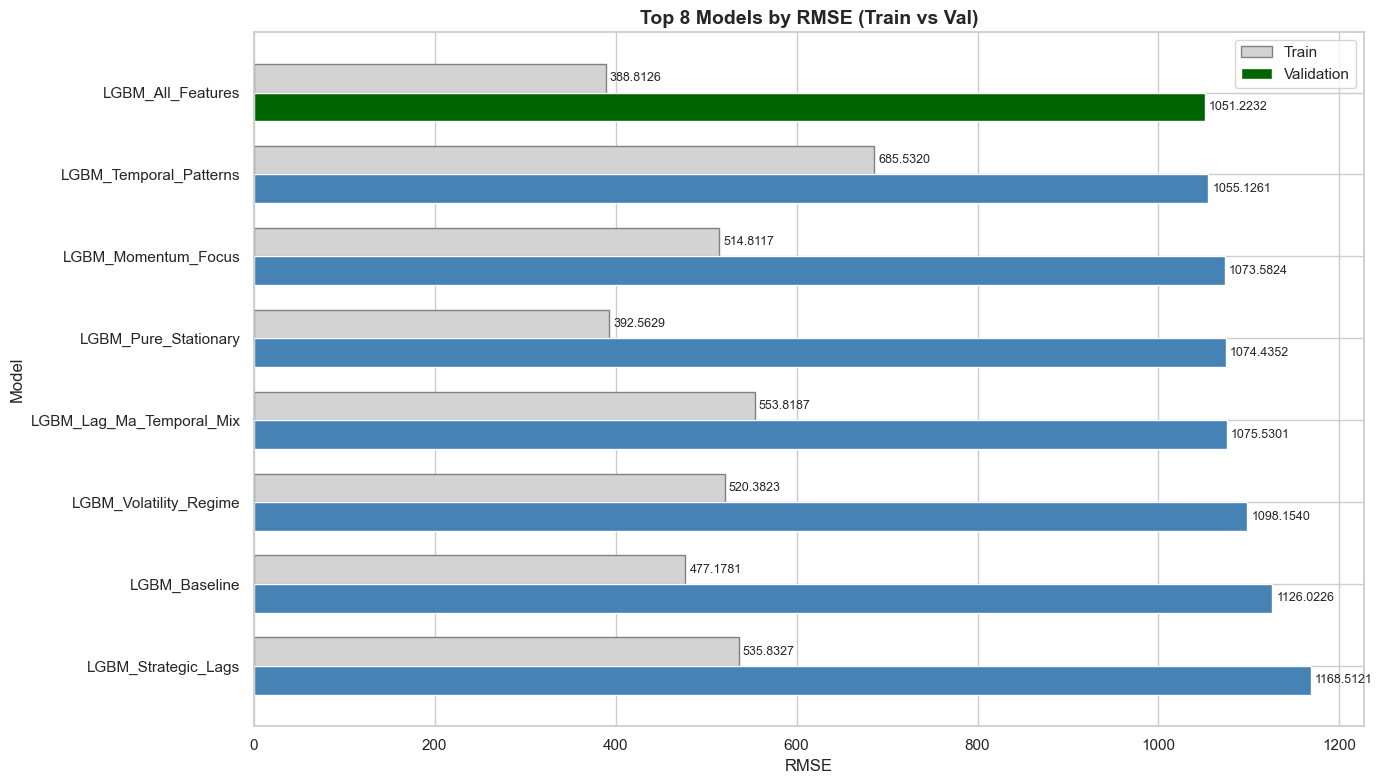


Top 8 Models by RMSE (Sorted by Validation Performance)
Rank  Model Name                          Train RMSE      Val RMSE        Delta     
-------------------------------------------------------------------------------------
1     LGBM_All_Features                   388.8126        1051.2232       662.4106  
2     LGBM_Temporal_Patterns              685.5320        1055.1261       369.5941  
3     LGBM_Momentum_Focus                 514.8117        1073.5824       558.7708  
4     LGBM_Pure_Stationary                392.5629        1074.4352       681.8723  
5     LGBM_Lag_Ma_Temporal_Mix            553.8187        1075.5301       521.7114  
6     LGBM_Volatility_Regime              520.3823        1098.1540       577.7718  
7     LGBM_Baseline                       477.1781        1126.0226       648.8446  
8     LGBM_Strategic_Lags                 535.8327        1168.5121       632.6794  



In [106]:
plot_top_models_train_val(LGB_EXPERIMENT_RESULTS, metric="RMSE", top_n=8)

#### Conclusions after evaluating different feature sets:

* **Best Performance:** The `Temporal_Patterns` model achieved the second lowest validation RMSE, demonstrating that smoothed averages and seasonal features generalize better than raw price fluctuations. We choose it over `All_Features` due to lower overfitting and less complexity.
* **Overfitting Detected:** The `All_Features` and `Pure_Stationary` models exhibited severe overfitting, indicated by training errors that were nearly 50% lower than their validation errors.
* **Feature Validation:** Feature engineering efforts proved effective, as six of the seven new feature combinations outperformed the original `Baseline` model.
* **Lag Instability:** The `Strategic_Lags` model ranked last, suggesting that specific, single-day correlations are too unstable to be reliable predictors in this dataset.
* **Optimization Requirement:** While complex feature sets showed high potential during training, stronger regularization is required to reduce the variance and improve validation performance.

### Hyperparameter Tuning with Optuna

In [107]:
SELECTED_FEATURES = LGB_EXPERIMENT_RESULTS["LGBM_Temporal_Patterns"]["features"]

df_optuma = df.copy()
df_optuma = df_optuma[ALL_FEATURES]
df_optuma["target"] = df_optuma["Return"].shift(-1)  # Predict next day's return
df_optuma["Next_Close"] = df_optuma["Close"].shift(-1)
df_optuma = df_optuma.dropna().reset_index(drop=True)

train_df, val_df, test_df = time_series_train_val_test_split(
    df_optuma, TRAIN_SIZE, VALIDATION_SIZE
)
X_train = train_df.drop(columns=["target", "Next_Close"])
y_train = train_df["target"]
X_val = val_df.drop(columns=["target", "Next_Close"])
y_val = val_df["target"]


def objective(trial):
    """Optuna objective function"""
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "random_state": RANDOM_SEED,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train[SELECTED_FEATURES], y_train)
    preds = model.predict(X_val[SELECTED_FEATURES])
    rmse = np.sqrt(np.mean((y_val - preds) ** 2))

    return rmse

In [108]:
print("\n" + "=" * 50)
print("Running Bayesian Optimization with Optuna...")
print("=" * 50)
study = optuna.create_study(direction="minimize", study_name="lgb_optimization")
study.optimize(objective, n_trials=50, show_progress_bar=False)

[I 2026-02-05 12:12:52,602] A new study created in memory with name: lgb_optimization



Running Bayesian Optimization with Optuna...


[I 2026-02-05 12:12:52,867] Trial 0 finished with value: 0.025940493556602422 and parameters: {'n_estimators': 941, 'learning_rate': 0.06253898366151799, 'num_leaves': 25, 'max_depth': 6, 'min_child_samples': 48, 'subsample': 0.6917307828982395, 'colsample_bytree': 0.6148801603935764, 'reg_alpha': 3.8091159460277098, 'reg_lambda': 8.141090492299364e-06}. Best is trial 0 with value: 0.025940493556602422.
[I 2026-02-05 12:12:55,339] Trial 1 finished with value: 0.026538295371758263 and parameters: {'n_estimators': 731, 'learning_rate': 0.010812389995016705, 'num_leaves': 22, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.8134888913557303, 'colsample_bytree': 0.8805224241023676, 'reg_alpha': 0.009396816881148589, 'reg_lambda': 0.08035073163269713}. Best is trial 0 with value: 0.025940493556602422.
[I 2026-02-05 12:12:56,304] Trial 2 finished with value: 0.02647881316543432 and parameters: {'n_estimators': 339, 'learning_rate': 0.023080711137602683, 'num_leaves': 147, 'max_depth':

In [109]:
# Display best trial
print(f"\nBest RMSE: {study.best_value:.6f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


Best RMSE: 0.025909
Best Parameters:
  n_estimators: 573
  learning_rate: 0.02875383110608384
  num_leaves: 57
  max_depth: 13
  min_child_samples: 77
  subsample: 0.5959451704582225
  colsample_bytree: 0.6779061915944443
  reg_alpha: 1.8914329236875713
  reg_lambda: 0.00014132107796753377


In [110]:
# Train best model and evaluate
best_params = study.best_params
best_params.update(
    {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "random_state": RANDOM_SEED,
    }
)
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train[SELECTED_FEATURES], y_train)

# Generate predictions
train_preds = best_model.predict(X_train[SELECTED_FEATURES])
val_preds = best_model.predict(X_val[SELECTED_FEATURES])

# Back-transform to prices
y_train_actual, y_train_pred = back_transform_returns_to_price(
    train_df, train_preds, "Close", "Next_Close", log=False
)
y_val_actual, y_val_pred = back_transform_returns_to_price(
    val_df, val_preds, "Close", "Next_Close", log=False
)

train_metrics = calculate_evaluation_metrics(y_train_actual, y_train_pred)
val_metrics = calculate_evaluation_metrics(y_val_actual, y_val_pred)

print(f"\n{'=' * 60}")
print("Optimized LightGBM Evaluation Metrics")
print(f"{'=' * 60}")
print("Training Metrics:")
for metric, value in train_metrics.items():
    print(f"  {metric}: {value:.4f}")

print(f"{'=' * 60}")
print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"  {metric}: {value:.4f}")

LGB_EXPERIMENT_RESULTS["LGBM_Optuma_Optimized_Temporal_Patterns"] = {
    "val_metrics": val_metrics,
    "train_metrics": train_metrics,
    "target": "Return",
    "predictions": y_val_pred,
    "model": best_model,
    "features": SELECTED_FEATURES,
}


Optimized LightGBM Evaluation Metrics
Training Metrics:
  MAE: 360.8314
  RMSE: 806.4475
  MAPE: 2.5515
  Directional_Accuracy: 53.7765
Validation Metrics:
  MAE: 606.8252
  RMSE: 1012.3698
  MAPE: 1.7397
  Directional_Accuracy: 49.7561


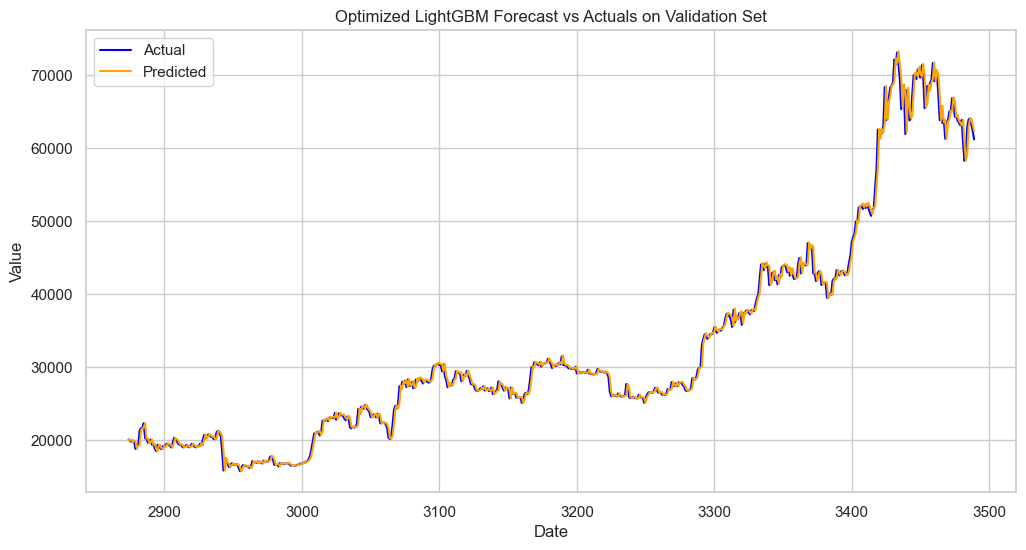

In [111]:
plot_forecasts(
    val_df.index,
    y_val_actual,
    y_val_pred,
    title="Optimized LightGBM Forecast vs Actuals on Validation Set",
)

We can see that after hyperparameter tuning with Optuna, the LightGBM model's performance improved significantly. Achieved RMSE is now the best among all models tested so far, outperforming a little bit ARIMA model predicting log returns.

### Grid Search Hyperparameter Tuning around Optuna Best Parameters

In [ ]:
# Parameter grid around Optuna's best values
param_grid = {
    "n_estimators": [
        max(100, best_params["n_estimators"] - 100),
        best_params["n_estimators"],
        best_params["n_estimators"] + 100,
    ],
    "learning_rate": [
        best_params["learning_rate"] * 0.8,
        best_params["learning_rate"],
        best_params["learning_rate"] * 1.2,
    ],
    "num_leaves": [
        max(20, best_params["num_leaves"] - 10),
        best_params["num_leaves"],
        min(150, best_params["num_leaves"] + 10),
    ],
    "max_depth": [
        max(3, best_params["max_depth"] - 1),
        best_params["max_depth"],
        min(15, best_params["max_depth"] + 1),
    ],
}

# Best params as base
base_params = {k: v for k, v in best_params.items() if k not in param_grid}

grid_search = GridSearchCV(
    lgb.LGBMRegressor(**base_params),
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train[SELECTED_FEATURES], y_train)

print(f"\nBest Grid Search RMSE: {-grid_search.best_score_:.6f}")
print("Best Grid Parameters:")
for key, value in grid_search.best_params_.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best Grid Search RMSE: 0.038389
Best Grid Parameters:
  learning_rate: 0.03450459732730061
  max_depth: 12
  n_estimators: 473
  num_leaves: 47


In [113]:
# Train final model with best parameters
model_params = {**grid_search.best_params_, **base_params}
final_model = lgb.LGBMRegressor(**model_params)
final_model.fit(X_train[SELECTED_FEATURES], y_train)
# Generate predictions
train_preds = final_model.predict(X_train[SELECTED_FEATURES])
val_preds = final_model.predict(X_val[SELECTED_FEATURES])

# Back-transform to prices
y_train_actual, y_train_pred = back_transform_returns_to_price(
    train_df, train_preds, "Close", "Next_Close", log=False
)
y_val_actual, y_val_pred = back_transform_returns_to_price(
    val_df, val_preds, "Close", "Next_Close", log=False
)

train_metrics = calculate_evaluation_metrics(y_train_actual, y_train_pred)
val_metrics = calculate_evaluation_metrics(y_val_actual, y_val_pred)

print(f"\n{'=' * 60}")
print("Final LightGBM after Grid Search Evaluation Metrics")
print(f"{'=' * 60}")
print("Training Metrics:")
for metric, value in train_metrics.items():
    print(f"  {metric}: {value:.4f}")

print(f"{'=' * 60}")
print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"  {metric}: {value:.4f}")

LGB_EXPERIMENT_RESULTS["LGBM_Optuma_GridSearch_Temporal_Patterns"] = {
    "val_metrics": val_metrics,
    "train_metrics": train_metrics,
    "target": "Return",
    "predictions": y_val_pred,
    "model": final_model,
    "features": SELECTED_FEATURES,
}


Final LightGBM after Grid Search Evaluation Metrics
Training Metrics:
  MAE: 360.8318
  RMSE: 806.4551
  MAPE: 2.5515
  Directional_Accuracy: 53.7765
Validation Metrics:
  MAE: 606.8079
  RMSE: 1012.3721
  MAPE: 1.7397
  Directional_Accuracy: 49.7561


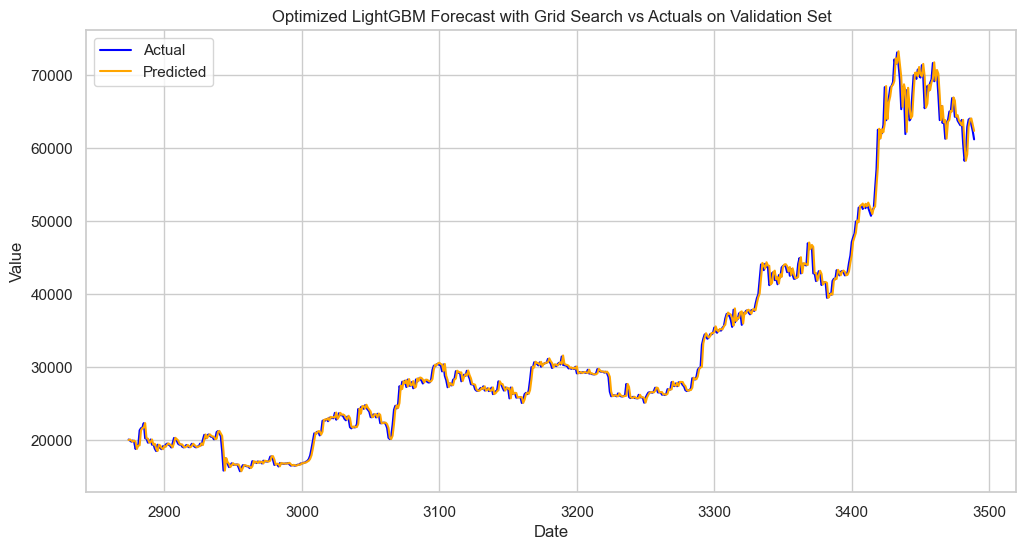

In [114]:
plot_forecasts(
    val_df.index,
    y_val_actual,
    y_val_pred,
    title="Optimized LightGBM Forecast with Grid Search vs Actuals on Validation Set",
)

### Comparison of all LGBM Models after Hyperparameter Tuning

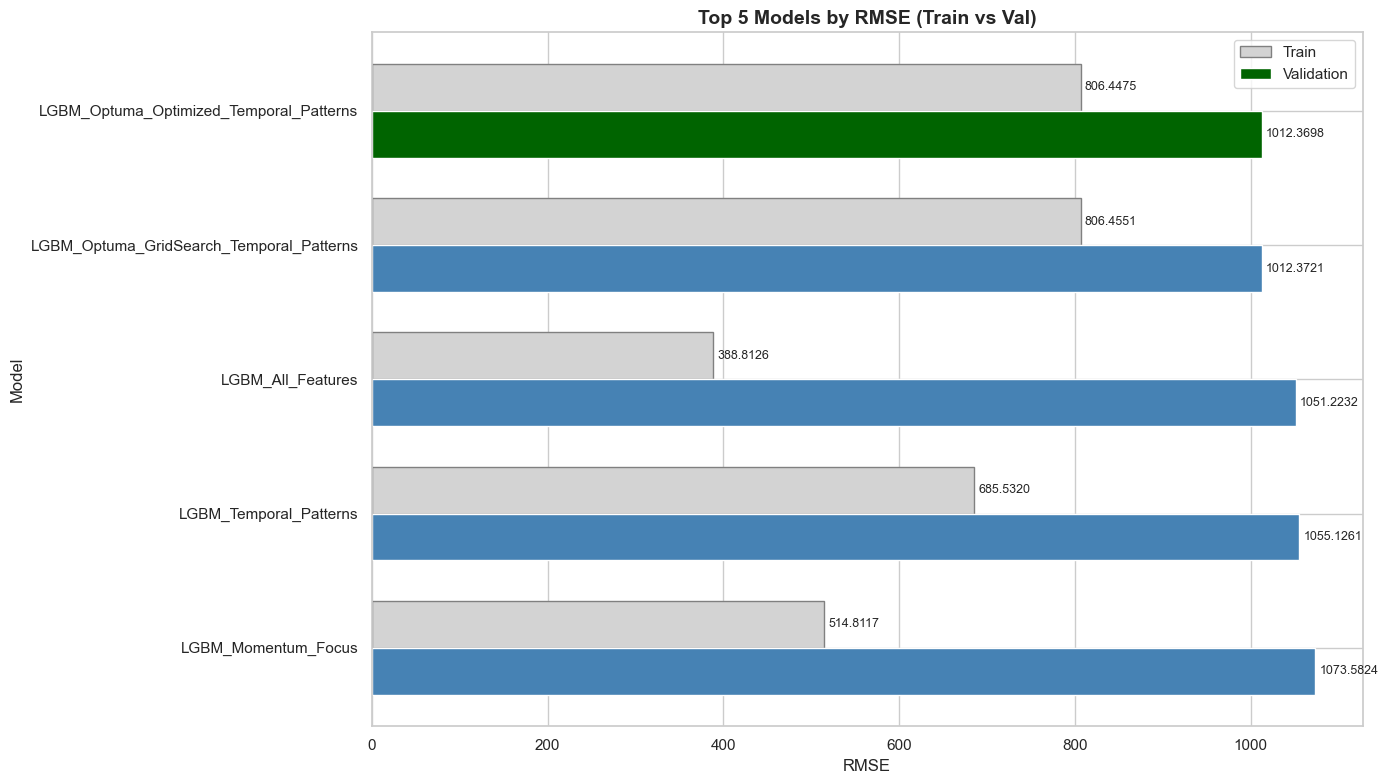


Top 5 Models by RMSE (Sorted by Validation Performance)
Rank  Model Name                          Train RMSE      Val RMSE        Delta     
-------------------------------------------------------------------------------------
1     LGBM_Optuma_Optimized_Temporal_Patterns 806.4475        1012.3698       205.9223  
2     LGBM_Optuma_GridSearch_Temporal_Patterns 806.4551        1012.3721       205.9170  
3     LGBM_All_Features                   388.8126        1051.2232       662.4106  
4     LGBM_Temporal_Patterns              685.5320        1055.1261       369.5941  
5     LGBM_Momentum_Focus                 514.8117        1073.5824       558.7708  



In [115]:
all_models_dict = LGB_EXPERIMENT_RESULTS

plot_top_models_train_val(all_models_dict, metric="RMSE", top_n=5)

## 4. Comparison of all Models after Hyperparameter Tuning

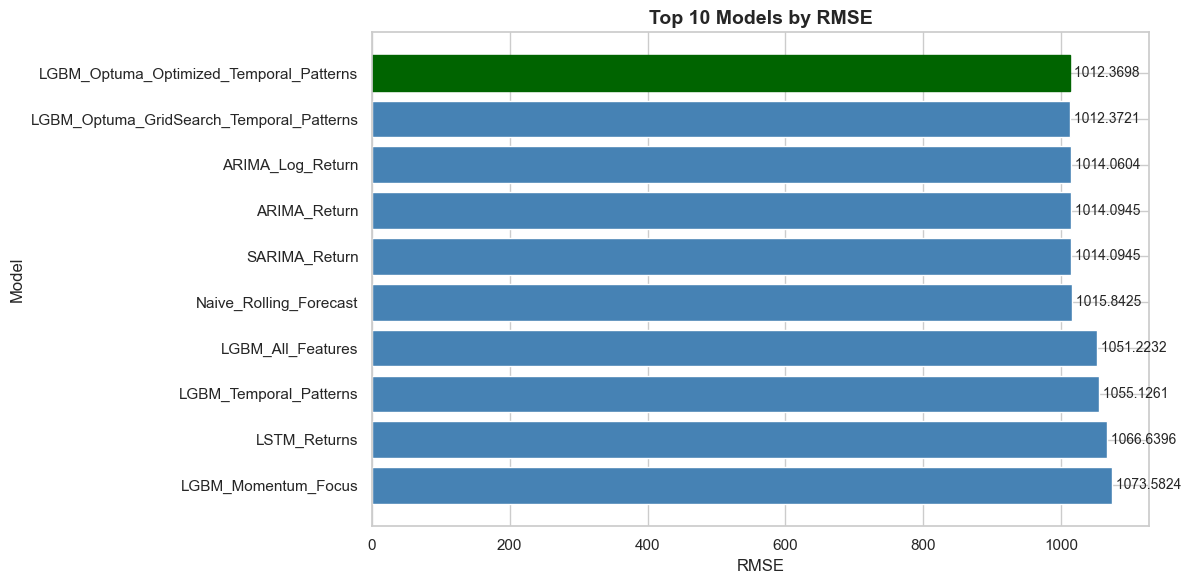


Top 10 Models by RMSE
 1. LGBM_Optuma_Optimized_Temporal_Patterns RMSE: 1012.3698
 2. LGBM_Optuma_GridSearch_Temporal_Patterns RMSE: 1012.3721
 3. ARIMA_Log_Return               RMSE: 1014.0604
 4. ARIMA_Return                   RMSE: 1014.0945
 5. SARIMA_Return                  RMSE: 1014.0945
 6. Naive_Rolling_Forecast         RMSE: 1015.8425
 7. LGBM_All_Features              RMSE: 1051.2232
 8. LGBM_Temporal_Patterns         RMSE: 1055.1261
 9. LSTM_Returns                   RMSE: 1066.6396
10. LGBM_Momentum_Focus            RMSE: 1073.5824



In [116]:
all_models_dict = {**MODEL_RESULTS, **LGB_EXPERIMENT_RESULTS}

plot_top_models(all_models_dict, metric="RMSE", top_n=10)

## 5. Evaluate best model on the test set

In [117]:
best_model_name = min(
    all_models_dict.keys(),
    key=lambda name: (
        all_models_dict[name]["val_metrics"]["RMSE"]
        if "val_metrics" in all_models_dict[name]
        else float("inf")
    ),
)
best_model_info = all_models_dict[best_model_name]
best_model = best_model_info["model"]
val_predictions = best_model_info["predictions"]

print(f"Best model based on RMSE: {best_model_name}")
for attribute, value in best_model_info.items():
    if attribute != "predictions" and attribute != "model":
        print(f"{attribute}: {value}")

Best model based on RMSE: LGBM_Optuma_Optimized_Temporal_Patterns
val_metrics: {'MAE': 606.825190134128, 'RMSE': 1012.3697783727533, 'MAPE': 1.7397332118424509, 'Directional_Accuracy': 49.75609756097561}
train_metrics: {'MAE': 360.83135580271505, 'RMSE': 806.4474871463481, 'MAPE': 2.5515164954209255, 'Directional_Accuracy': 53.77654020187956}
target: Return
features: ['Month_Sin', 'Month_Cos', 'DayOfWeek_Sin', 'DayOfWeek_Cos', 'Rolling_Mean_Return_30']


In [118]:
final_df = df.copy()

final_df["Next_Close"] = final_df["Close"].shift(-1)
final_df = final_df.dropna().reset_index(drop=True)


_, val_df, test_df = time_series_train_val_test_split(
    final_df, TRAIN_SIZE, VALIDATION_SIZE
)

best_model_forecasts = best_model.predict(test_df[best_model_info["features"]])

y_actual_prices_test, y_pred_prices_test = back_transform_returns_to_price(
    test_df, best_model_forecasts, "Close", "Next_Close", log=False
)

final_forecast_metrics = calculate_evaluation_metrics(
    y_actual_prices_test, y_pred_prices_test
)

print("\nBest Model Test Set Evaluation Metrics:")
for metric, value in final_forecast_metrics.items():
    print(f"{metric}: {value:.4f}")


Best Model Test Set Evaluation Metrics:
MAE: 1474.4825
RMSE: 2027.0127
MAPE: 1.6963
Directional_Accuracy: 50.5691


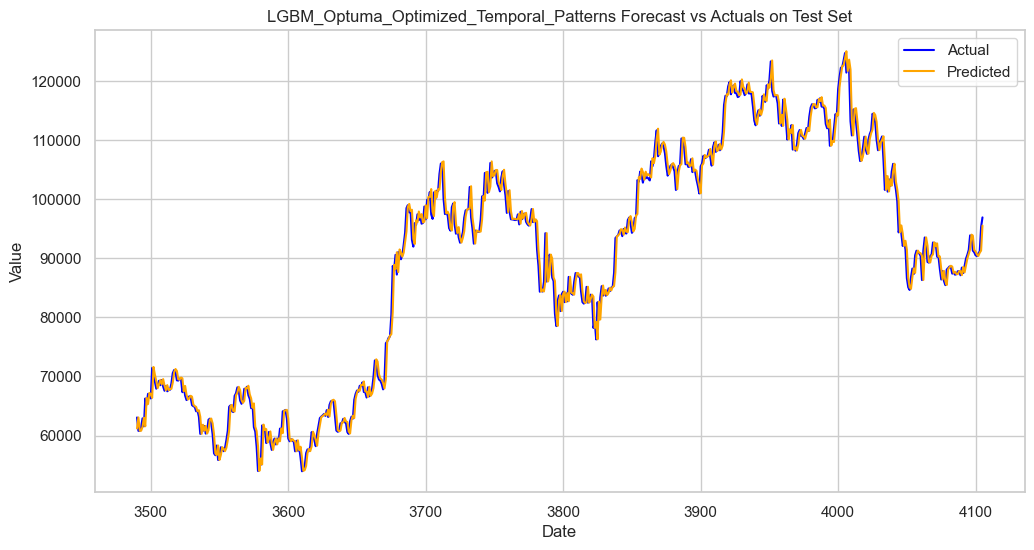

In [119]:
plot_forecasts(
    test_df.index,
    y_actual_prices_test,
    y_pred_prices_test,
    title=f"{best_model_name} Forecast vs Actuals on Test Set",
)

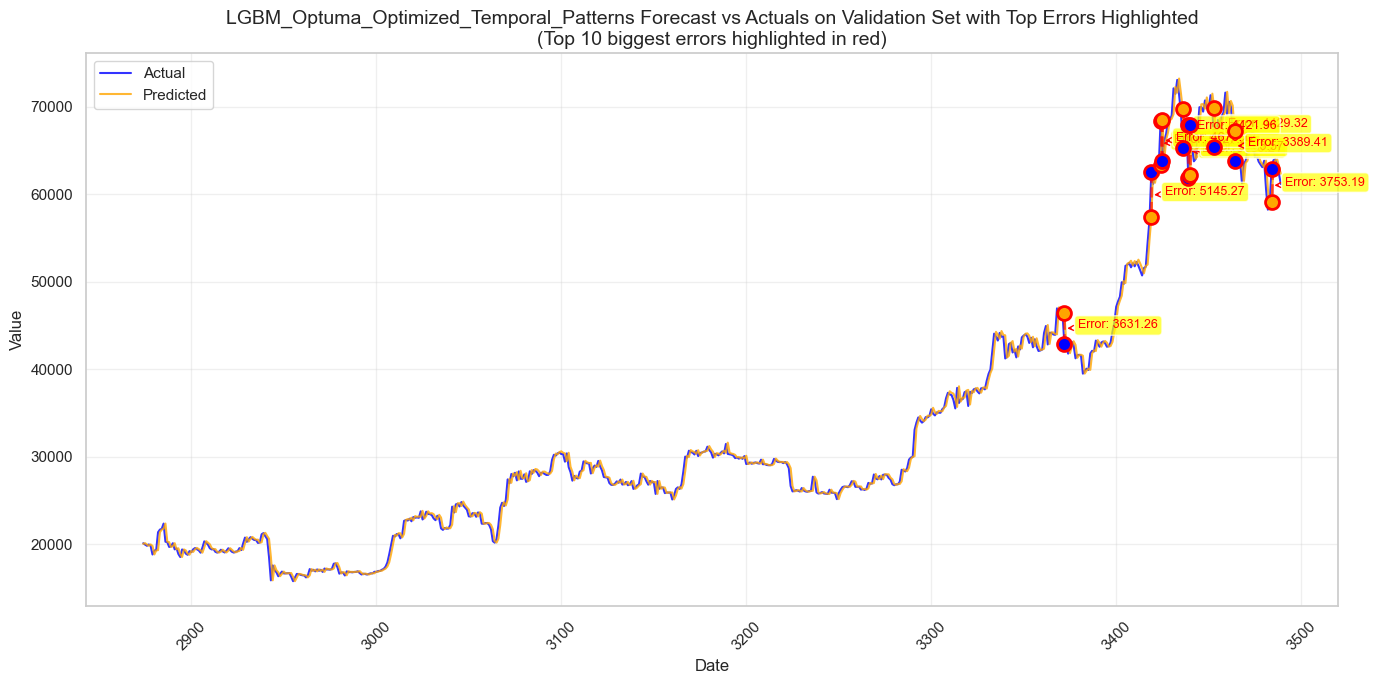


Top 10 Biggest Prediction Errors:
1. Date: 3439, Actual: 61912.77, Predicted: 67872.99, Error: 5960.21
2. Date: 3440, Actual: 67913.67, Predicted: 62210.10, Error: 5703.57
3. Date: 3419, Actual: 62504.79, Predicted: 57359.52, Error: 5145.27
4. Date: 3424, Actual: 68330.41, Predicted: 63303.17, Error: 5027.24
5. Date: 3425, Actual: 63801.20, Predicted: 68477.31, Error: 4676.12
6. Date: 3453, Actual: 65446.97, Predicted: 69876.29, Error: 4429.32
7. Date: 3436, Actual: 65315.12, Predicted: 69737.08, Error: 4421.96
8. Date: 3484, Actual: 62889.84, Predicted: 59136.64, Error: 3753.19
9. Date: 3372, Actual: 42853.17, Predicted: 46484.43, Error: 3631.26
10. Date: 3464, Actual: 63821.47, Predicted: 67210.88, Error: 3389.41


In [120]:
plot_forecasts_with_biggest_mistakes(
    val_df.index,
    val_df["Next_Close"],
    val_predictions,
    title=f"{best_model_name} Forecast vs Actuals on Validation Set with Top Errors Highlighted",
    highlight_top_n=10,
    show_error_values=True,
)

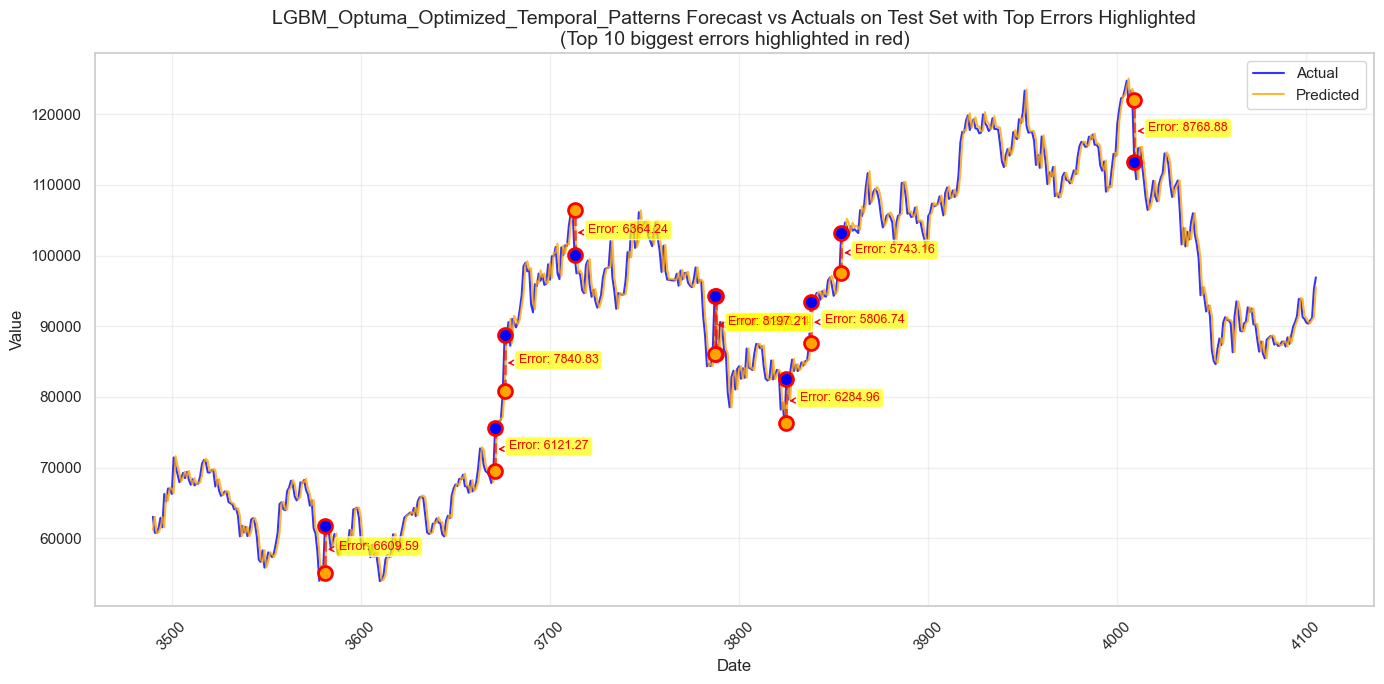


Top 10 Biggest Prediction Errors:
1. Date: 4009, Actual: 113214.37, Predicted: 121983.25, Error: 8768.88
2. Date: 3788, Actual: 86065.67, Predicted: 94269.41, Error: 8203.74
3. Date: 3787, Actual: 94248.35, Predicted: 86051.14, Error: 8197.21
4. Date: 3676, Actual: 88701.48, Predicted: 80860.65, Error: 7840.83
5. Date: 3581, Actual: 61710.14, Predicted: 55100.55, Error: 6609.59
6. Date: 3713, Actual: 100041.54, Predicted: 106405.78, Error: 6364.24
7. Date: 3825, Actual: 82573.95, Predicted: 76289.00, Error: 6284.96
8. Date: 3671, Actual: 75639.08, Predicted: 69517.80, Error: 6121.27
9. Date: 3838, Actual: 93441.89, Predicted: 87635.15, Error: 5806.74
10. Date: 3854, Actual: 103241.46, Predicted: 97498.30, Error: 5743.16


In [121]:
plot_forecasts_with_biggest_mistakes(
    test_df.index,
    y_actual_prices_test,
    y_pred_prices_test,
    title=f"{best_model_name} Forecast vs Actuals on Test Set with Top Errors Highlighted",
    highlight_top_n=10,
    show_error_values=True,
)

## 6. Conclusion and Next Steps

### Key Findings

After extensively evaluating multiple forecasting approaches across different model types (statistical, machine learning, and deep learning), several important conclusions emerge:

#### 1. **Challenge of Next-Day Price Prediction**

One of the most significant findings from this analysis is that **predicting the next day's Bitcoin price is extremely challenging**. The simple naive baseline—using the previous day's closing price as the prediction—proves to be a remarkably strong benchmark that most sophisticated models struggle to outperform.

This observation highlights a fundamental characteristic of Bitcoin prices:
- **High autocorrelation**: The previous day's price is a strong predictor of the next day's price
- **Market efficiency**: Much of the predictable information is already reflected in current prices
- **Random walk behavior**: Day-to-day price movements contain a significant random component

Even advanced models like LSTM, GRU, XGBoost, and LightGBM, despite their ability to capture complex patterns, show only marginal improvements (if any) over the naive baseline for absolute price predictions.

#### 2. **Returns vs. Prices: A Critical Distinction**

An important lesson from this analysis is that **modeling returns rather than absolute prices** is a more appropriate approach for financial forecasting:

- **Returns are stationary**: Unlike prices, which exhibit trends and non-stationarity, returns are more suitable for statistical modeling
- **Better theoretical foundation**: Financial theory is built around returns, not price levels
- **Risk management focus**: Returns directly relate to portfolio gains/losses and risk metrics
- **Improved model performance**: Several models showed better predictive power when forecasting returns rather than prices

The models that predicted returns (and then converted back to prices) often demonstrated more meaningful insights and better directional accuracy.

#### 3. **Model Performance Summary**

Based on the evaluation metrics (MAE, RMSE, MAPE, Directional Accuracy):
- **Statistical models** (ARIMA, SARIMA, Exponential Smoothing) performed reasonably well but were limited by their linear assumptions
- **Machine learning models** (XGBoost, LightGBM) showed promise, especially when predicting returns with proper feature engineering and hyperparameter tuning
- **Deep learning models** (LSTM, GRU) captured temporal dependencies but required careful tuning and larger datasets to truly excel
- **Prophet** provided reasonable forecasts with trend and seasonality components but didn't significantly outperform simpler baselines

### Next Steps

#### **Shift Focus to Volatility Prediction**

Rather than continuing to predict next-day prices (which hover close to the naive baseline), **the next notebook will focus on forecasting Bitcoin price volatility - classifying it into discrete categories**:

- **Longer prediction horizon**: Forecast volatility for longer periods (e.g., 7 or 30 days ahead)
- **More practical application**: Volatility forecasts are crucial for:
  - Risk management and portfolio optimization
  - Options pricing and derivatives trading
  - Position sizing decisions
  - Market timing strategies
- **Better model differentiation**: Volatility exhibits more predictable patterns than raw prices


**Conclusion**: While predicting next-day Bitcoin prices remains challenging due to market efficiency and random walk characteristics, this analysis provides valuable insights into model capabilities and limitations. The shift toward volatility forecasting represents a more practical and theoretically sound direction for cryptocurrency prediction, with direct applications to risk management and trading strategies.